In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.funcs import *
from pathlib import Path
from collections import defaultdict

# survival analysis
from lifelines.statistics import logrank_test

sns.set(font_scale = 1.25,
        style="whitegrid",
        rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(8,6)})

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path.home() / "data/bioinfo_sm207"

In [4]:
response = pd.read_csv(
    Path.home() / "data/zuma7_signatures_log2/rnaseq_screening_response.csv",
    index_col=0)
response.head()

,Core ID,LV8 Molecular Batch ID,Subject ID_old,Collection Date_old,Site ID_old,Visit_old,Treatment_Arm_01,Randomization_Date,Treatment_Start_Date 01,HDT_Date_01,...,Macrodissection (YES/NO),RNA Conc (ng/ul),Elution Vol (ul),RNA Vol used for testing (ul),Residual RNA (ul) based on the volume used for testing,Tested on NanoString Run#,Testing Status,Comments,Visit_formatted,Collection Date_formatted
SM201-001,SM201-001,N1800110-KTP-00001,107-002-001,2017-08-08 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-25 00:00:00,2018-02-19 00:00:00,.,...,NO,16.8,26,10,16.000000,Run-1,Completed,NaN,Screening,2017-08-08
SM201-003,SM201-003,N1800110-KTP-00003,107-002-002,2017-04-13 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-31 00:00:00,2018-02-26 00:00:00,.,...,NO,55.9,26,2.683363148479428,23.316637,Run-1,Completed,NaN,Screening,2017-04-13
SM201-004,SM201-004,N1800110-KTP-00004,107-005-001,2017-08-14 00:00:00,5,Screening,Standard of Care Therapy,2018-02-09 00:00:00,2018-02-15 00:00:00,.,...,NO,44.5,26,3.3707865168539324,22.629213,Run-1,Completed,NaN,Screening,2017-08-14
SM201-005,SM201-005,N1800110-KTP-00005,107-031-001,2018-04-03 00:00:00,31,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-04-04 00:00:00,2018-06-13 00:00:00,...,YES,19.2,26,5,21.000000,Run-1,Completed,NaN,Screening,2018-04-03
SM201-006,SM201-006,N1800110-KTP-00006,107-019-002,2018-03-30 00:00:00,19,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-03-31 00:00:00,.,...,NO,85.9,26,1.7462165308498252,24.253783,Run-1,Completed,NaN,Screening,2018-03-30


In [5]:
arms = ["AXICEL", "SOC"]
params = ["DOR", "EFS", "PFS"]

In [6]:
# ecotyper results
ecotyper_results = [d for d in (data_path/"ecotyper_outs/zuma7_tpm").iterdir() if d.is_dir()]
len(ecotyper_results)

14

In [7]:
ecotyper_results[:3]

[PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/zuma7_tpm/B.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/zuma7_tpm/Plasma.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/zuma7_tpm/T.cells.CD8')]

In [8]:
# add assignment to response for each output
for d in ecotyper_results:
    if d.name == "Ecotypes":
        fn = "ecotype_assignment.txt"
        col = "Ecotype"
    else:
        fn = "state_assignment.txt"
        col = "State"
    assignment = pd.read_csv(d/fn, sep="\t")

    # use ID as index
    assignment.set_index("ID", inplace=True)
    # remove index name
    assignment.index.name = None
    assignment.index = assignment.index.map(lambda x: x.replace(".", "-"))
    # add the col to the response
    res = assignment[col]
    res.name = f"ecotyper_{d.name}_group"
    response = response.join(res)
    # fill na with unassigned 
    response[f"ecotyper_{d.name}_group"].fillna("Unassigned", inplace=True)

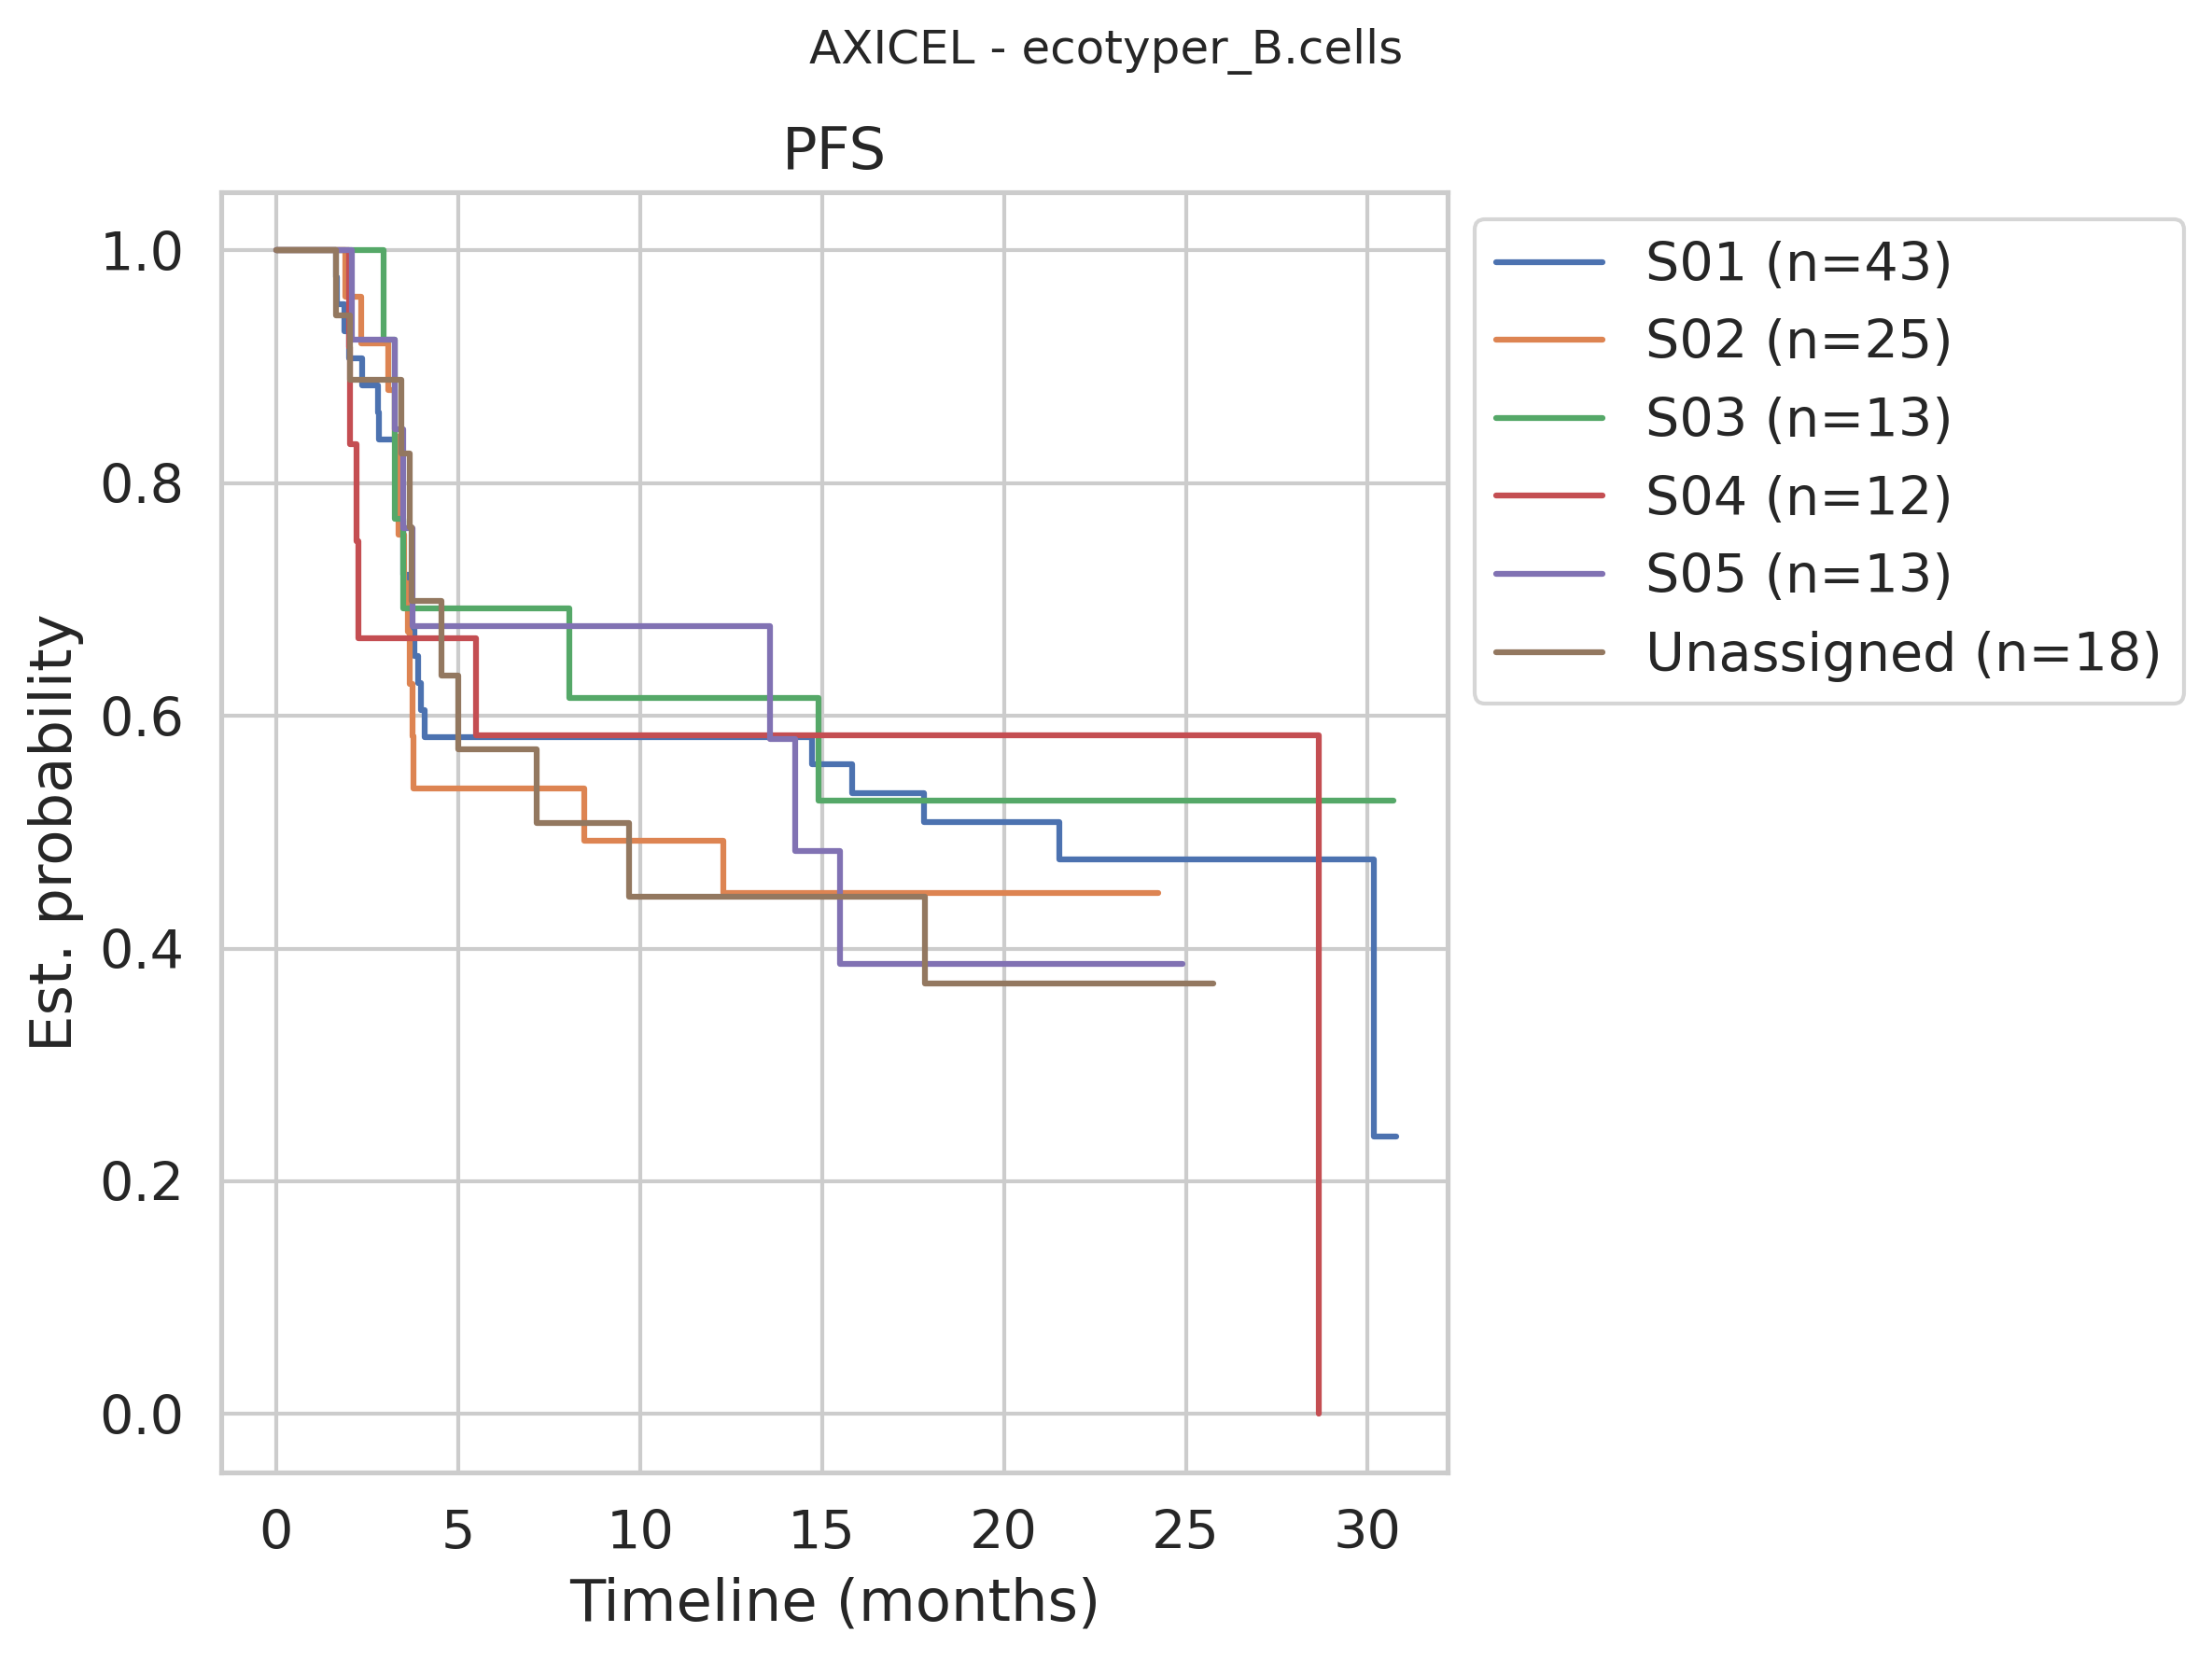

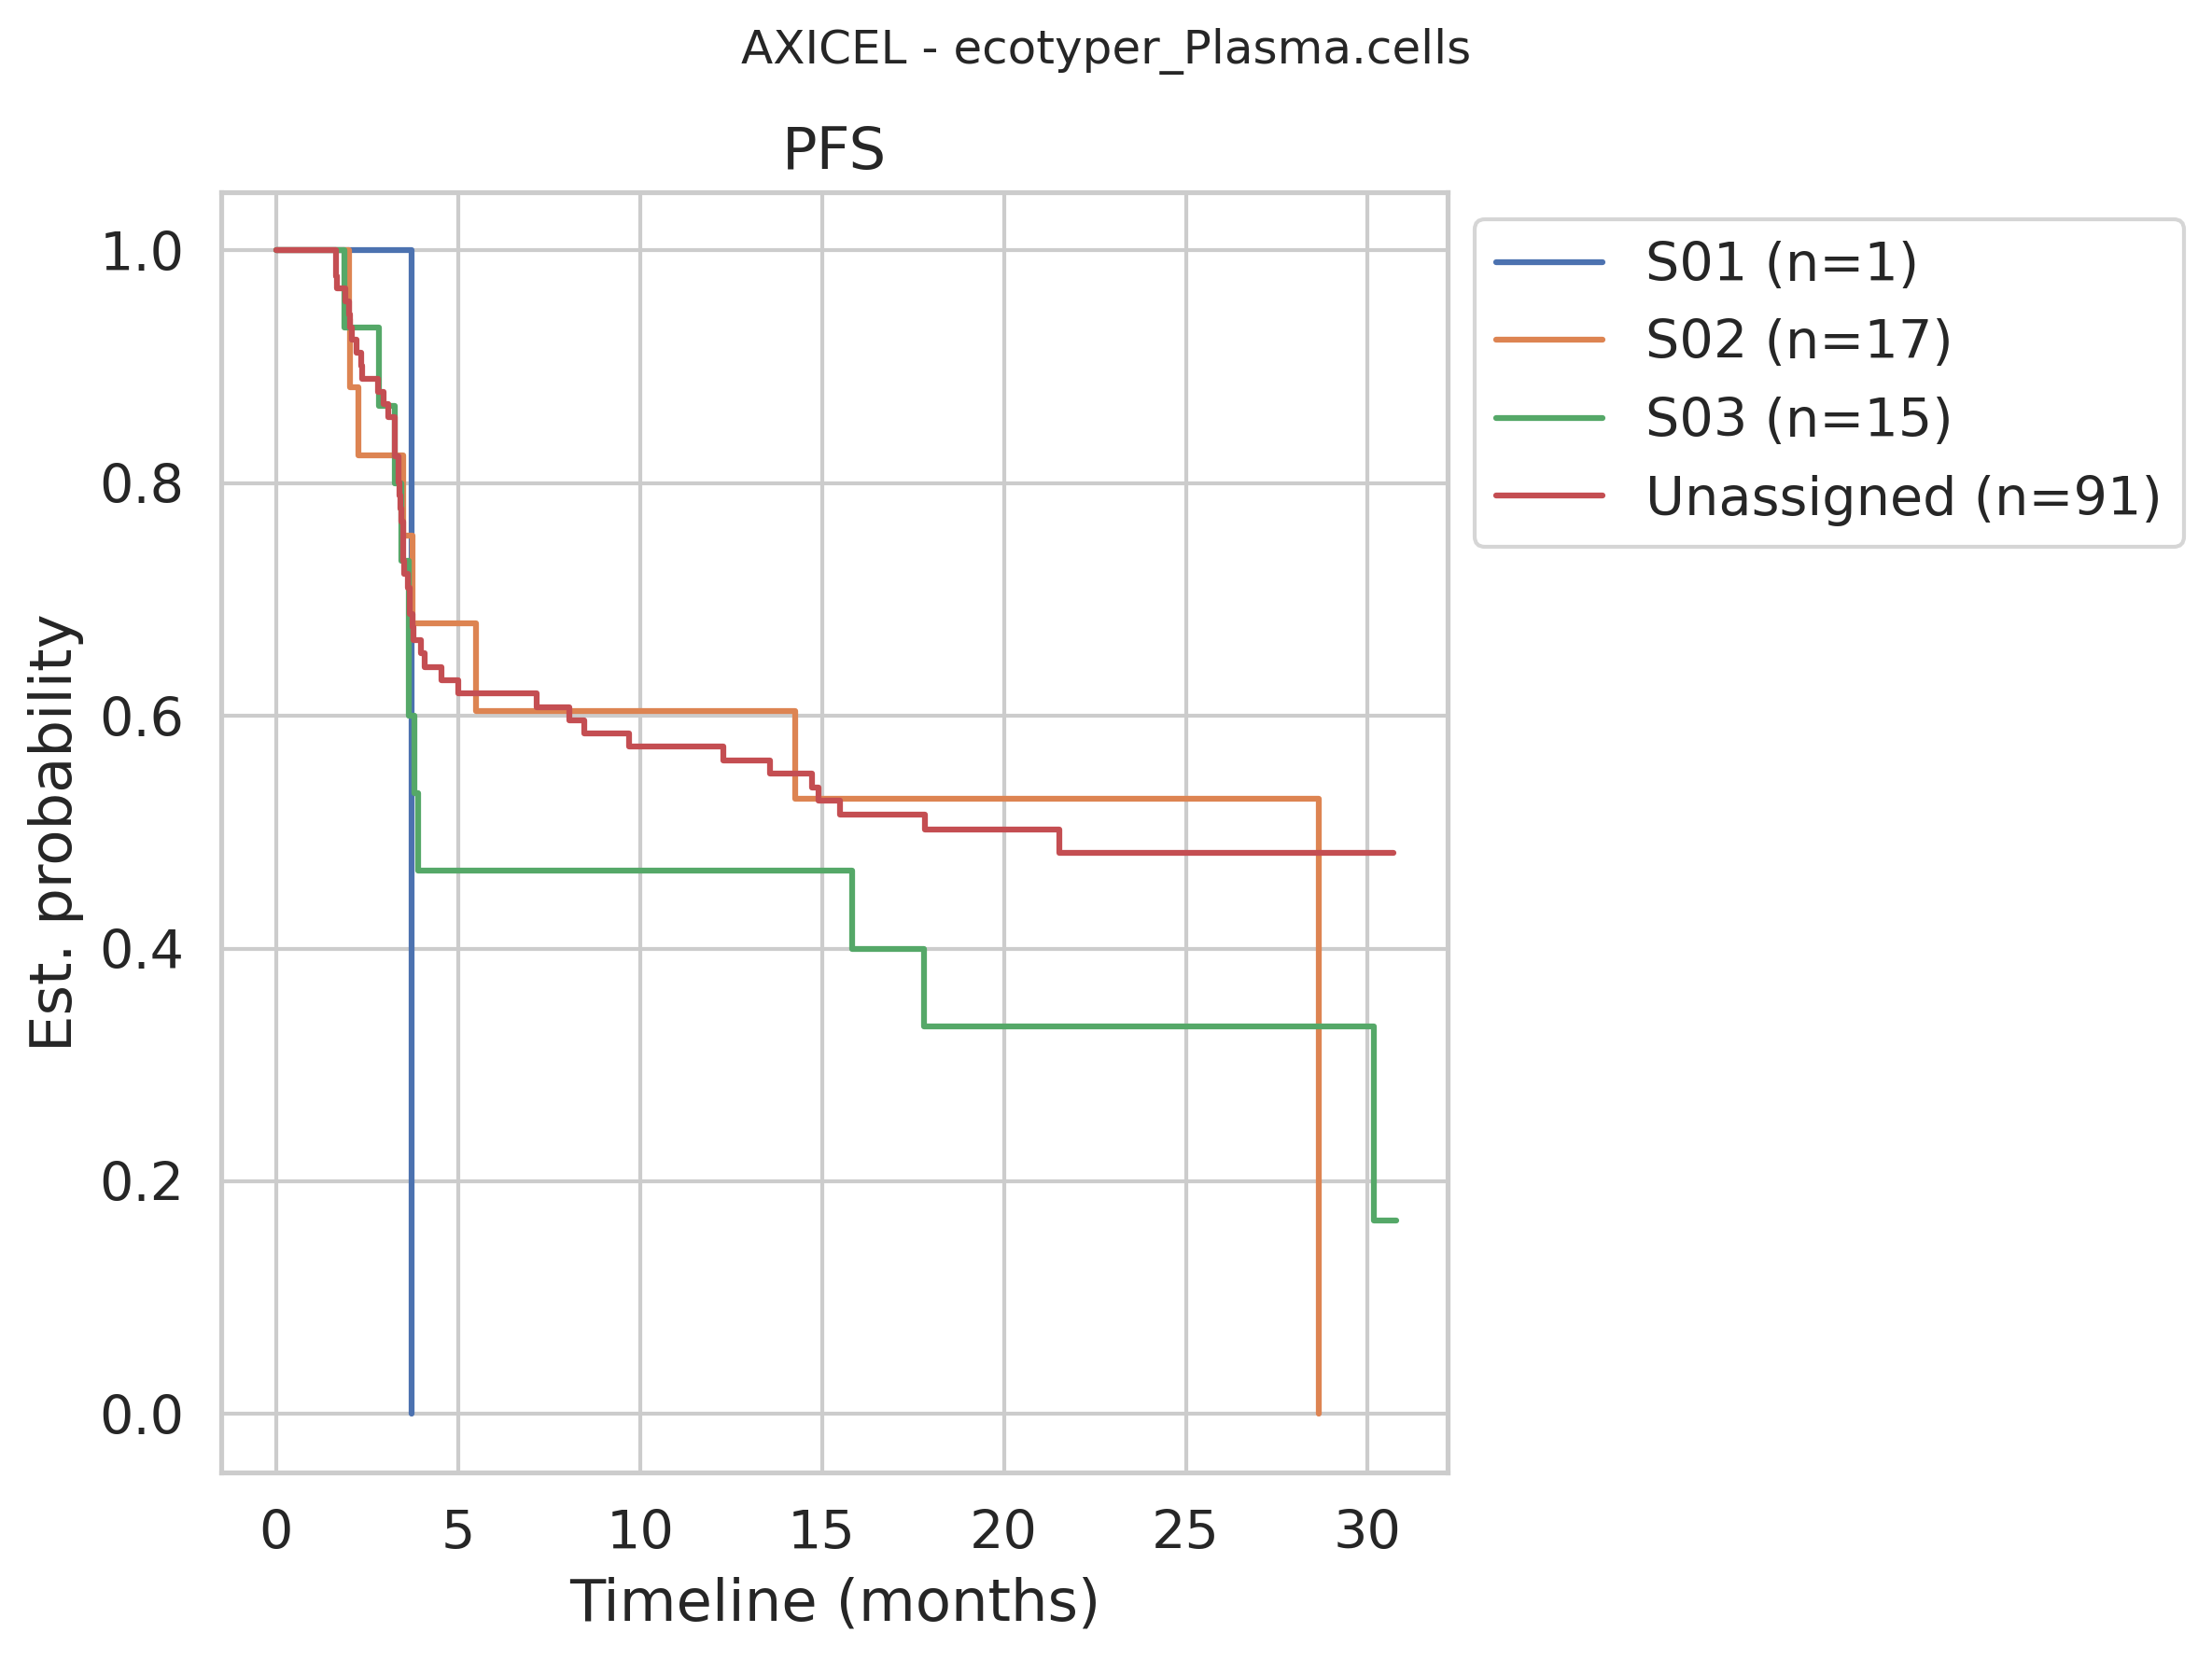

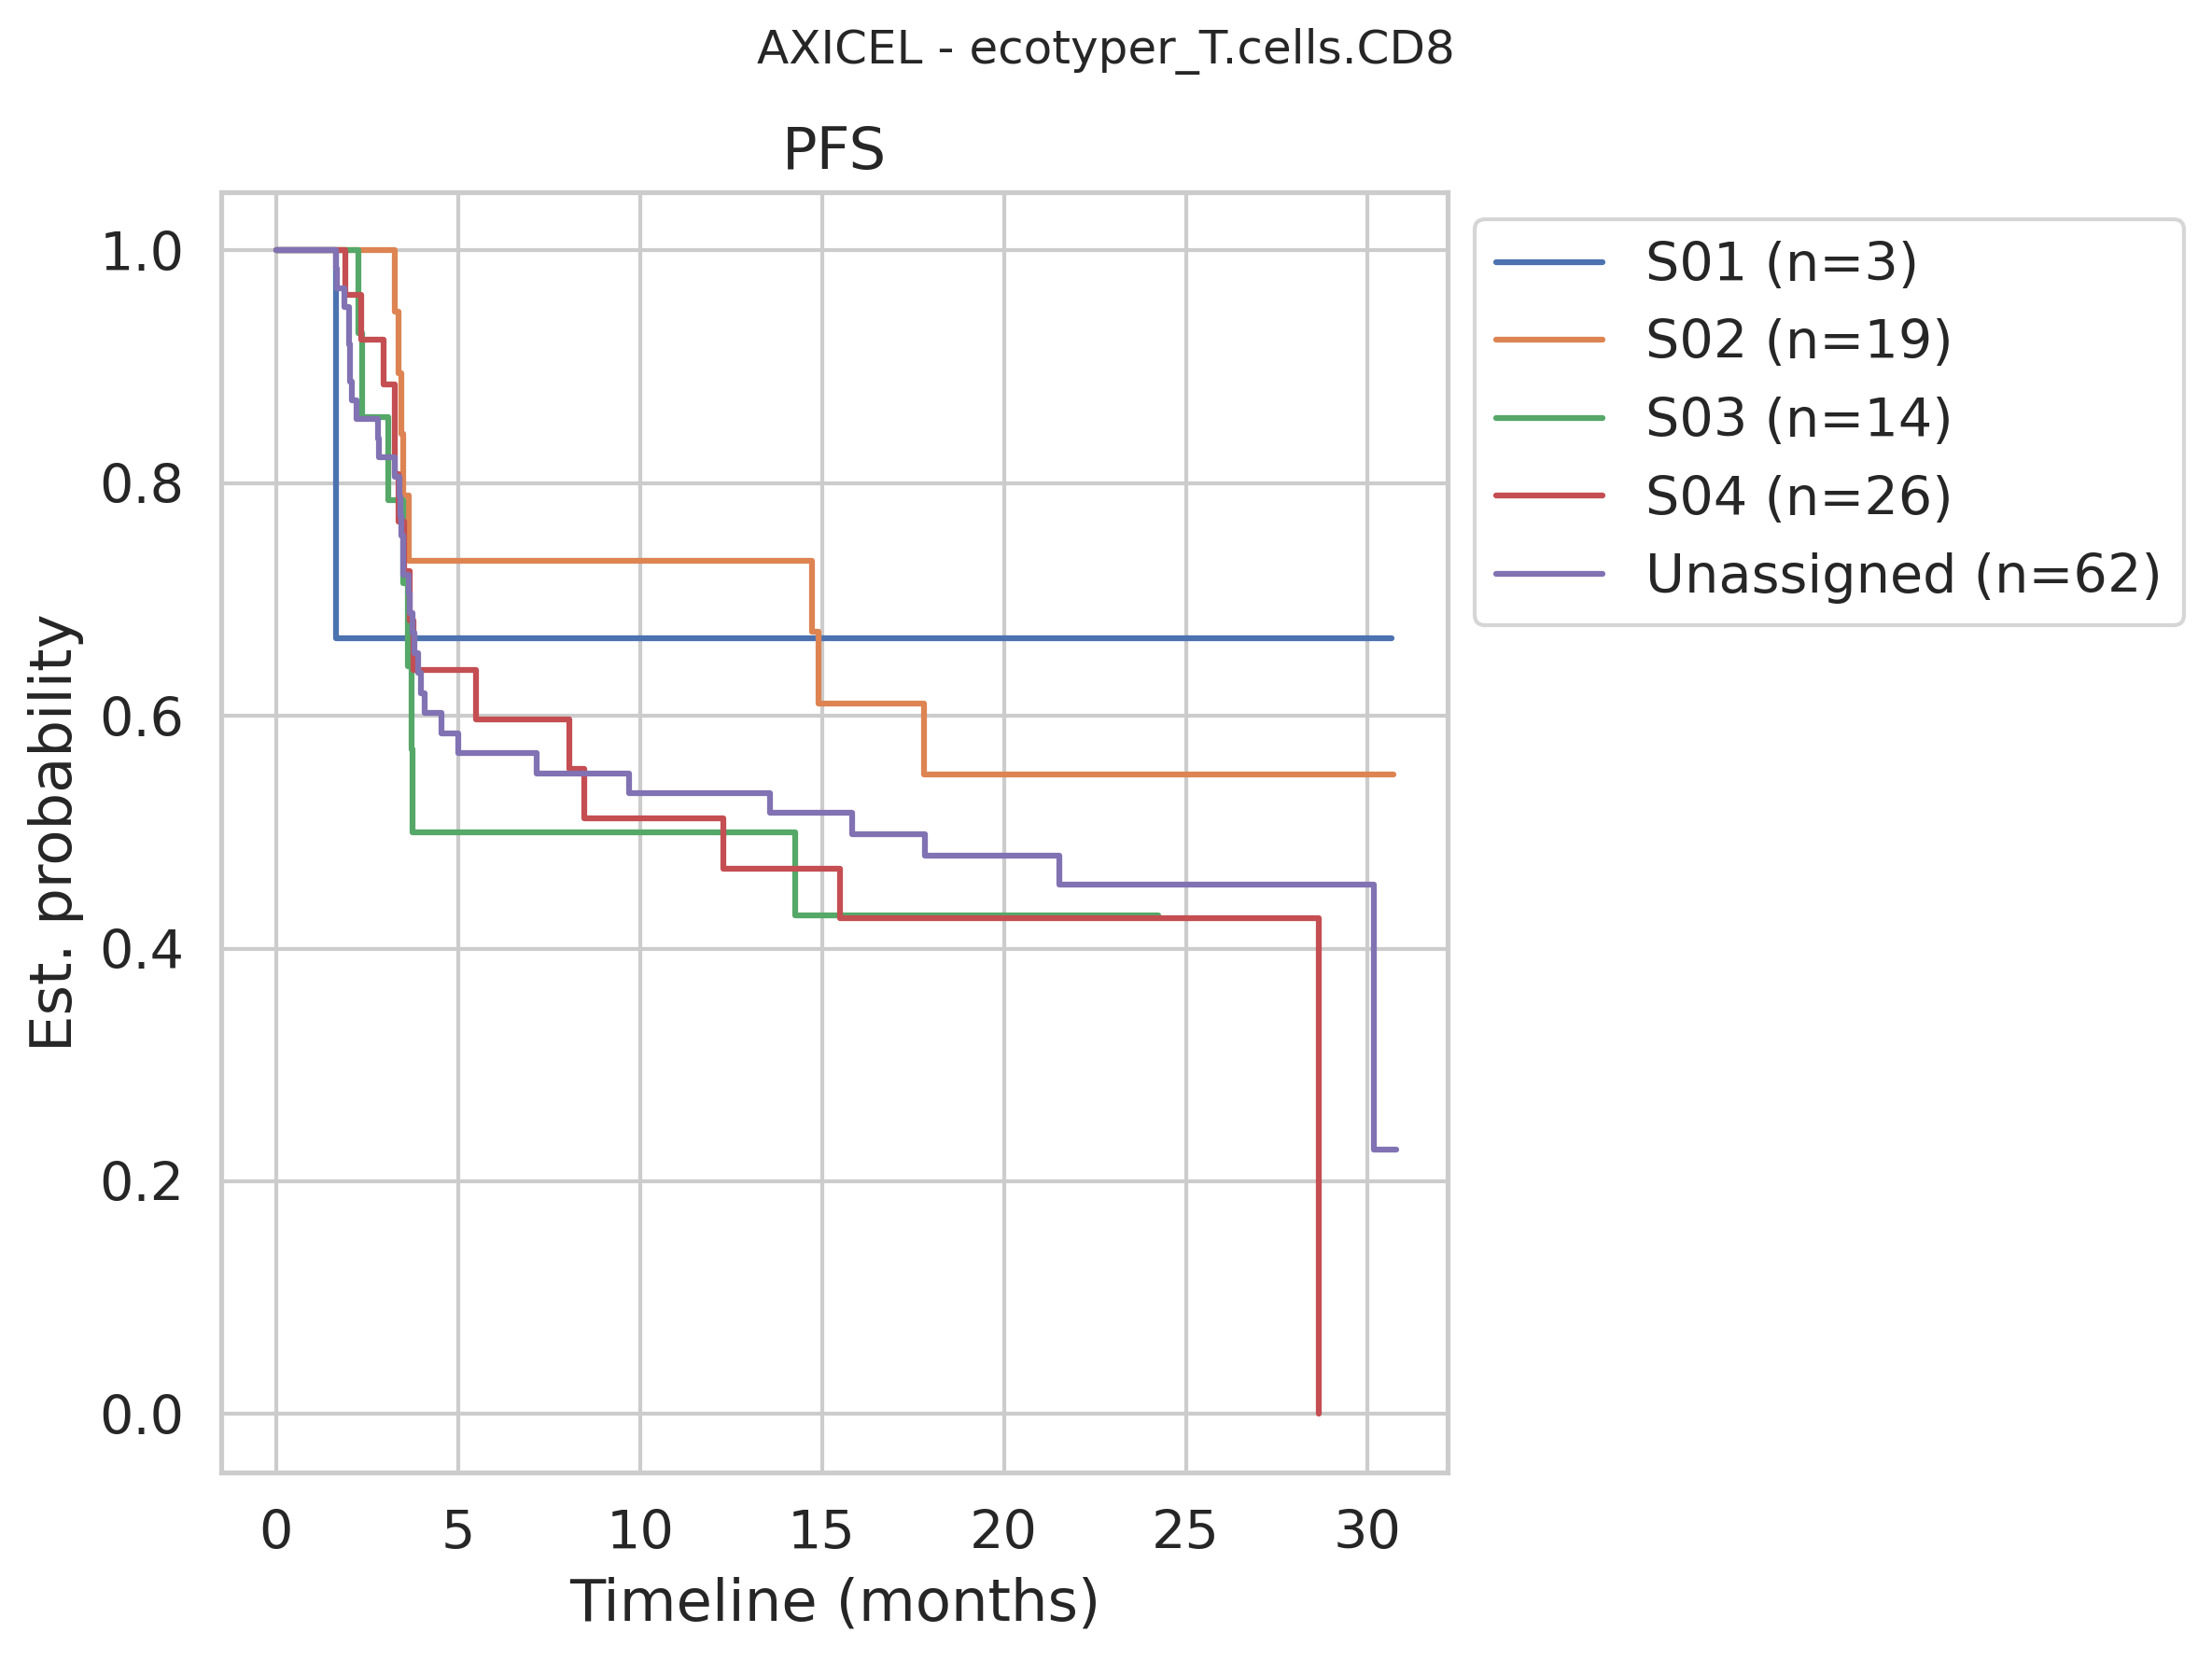

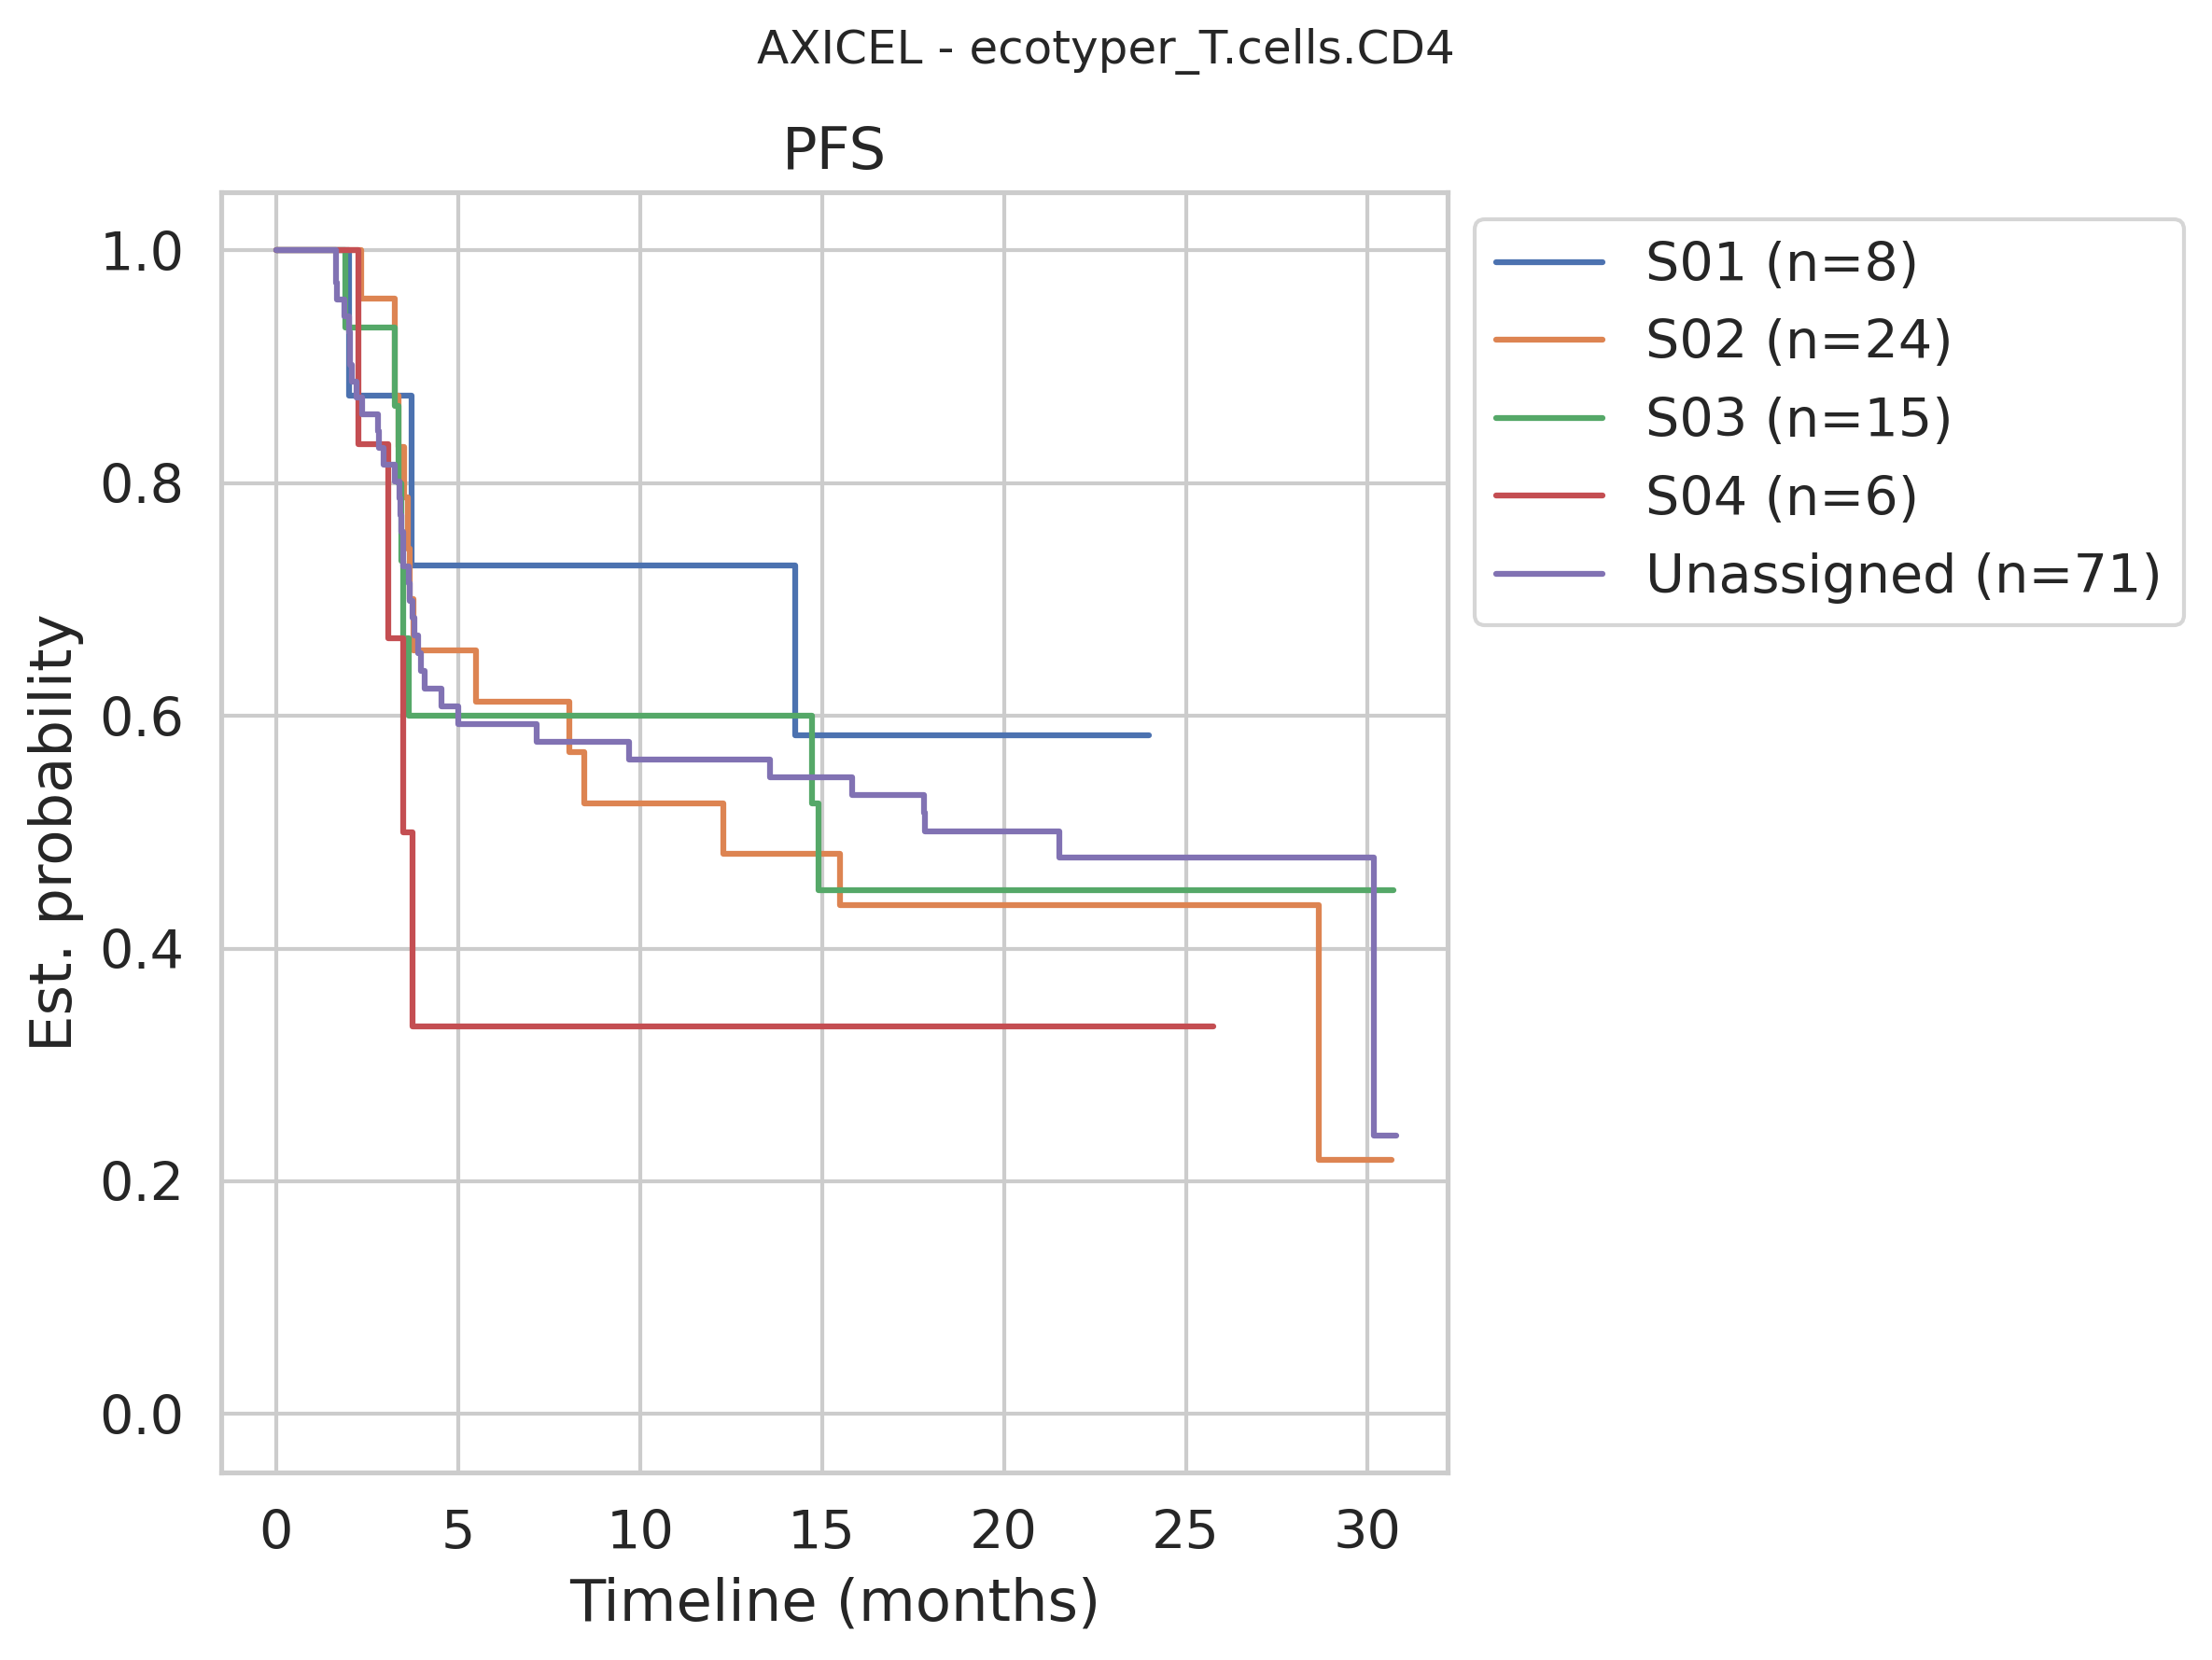

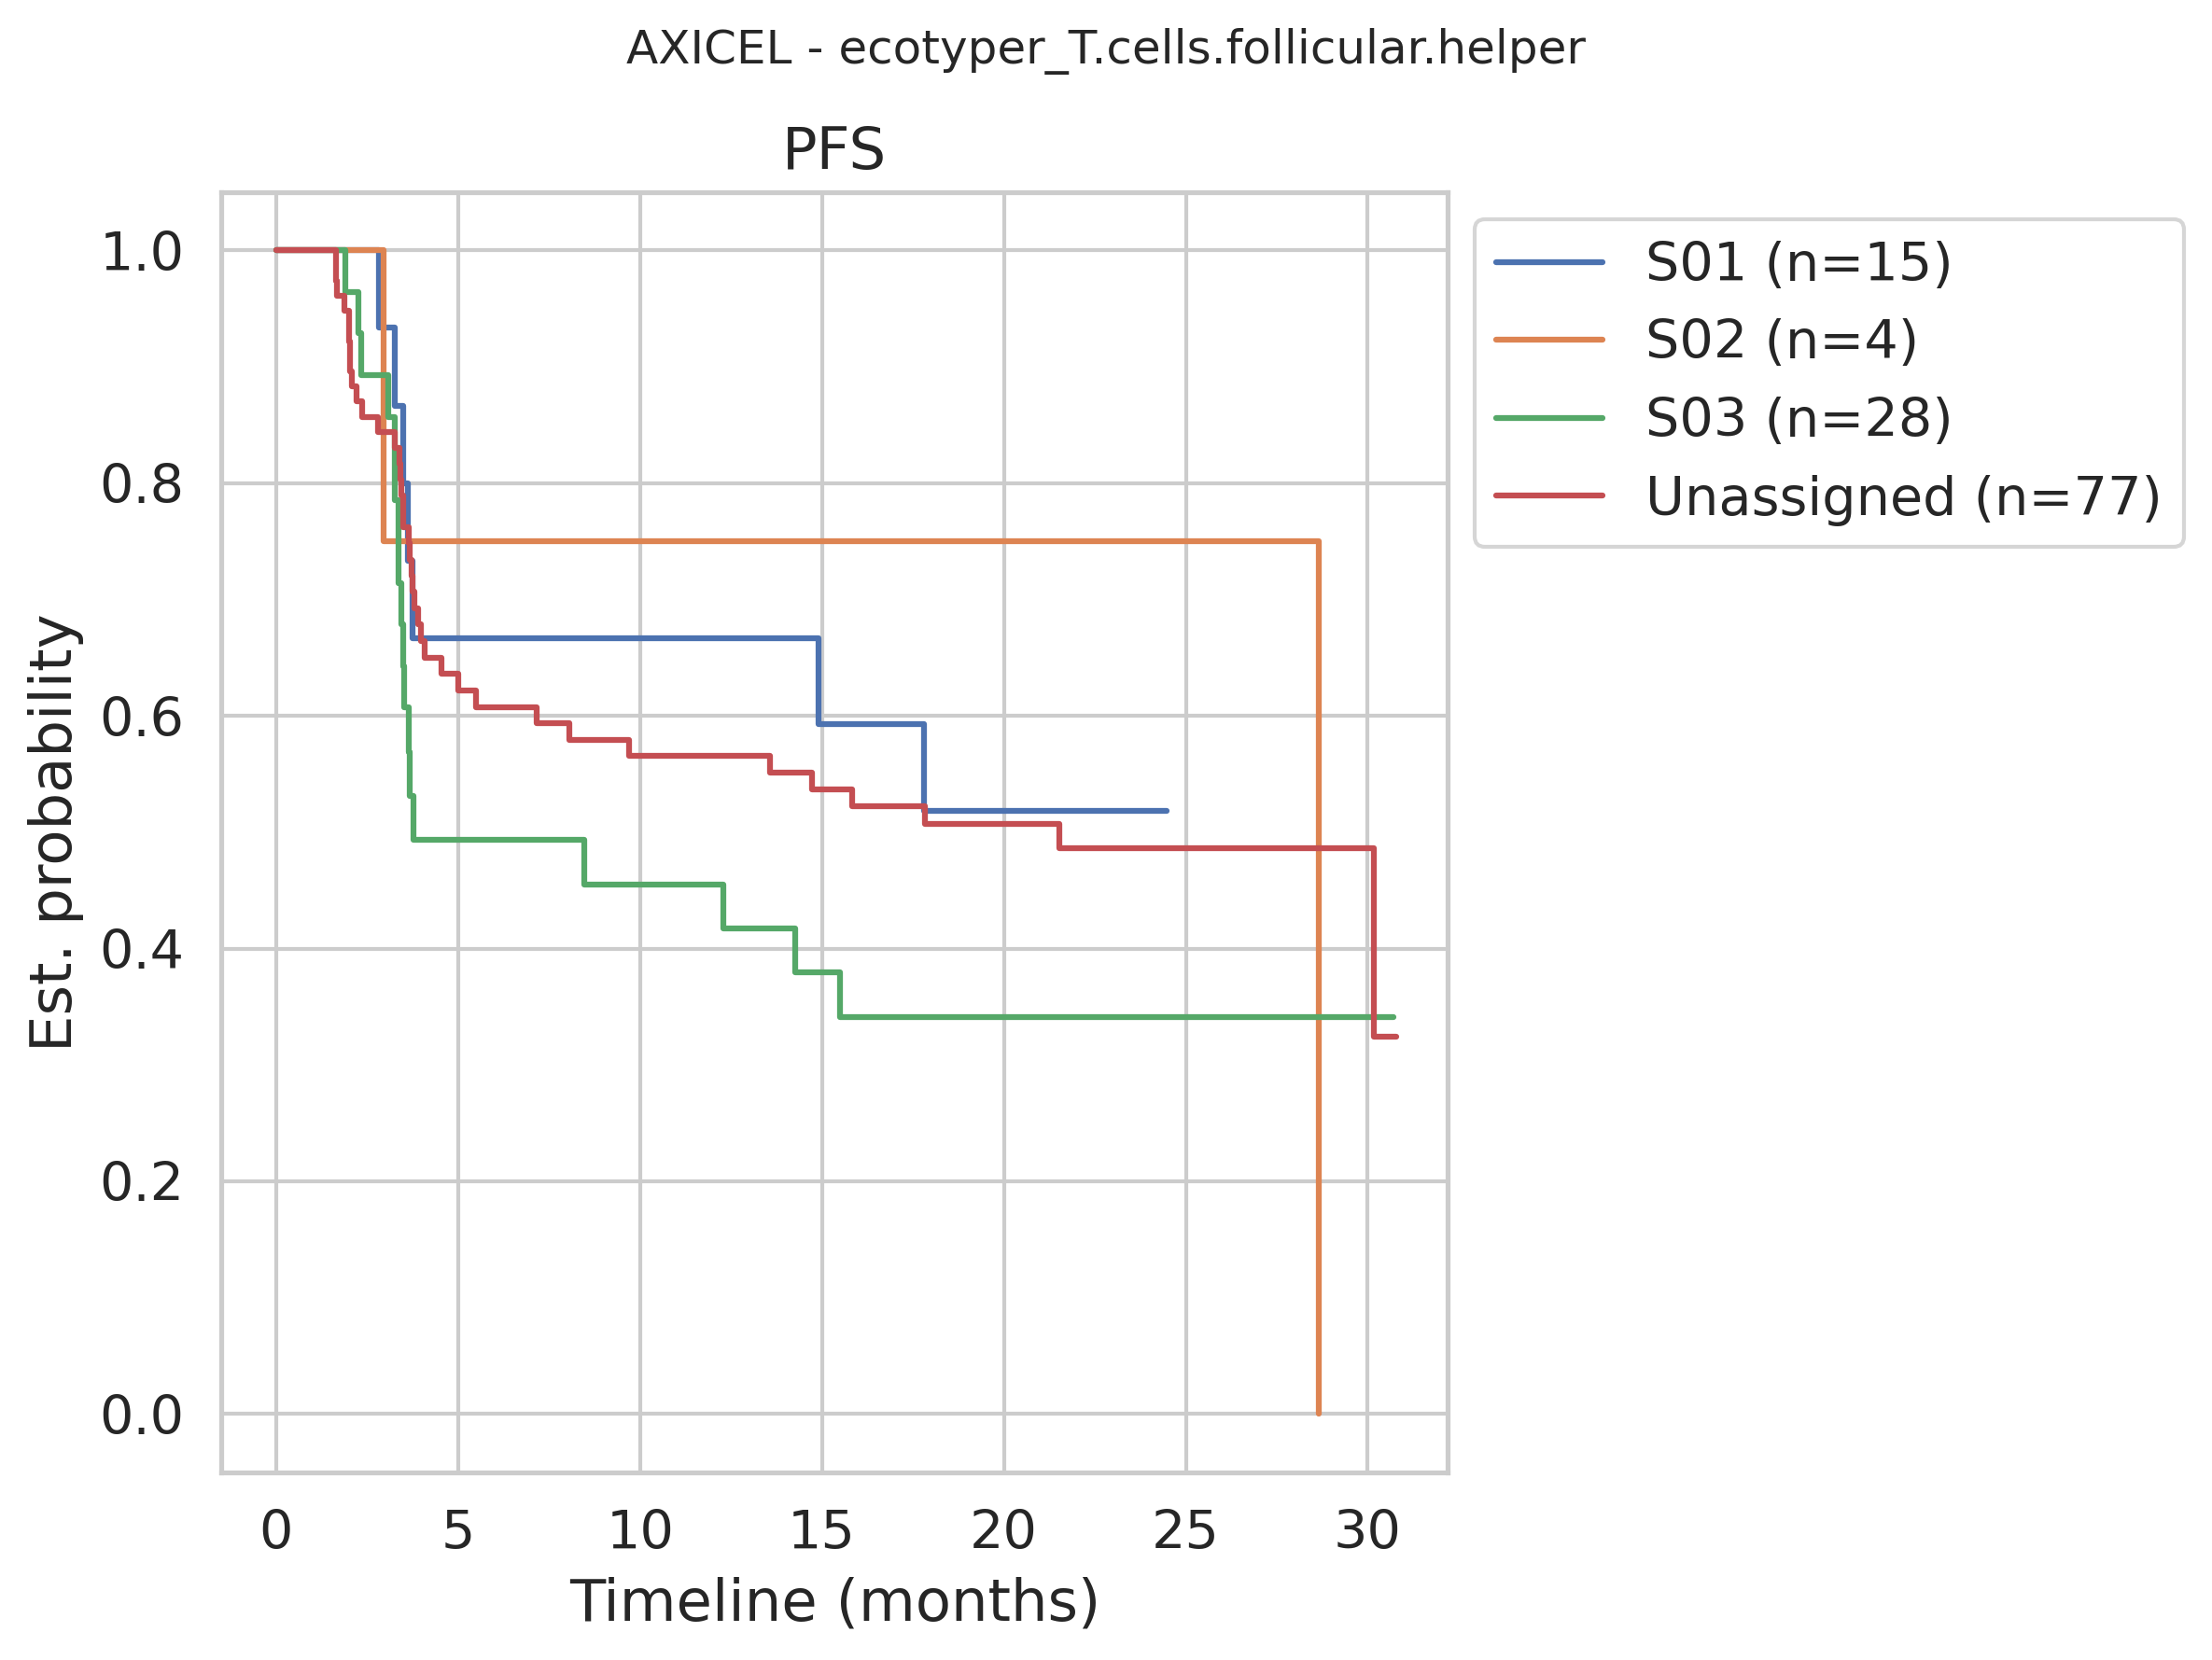

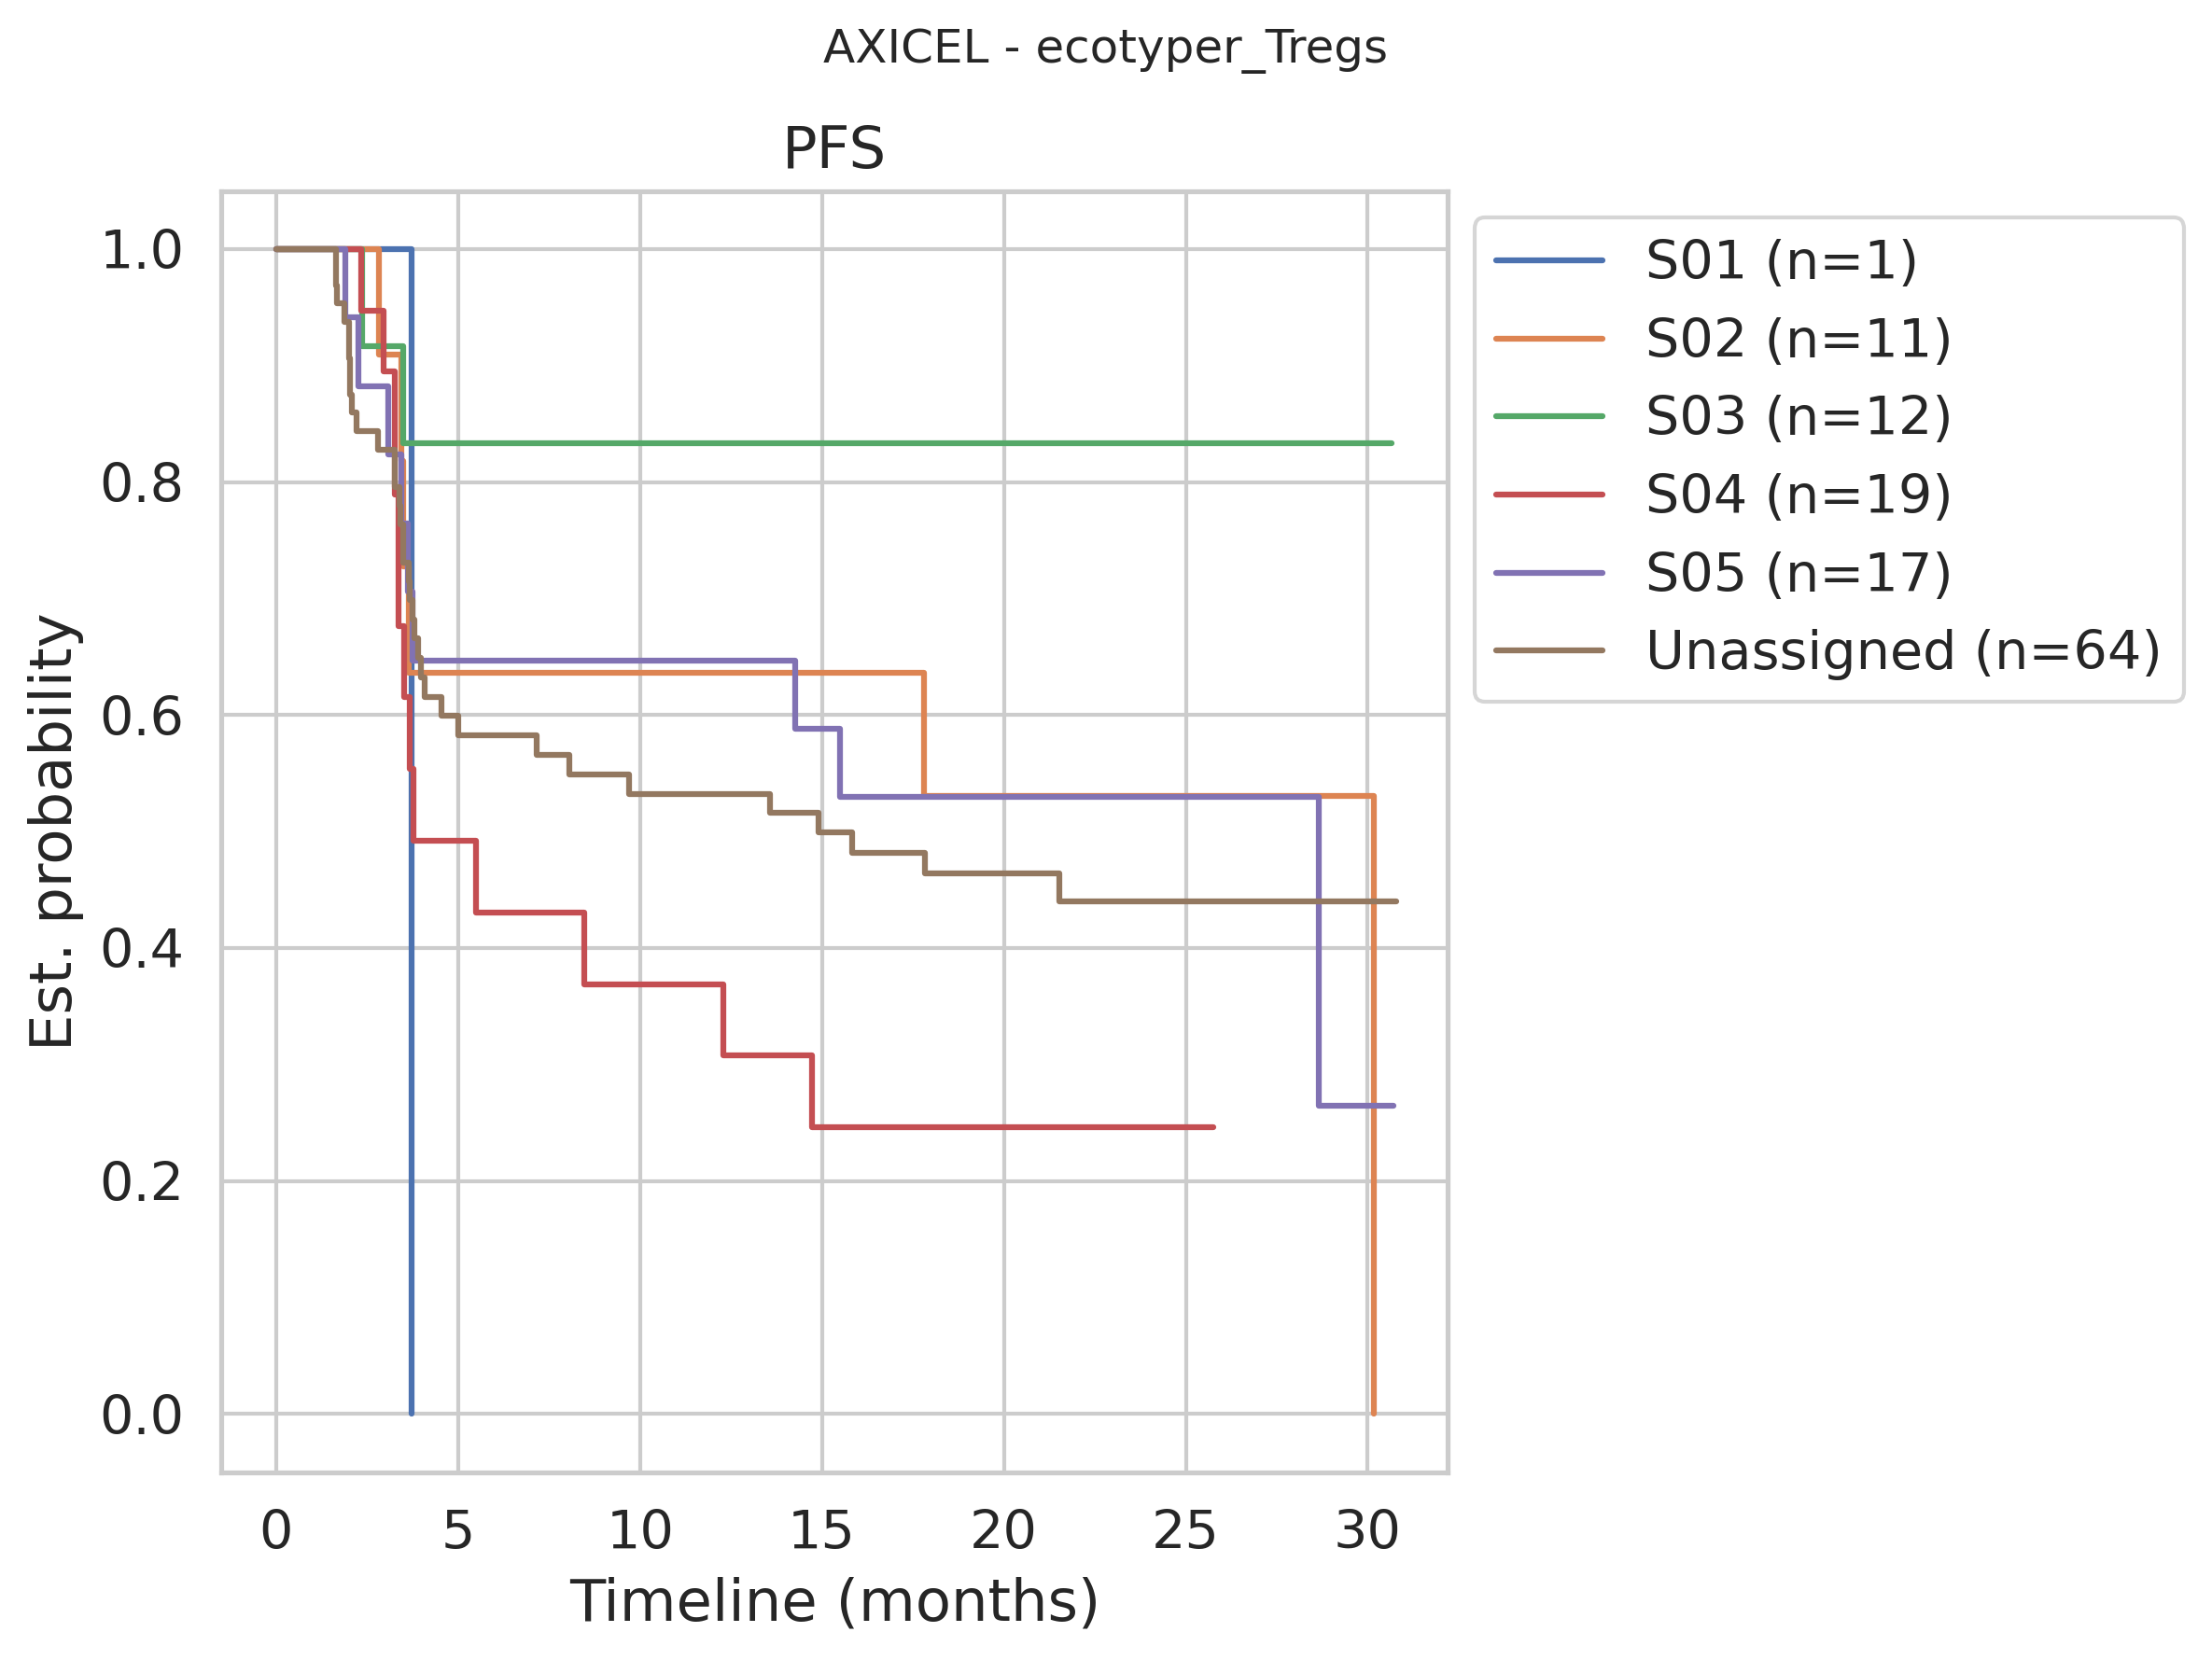

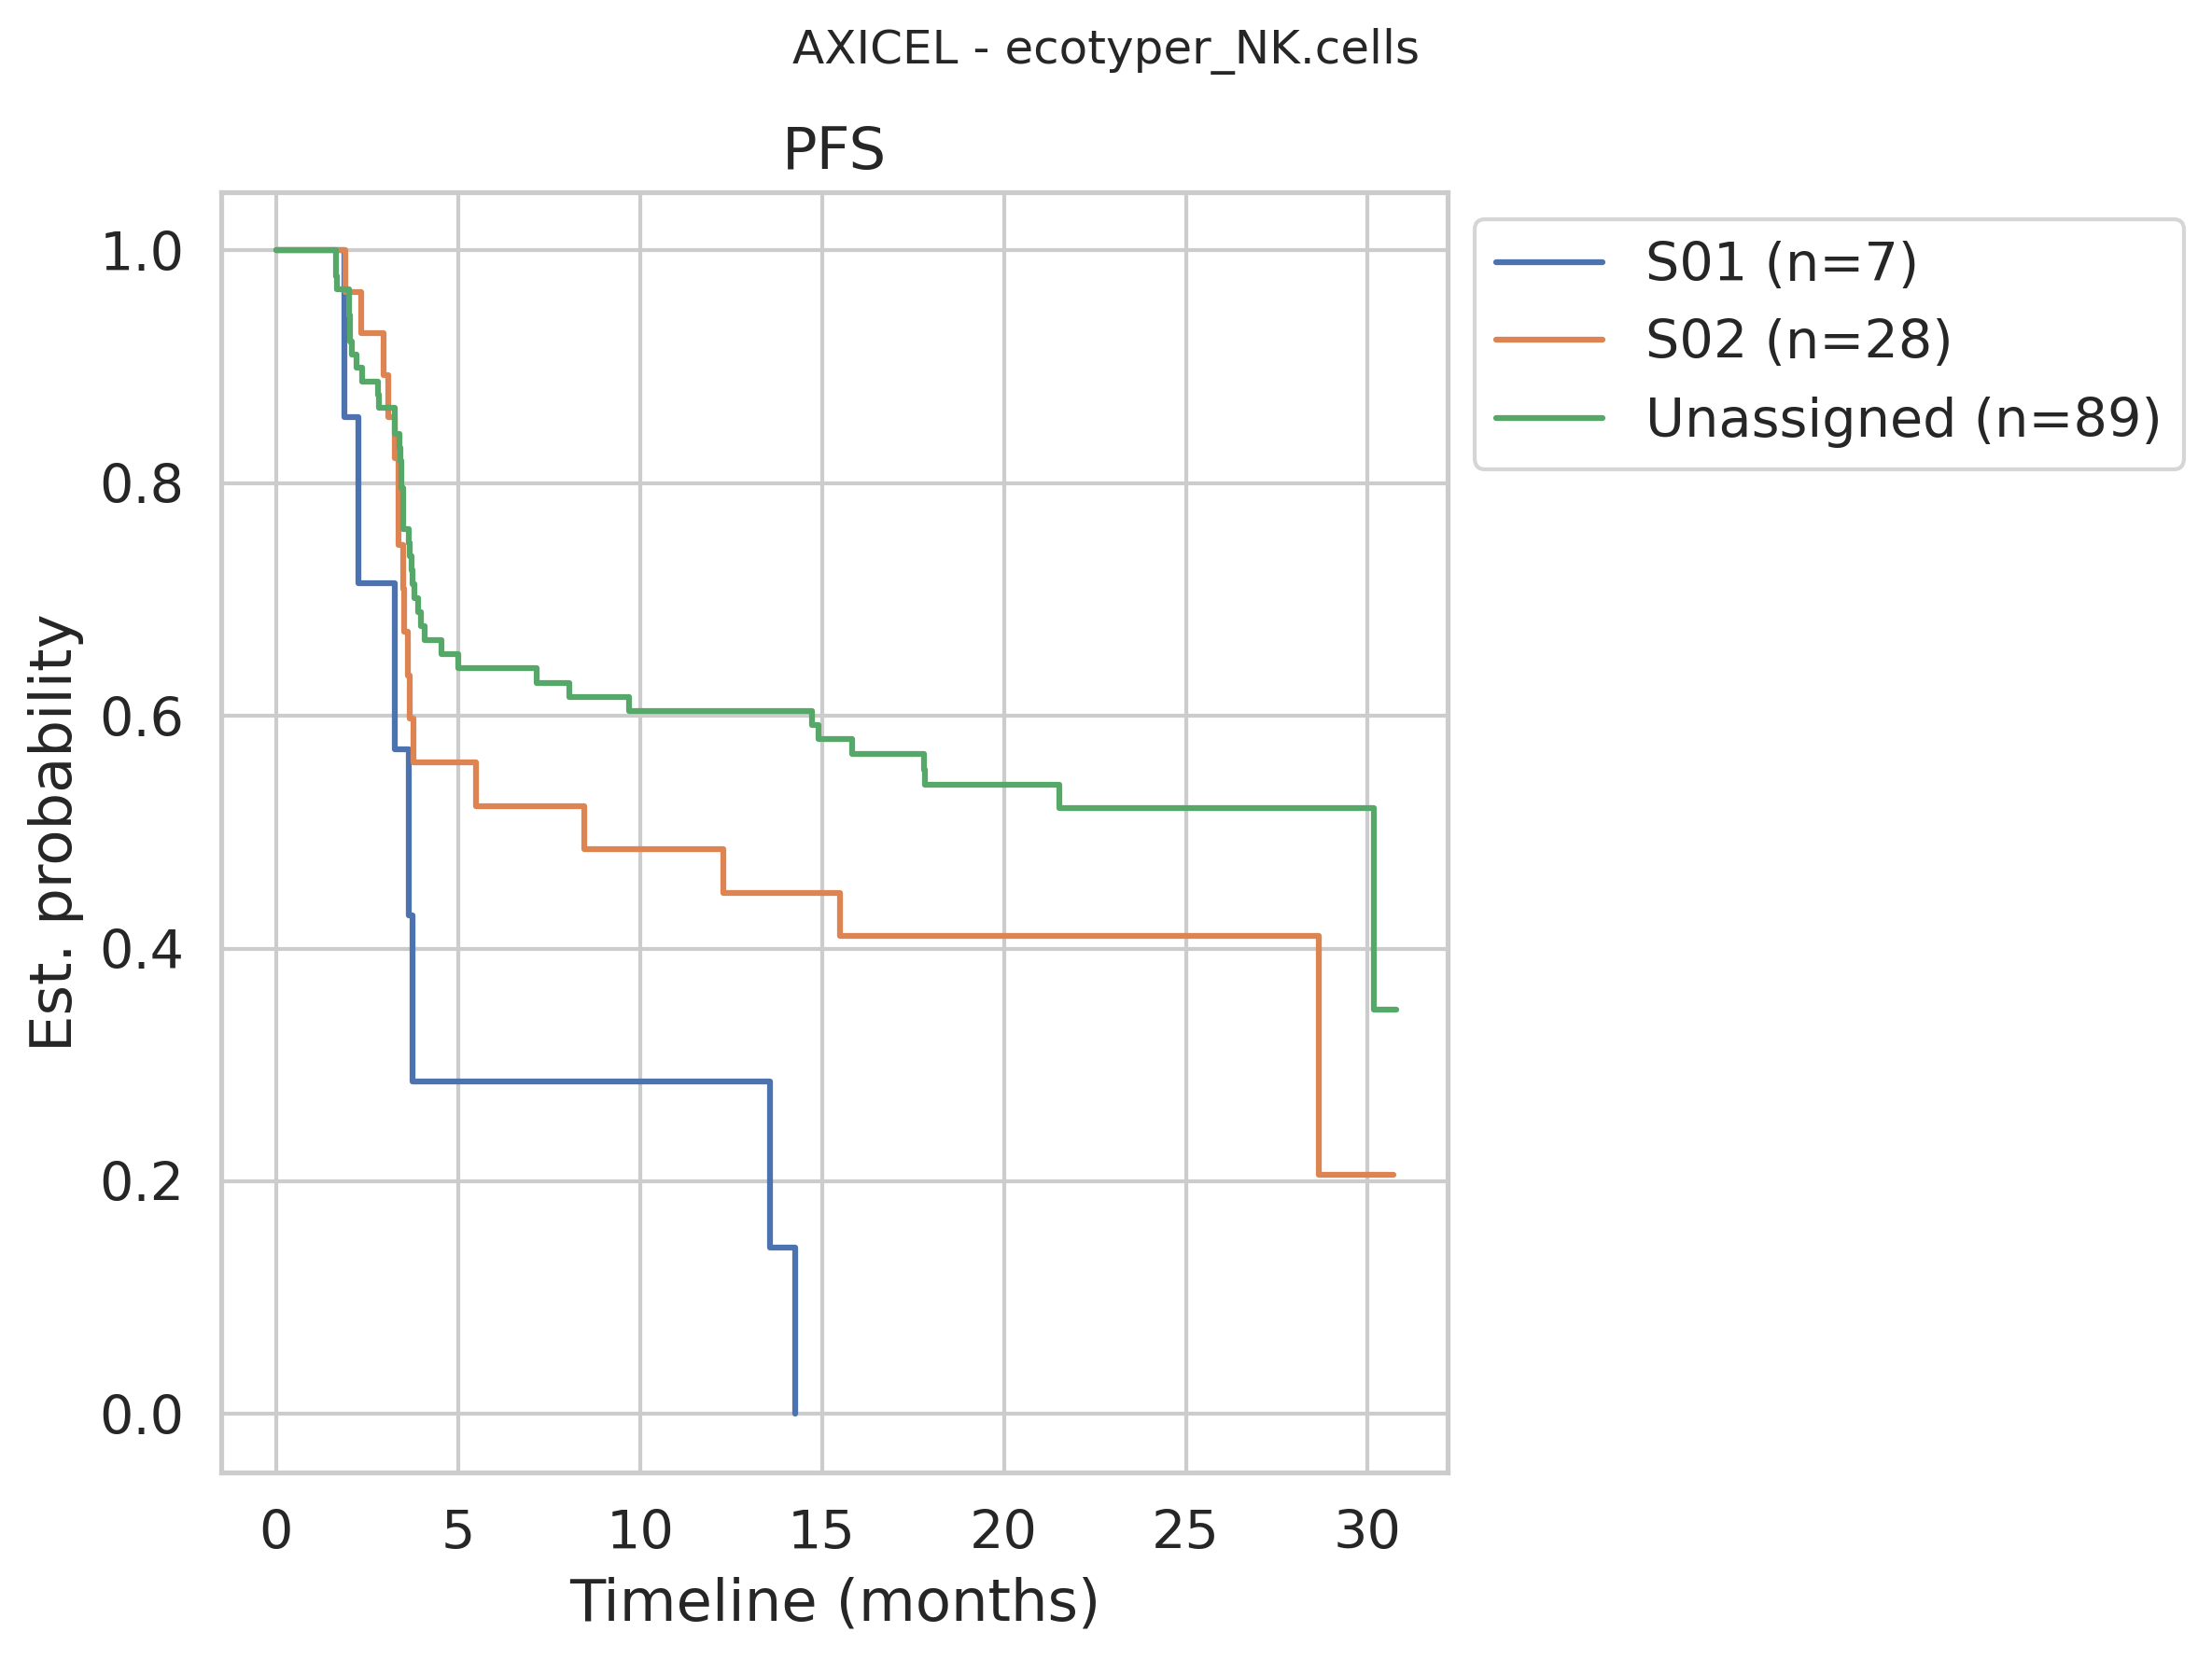

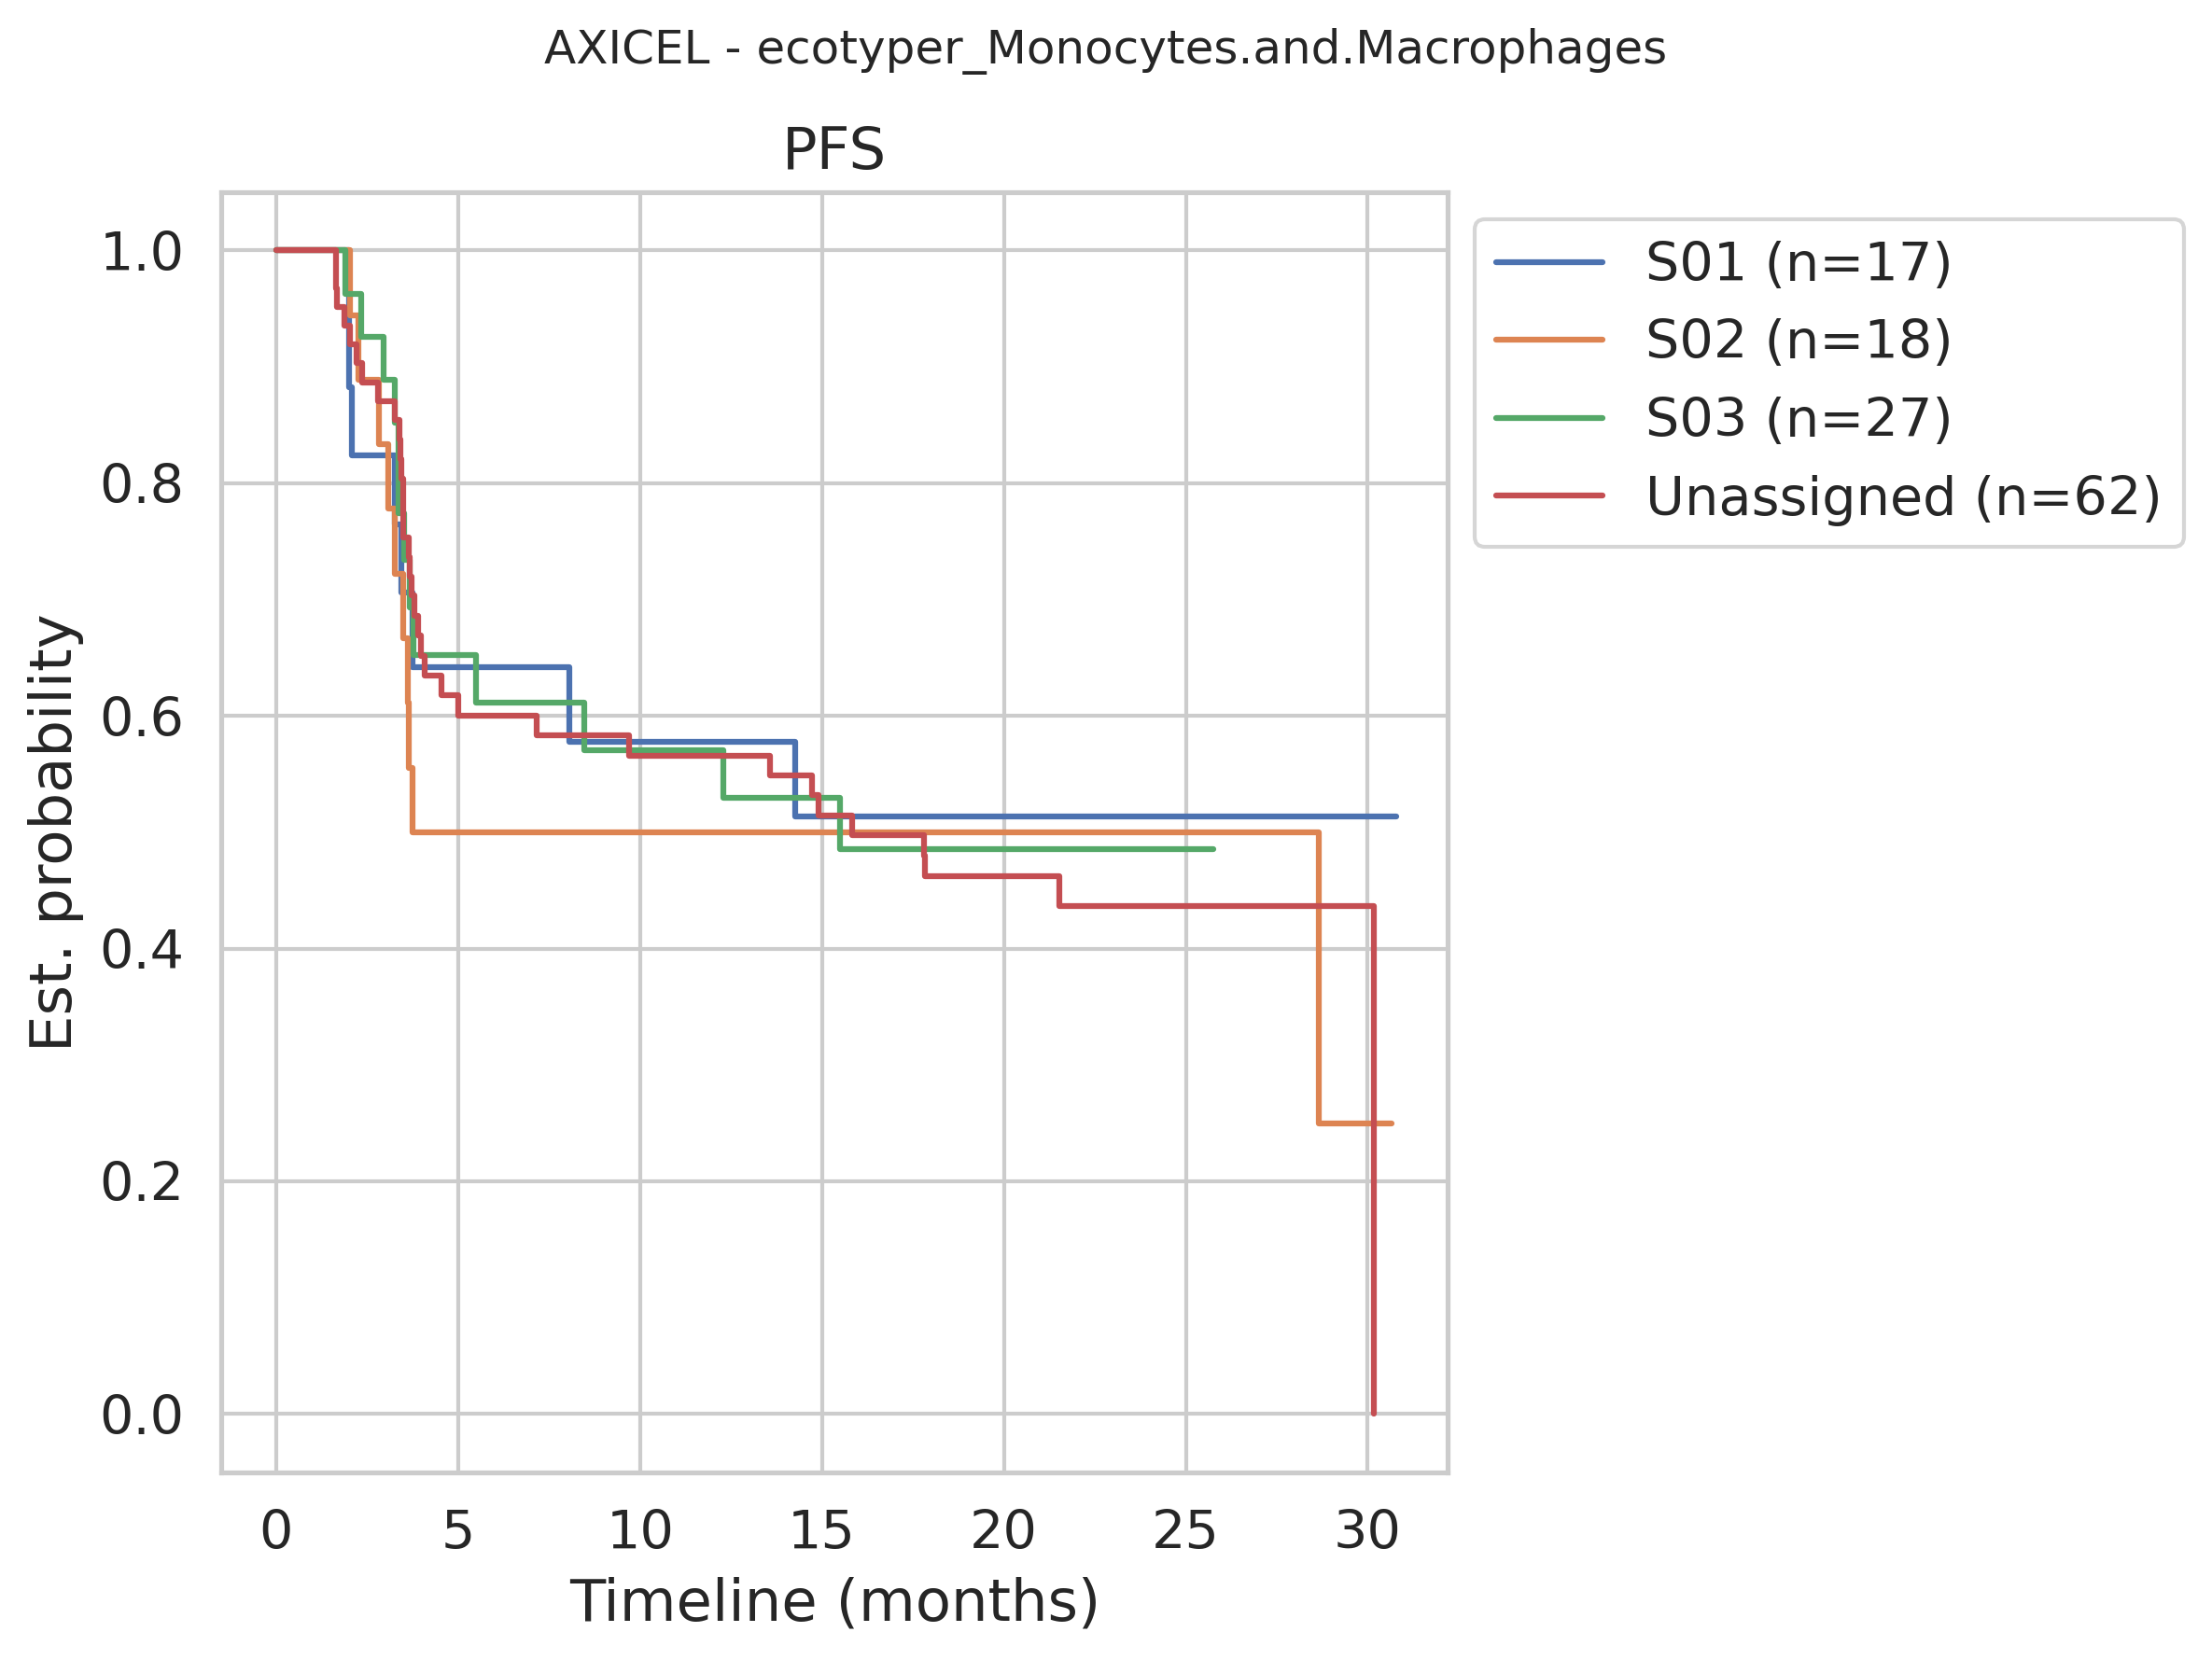

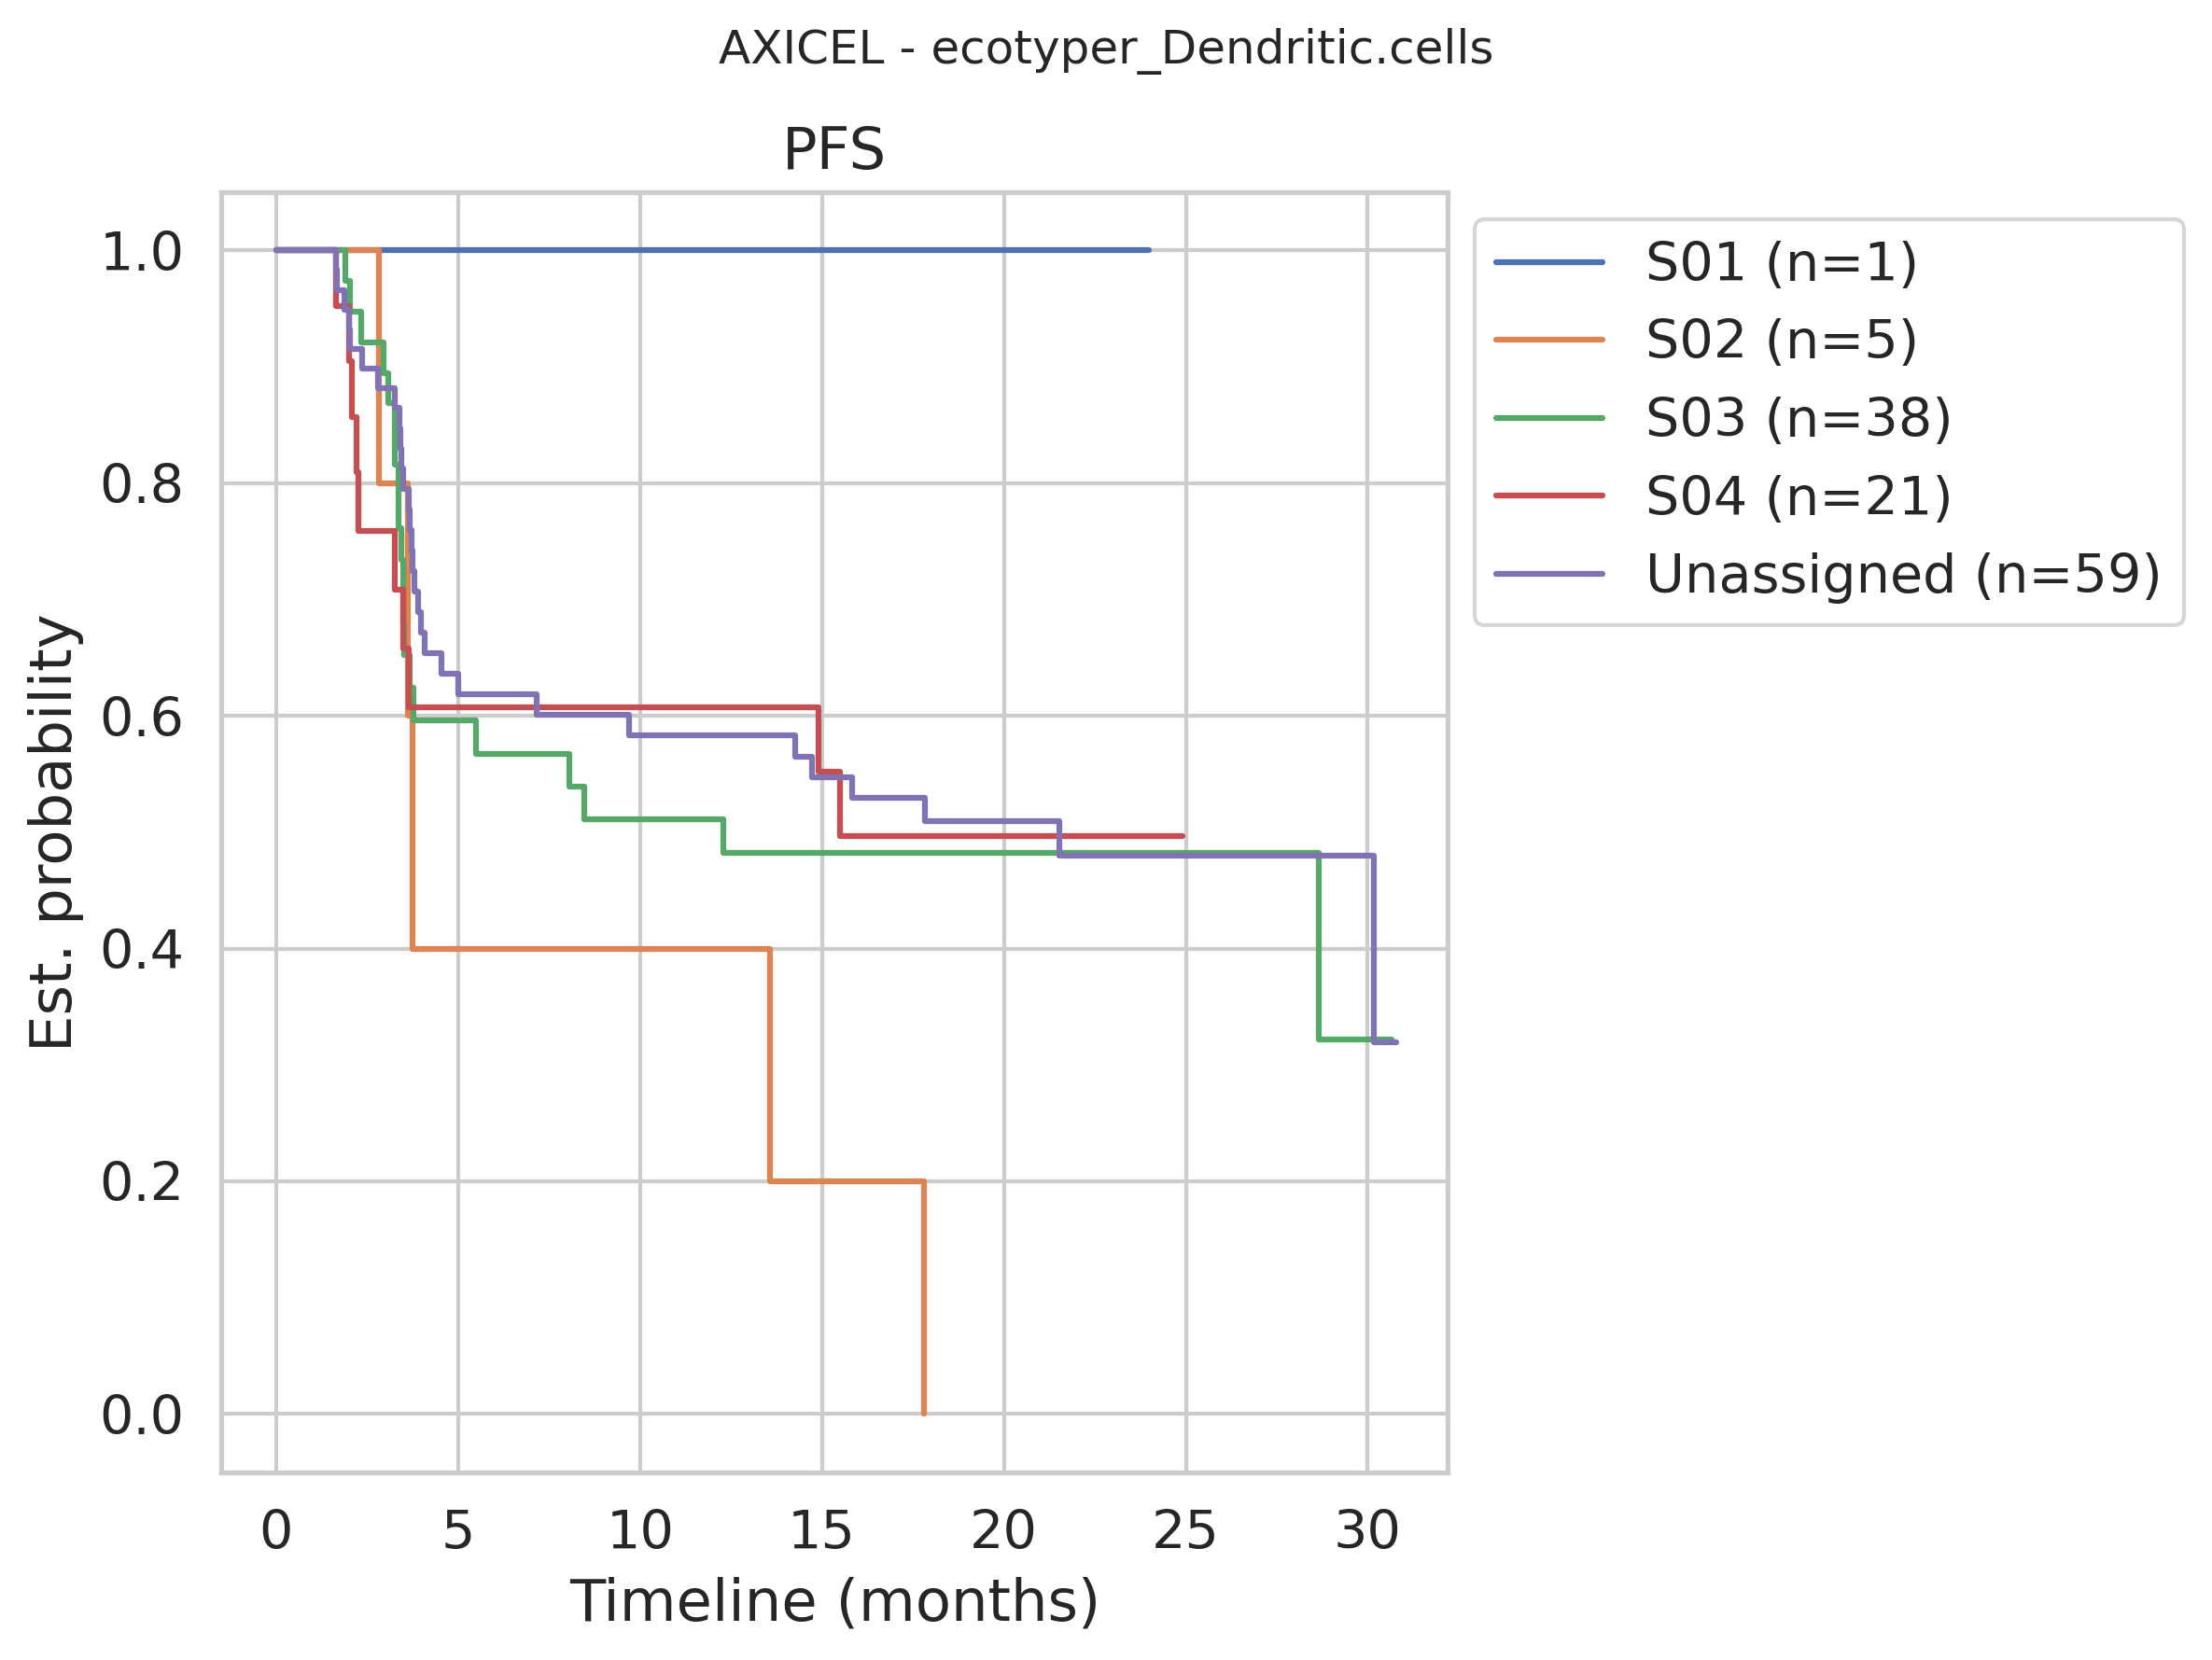

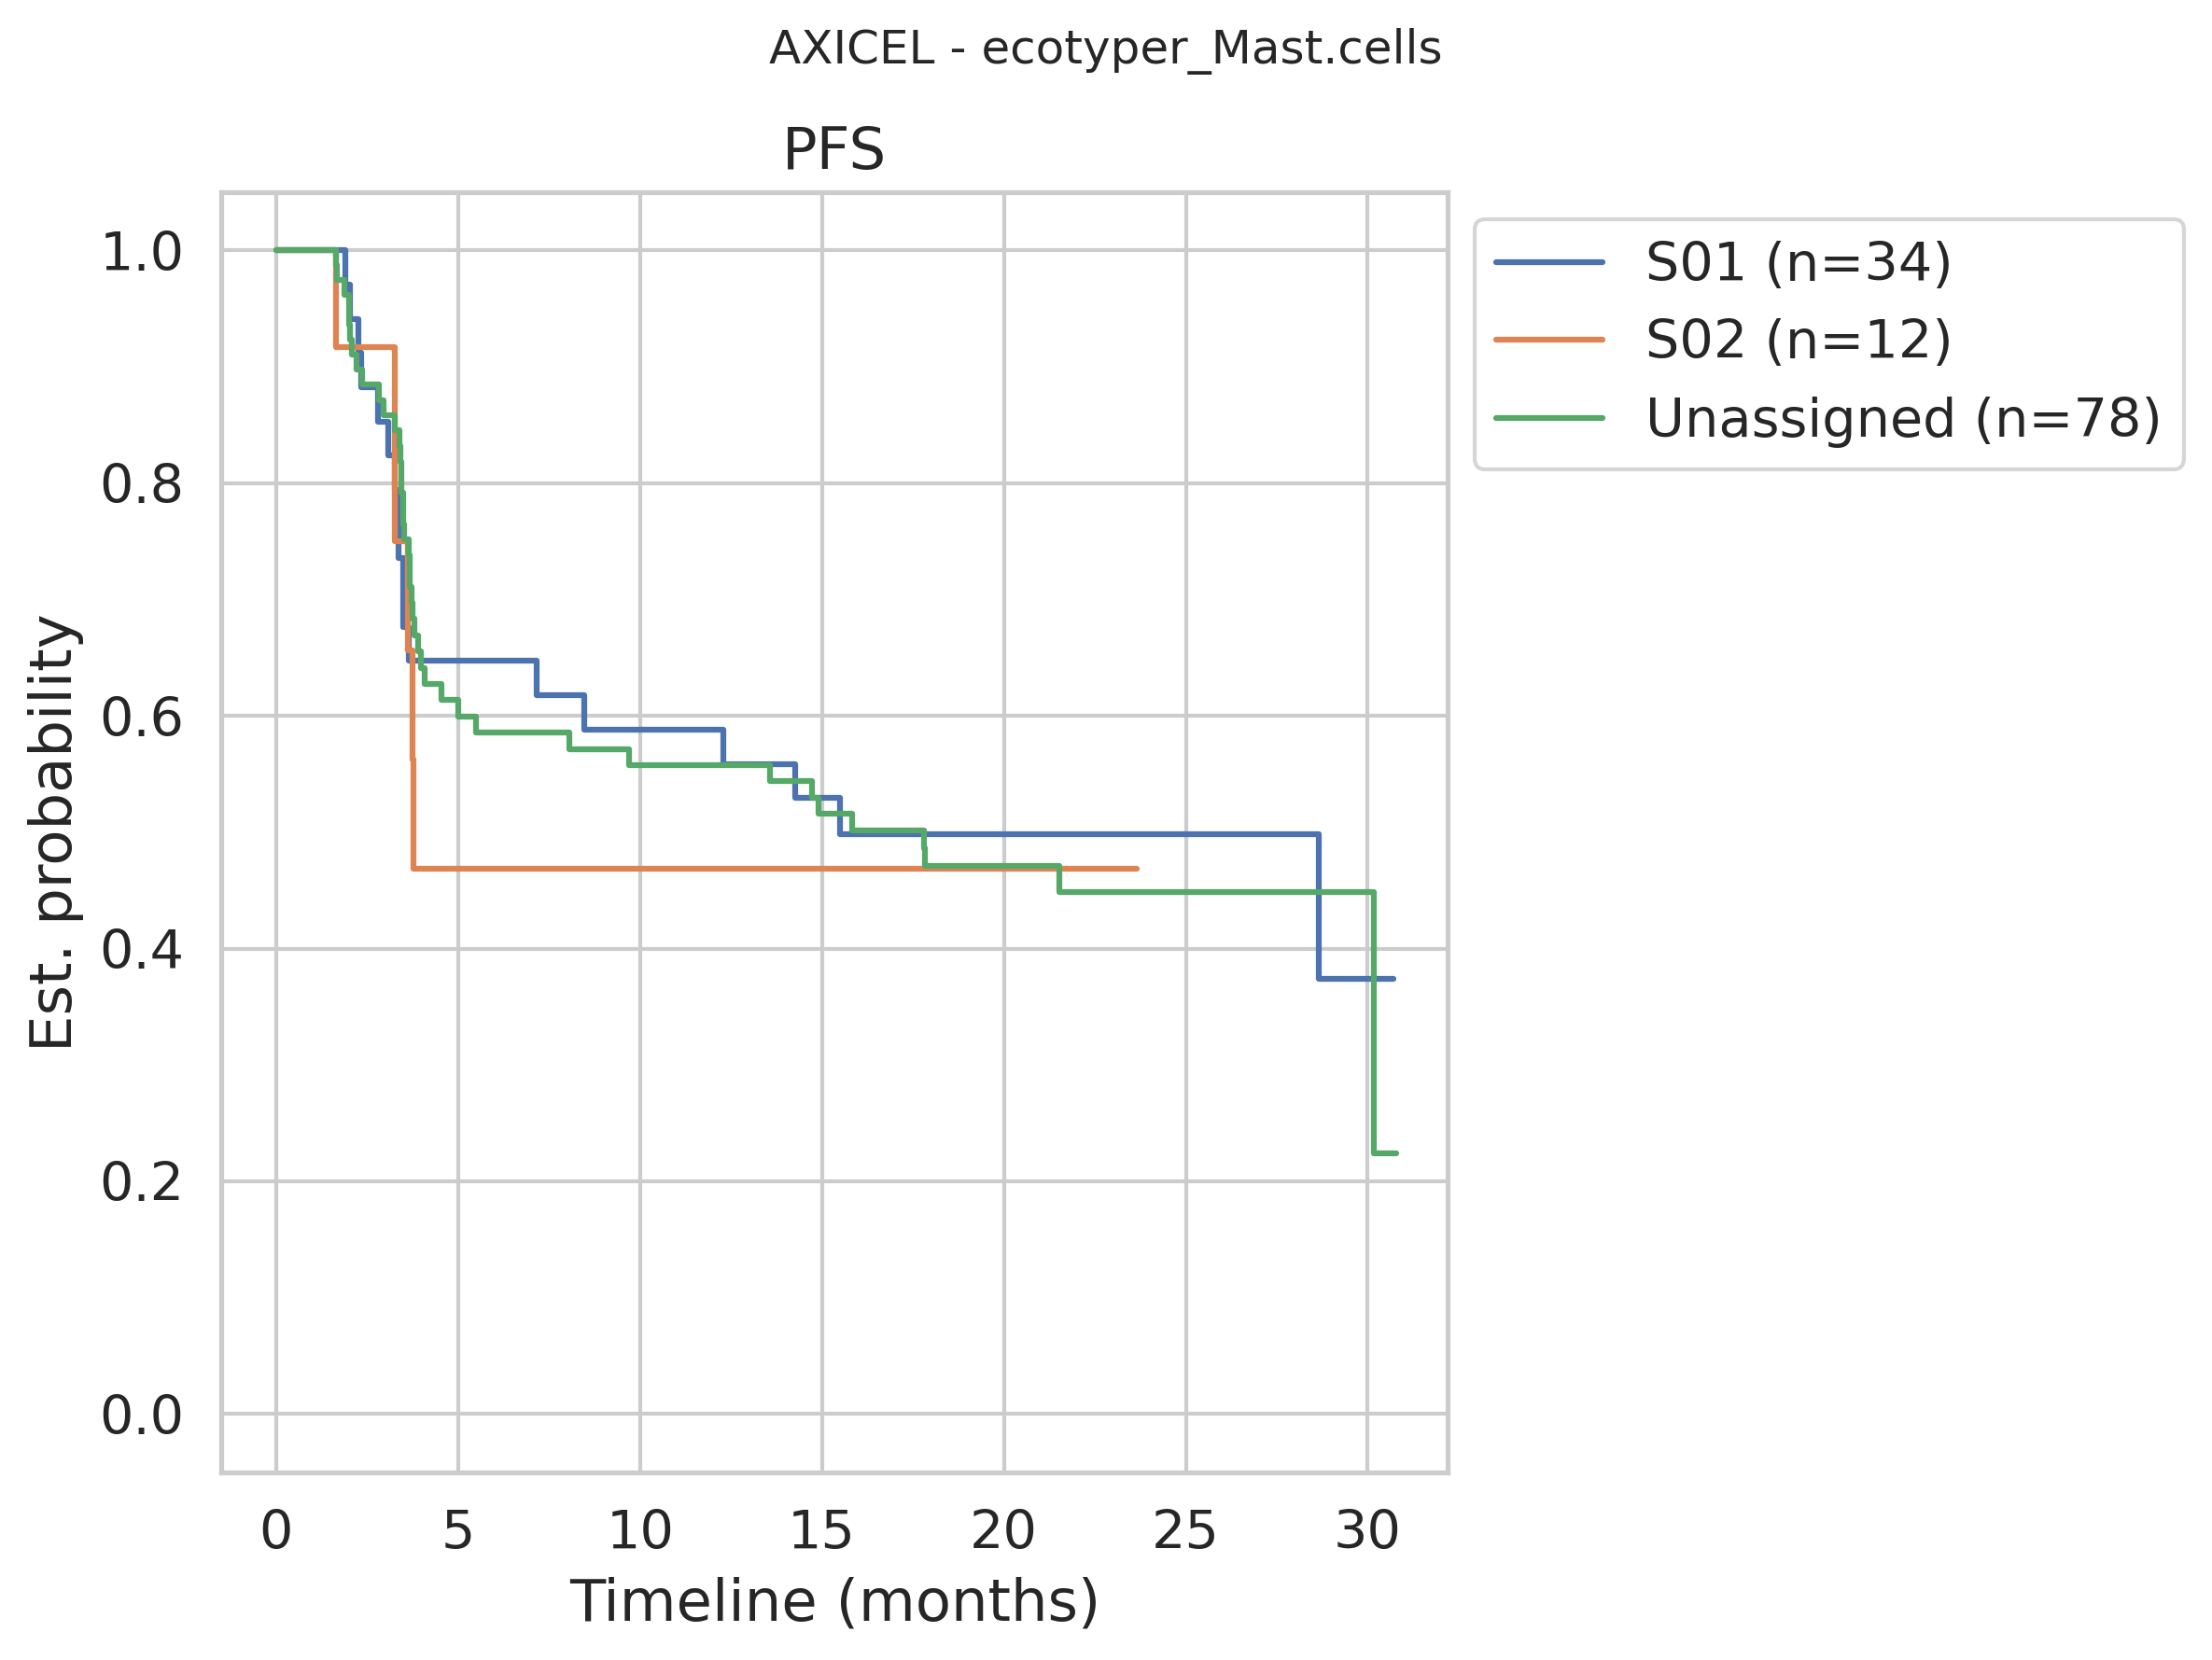

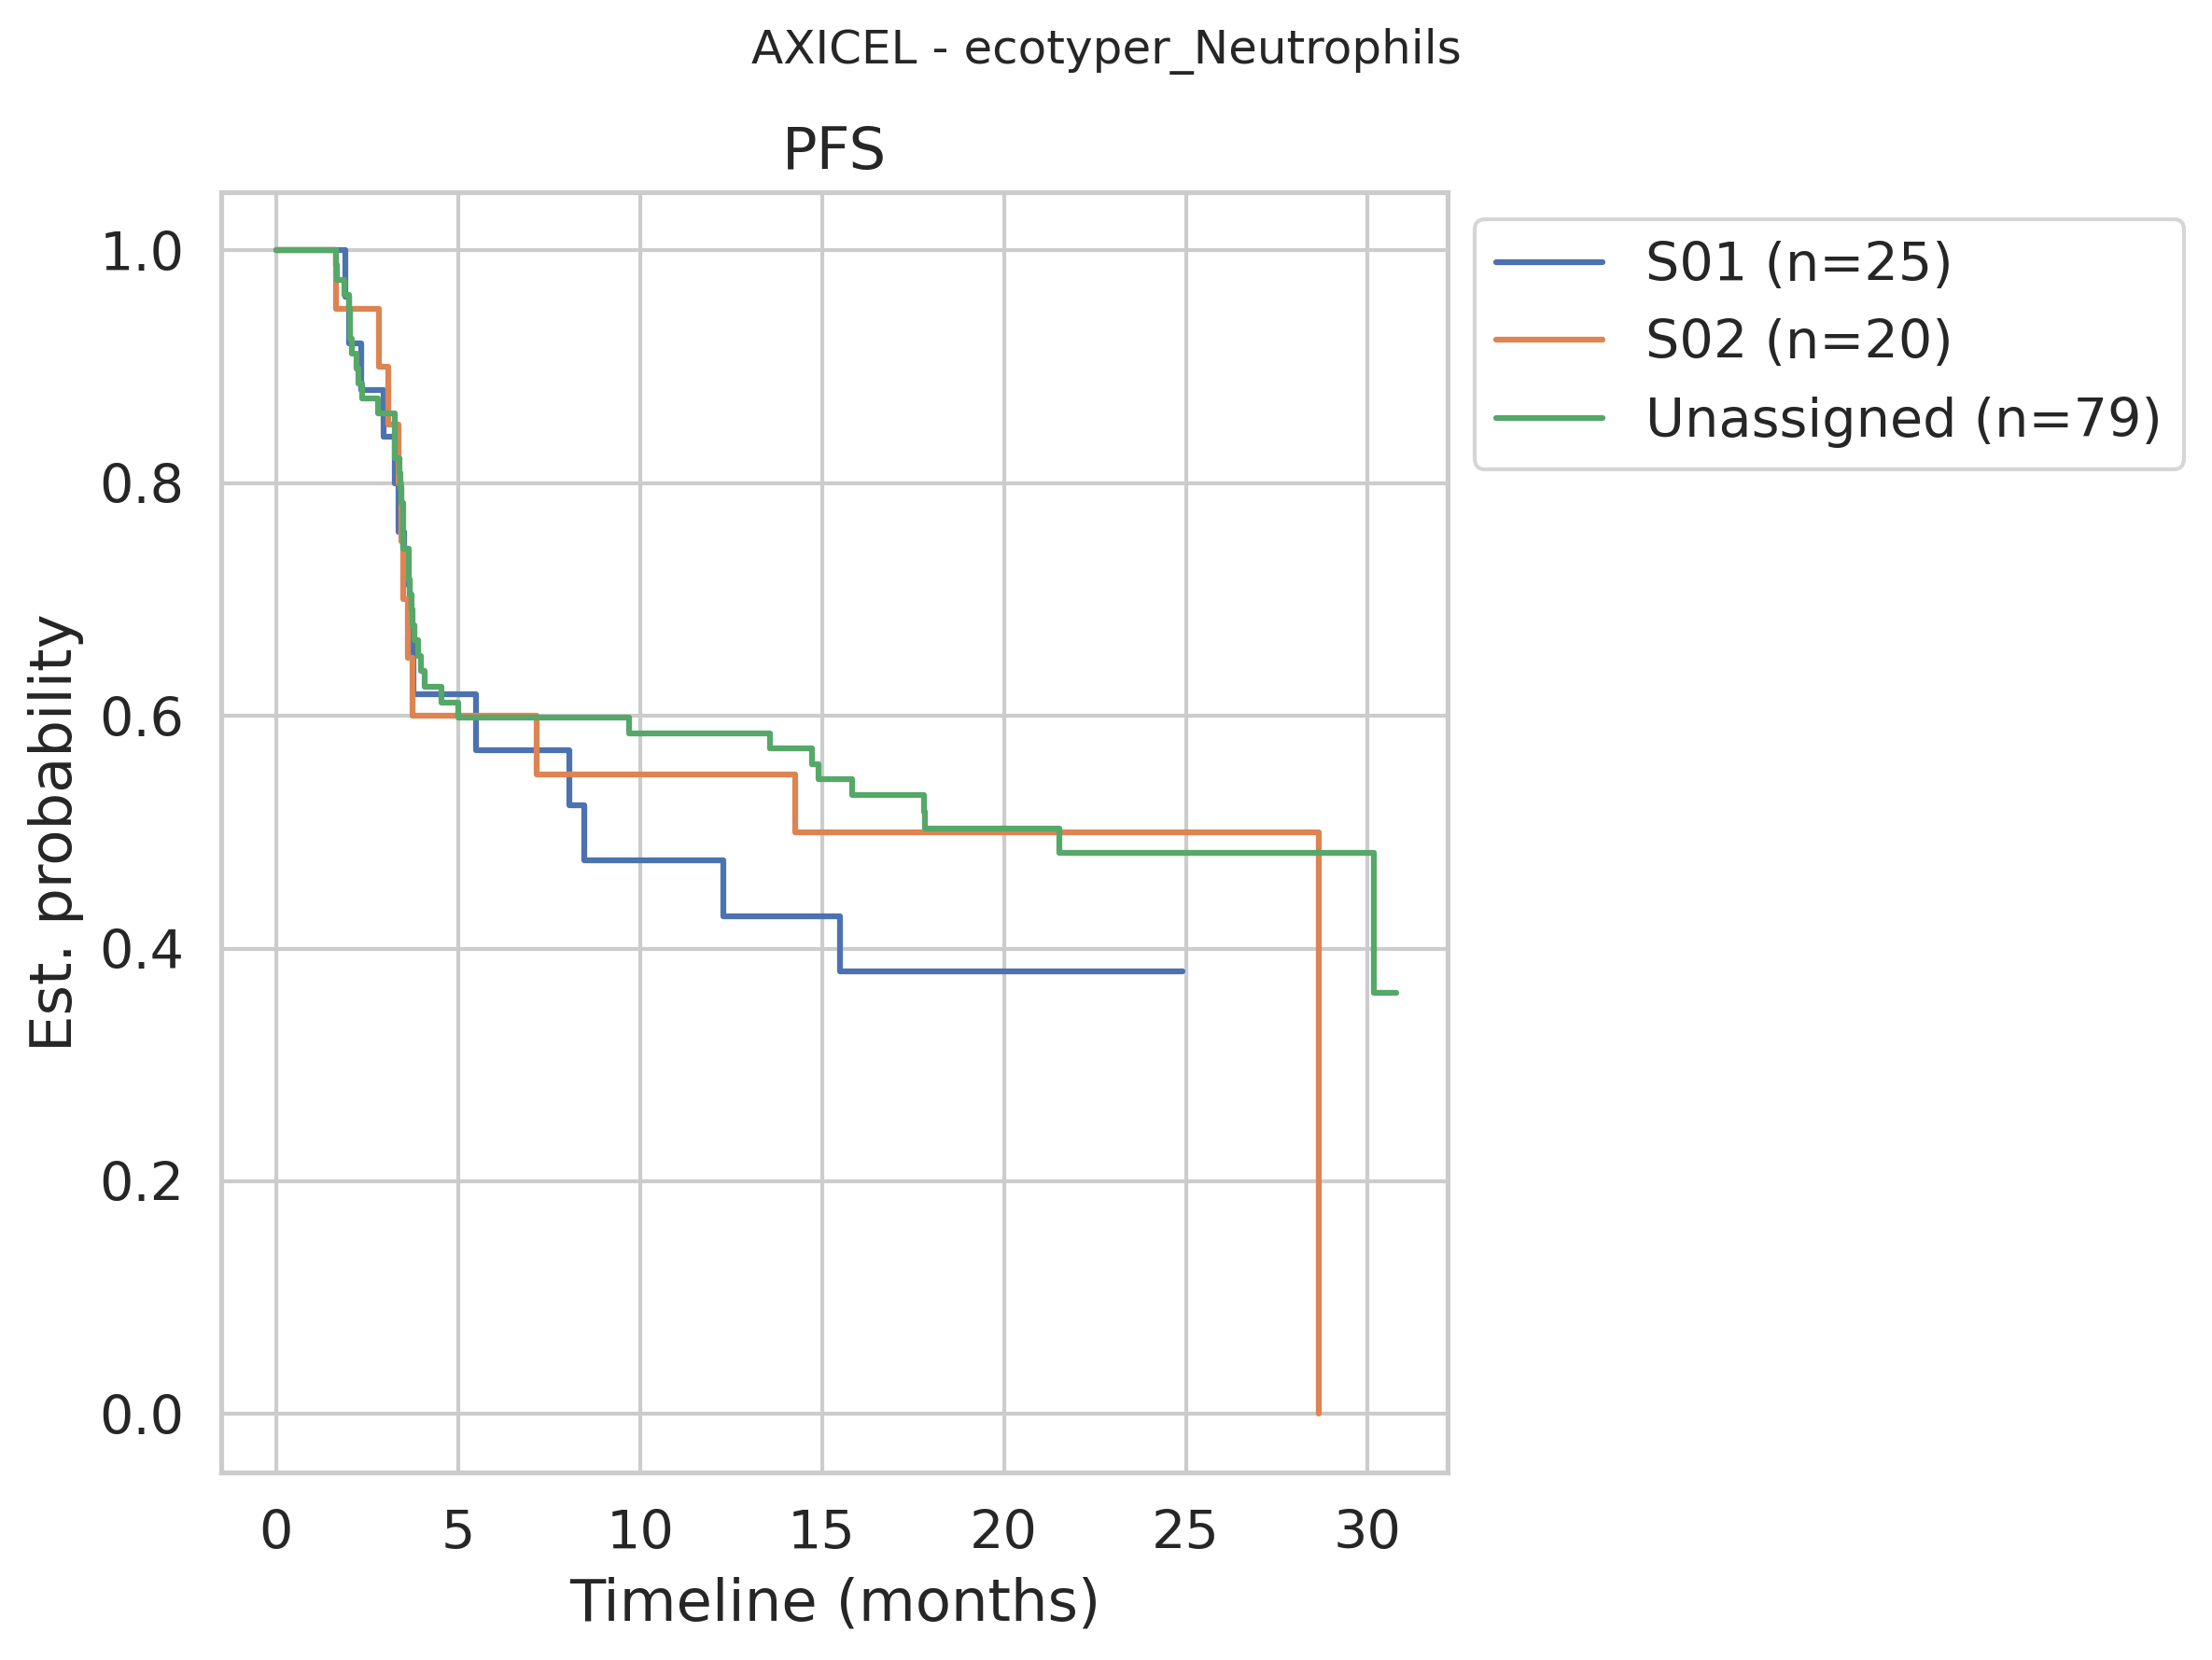

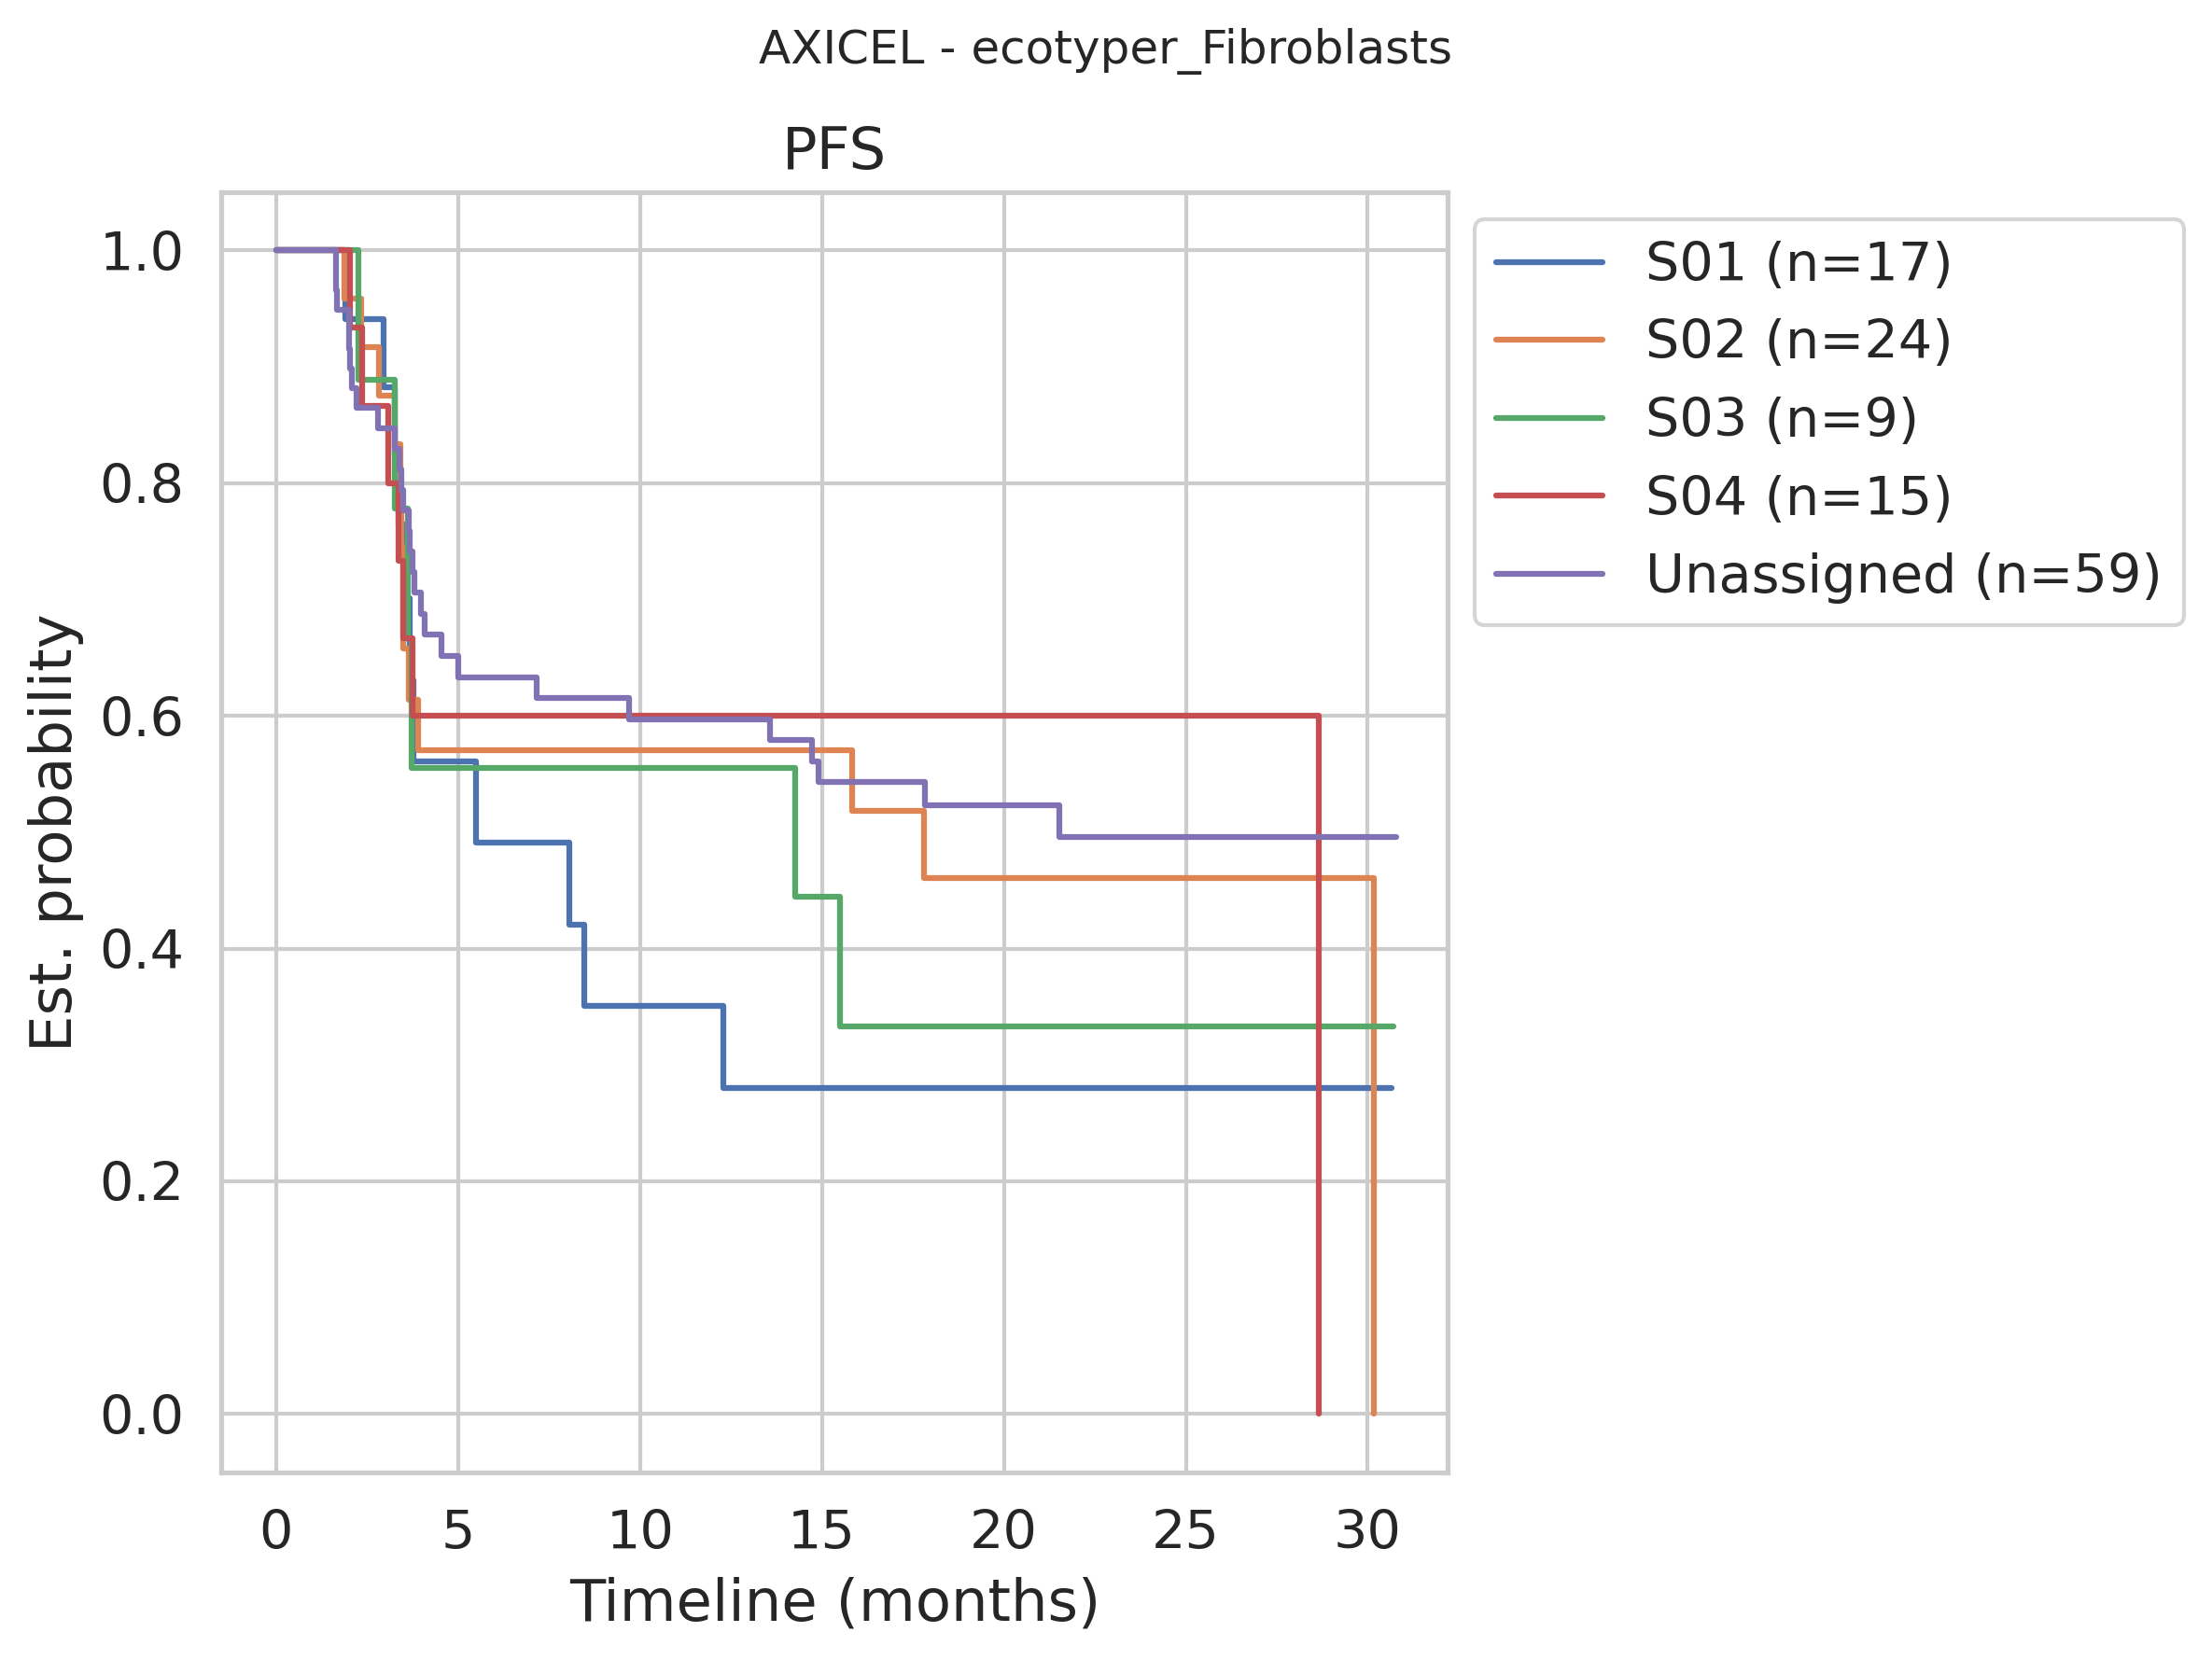

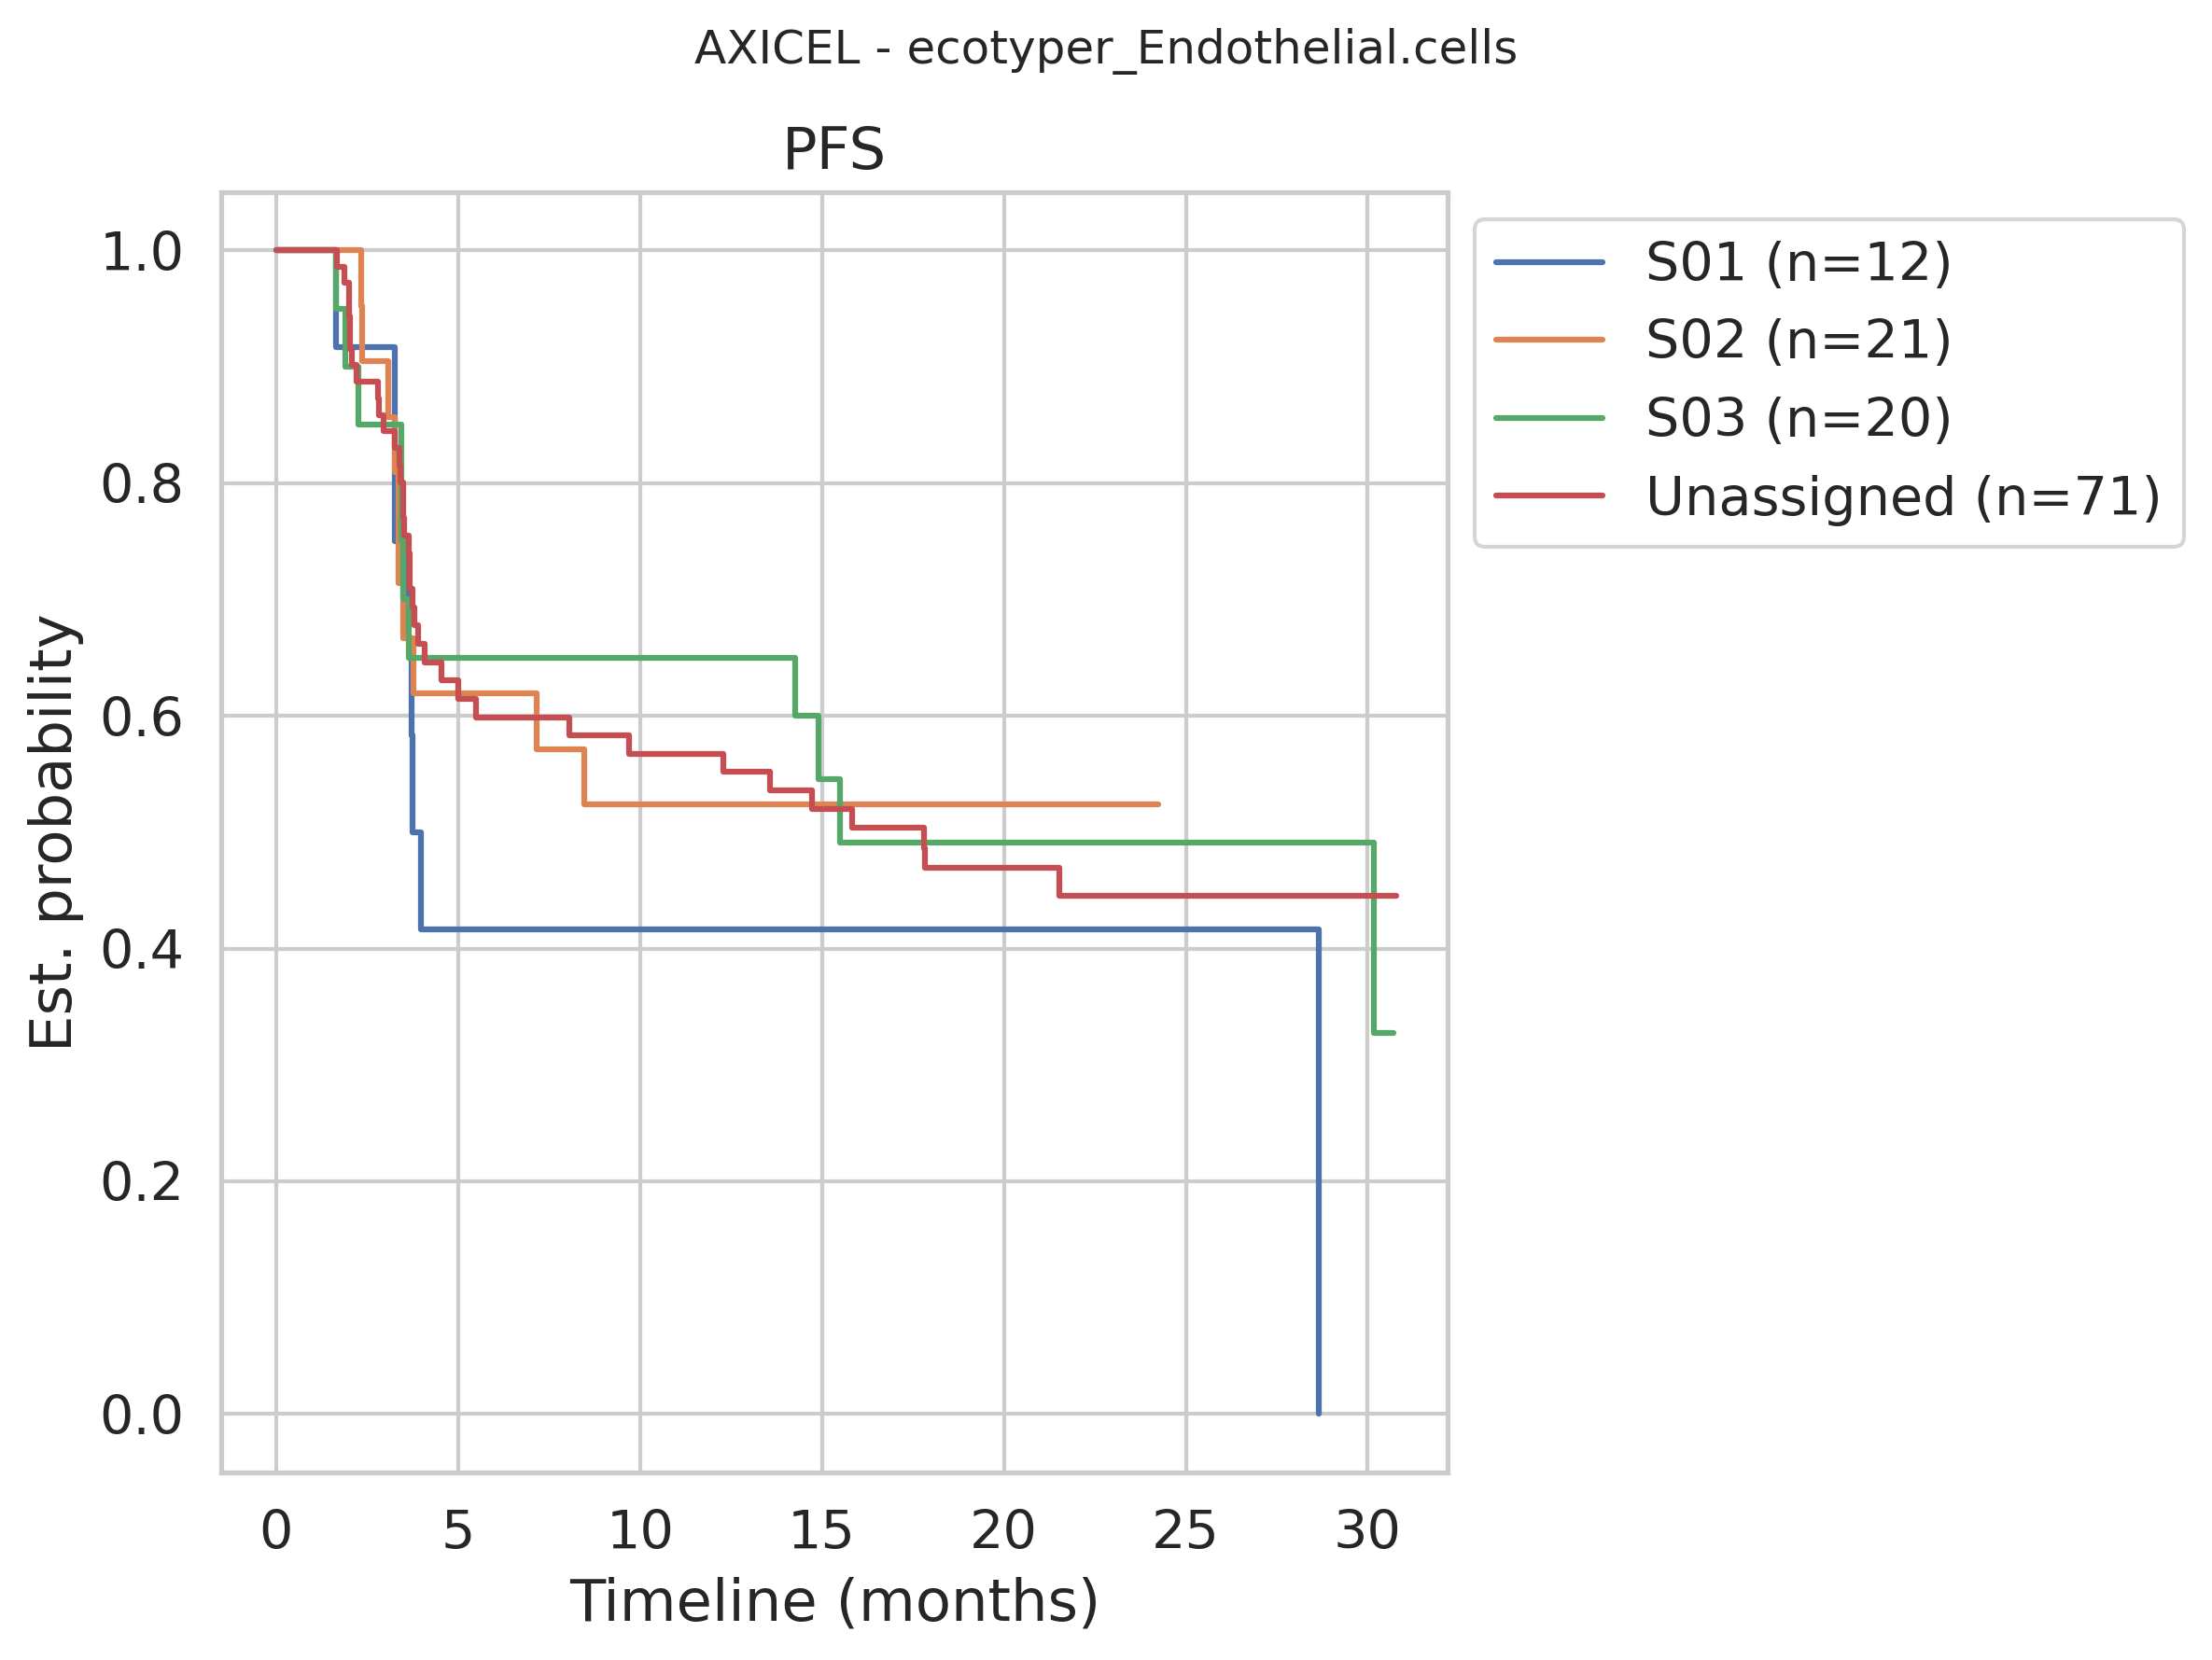

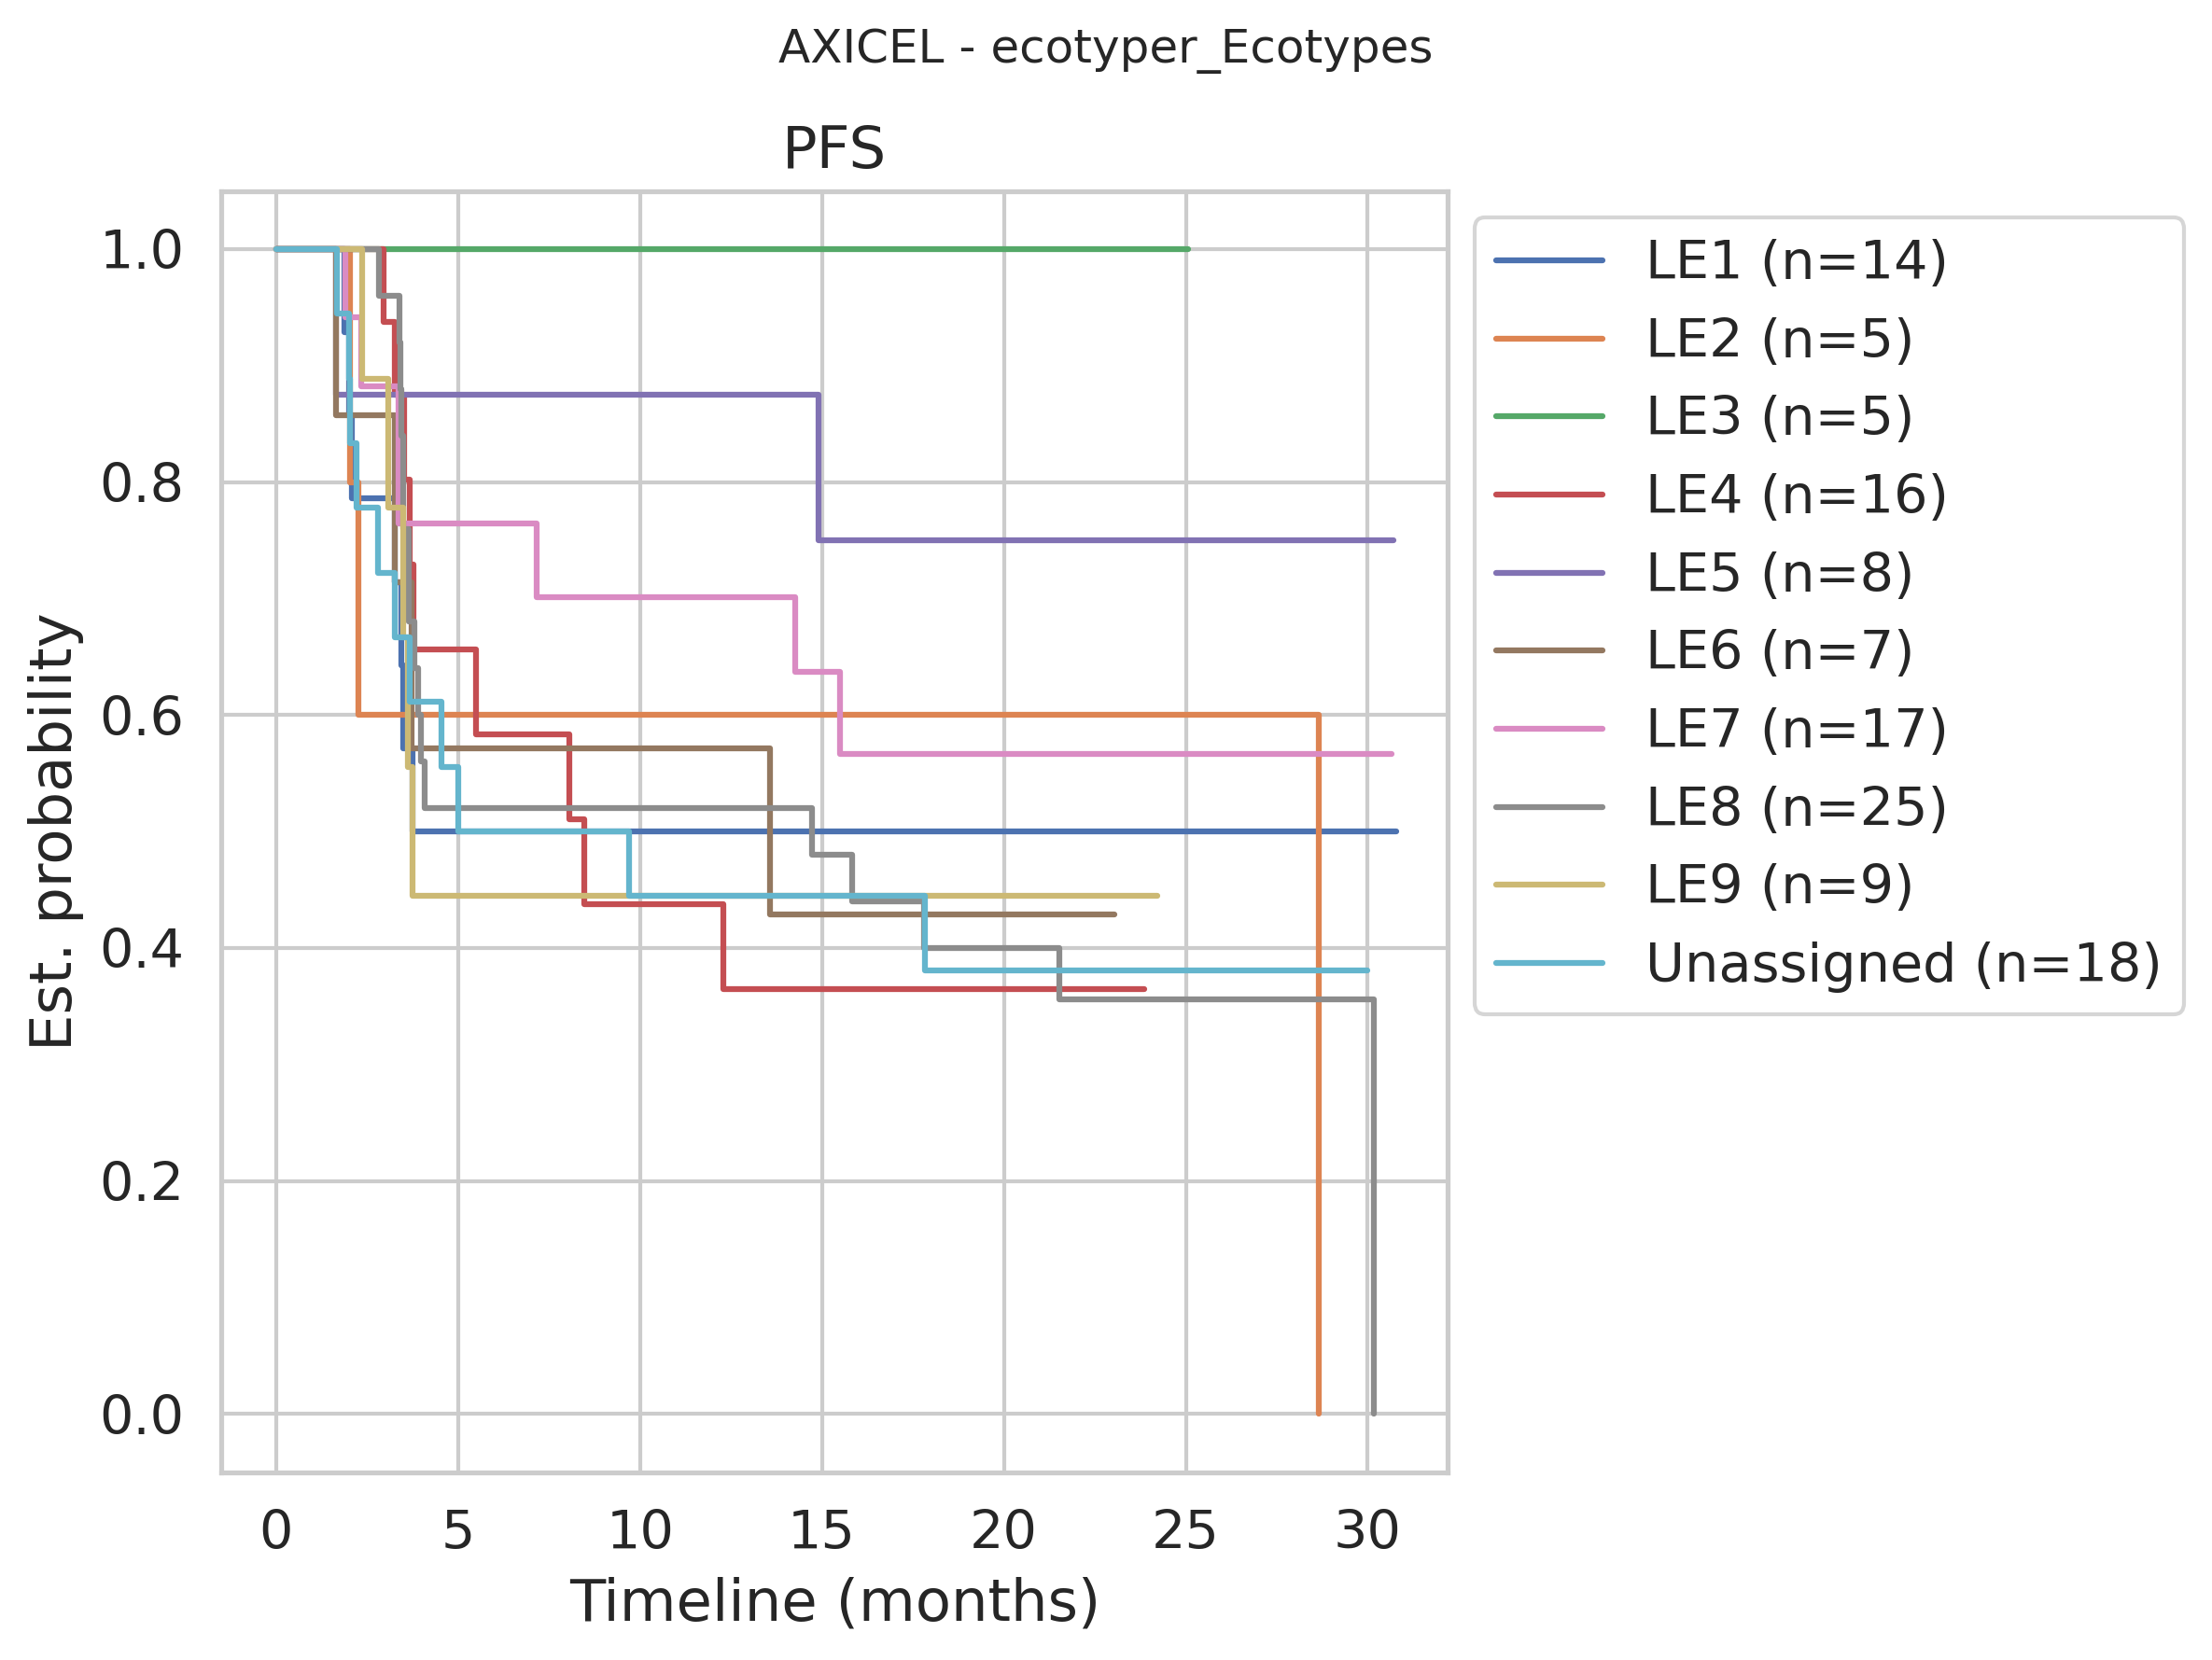

In [9]:
for d in ecotyper_results:
    plot_survival_ecotyper(response, ["PFS"], "AXICEL", f"ecotyper_{d.name}",
                           xlim=(-1.5, 32.2), ylim=(-0.05, 1.05))

In [10]:
axicel_ecotypes_count = response.loc[response["Actual Arm Code"] == "AXICEL"]["ecotyper_Ecotypes_group"].value_counts()
axicel_ecotypes_count = axicel_ecotypes_count.to_frame().sort_index()
axicel_ecotypes_count.columns = ["Count"]
axicel_ecotypes_count["Percentage (%)"] = round(axicel_ecotypes_count["Count"] / axicel_ecotypes_count["Count"].sum() * 100, 2)
axicel_ecotypes_count

,Count,Percentage (%)
LE1,14,11.29
LE2,5,4.03
LE3,5,4.03
LE4,16,12.90
LE5,8,6.45
LE6,7,5.65
LE7,17,13.71
LE8,25,20.16
LE9,9,7.26
Unassigned,18,14.52


In [11]:
axicel_ecotypes_count["Count"].sum()

124

In [12]:
# group Nonresponders and Relapsed as Other
response["Ongoing Response"] = response["Ongoing Response Per Central Assessment"].map(
    lambda r: "Other" if r in ("Nonresponders", "Relapsed") else r
)

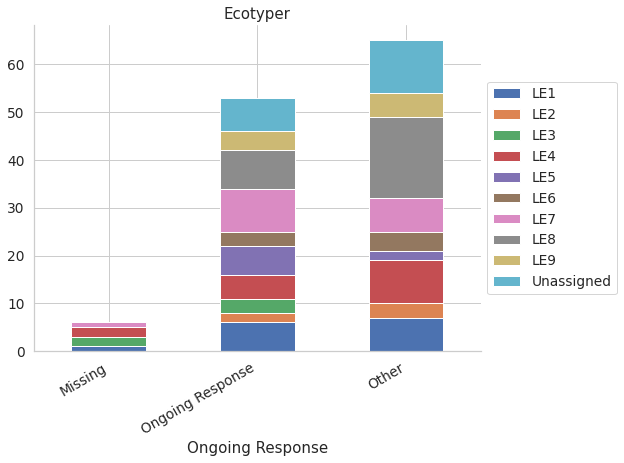

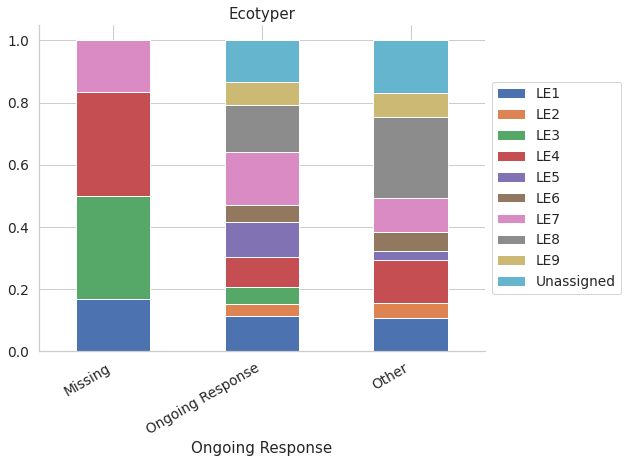

In [13]:
# plot the composition of each state or ecotype for each arm as a stacked bar plot
resposne_axicel = response.loc[response["Actual Arm Code"]=="AXICEL", :]
plot_abundance(resposne_axicel, "Ongoing Response", f"ecotyper_Ecotypes_group", normalize=False)
plot_abundance(resposne_axicel, "Ongoing Response", f"ecotyper_Ecotypes_group")

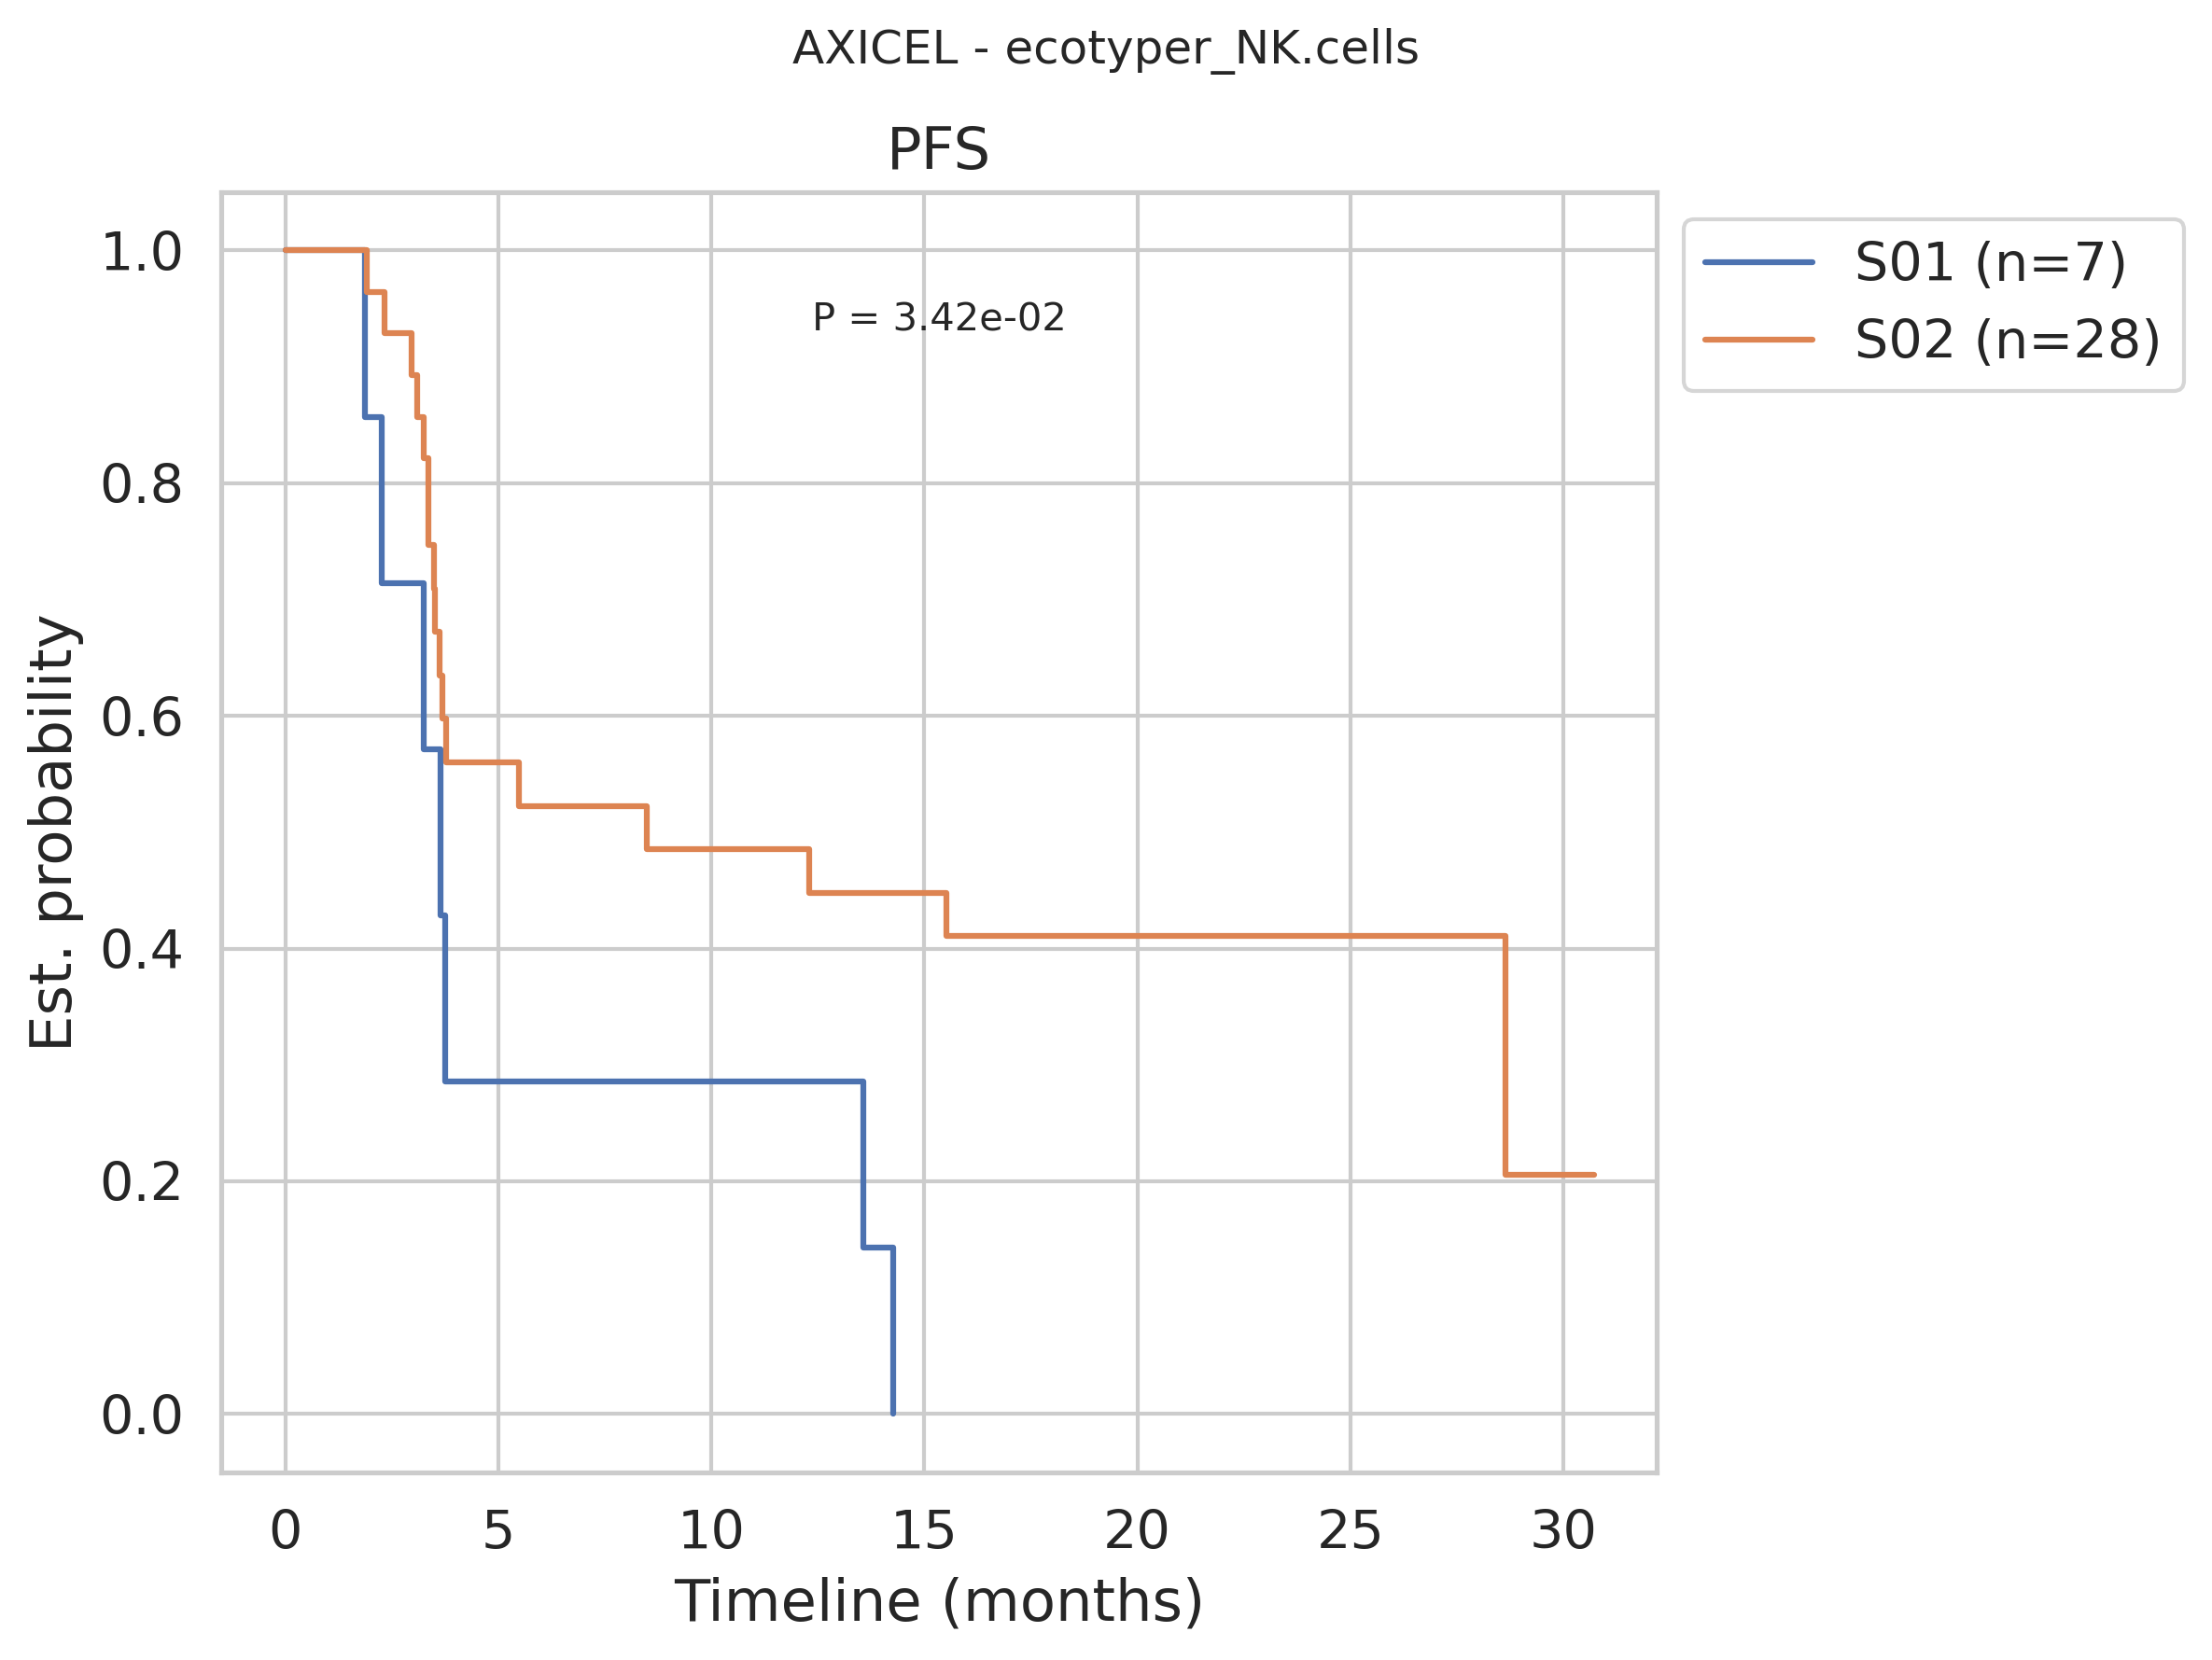

In [14]:
# NK S01 vs S02
plot_survival_ecotyper(response.loc[response["ecotyper_NK.cells_group"].isin(["S01", "S02"])],
                       ["PFS"], "AXICEL", "ecotyper_NK.cells", show_p=True,
                       xlim=(-1.5, 32.2), ylim=(-0.05, 1.05))

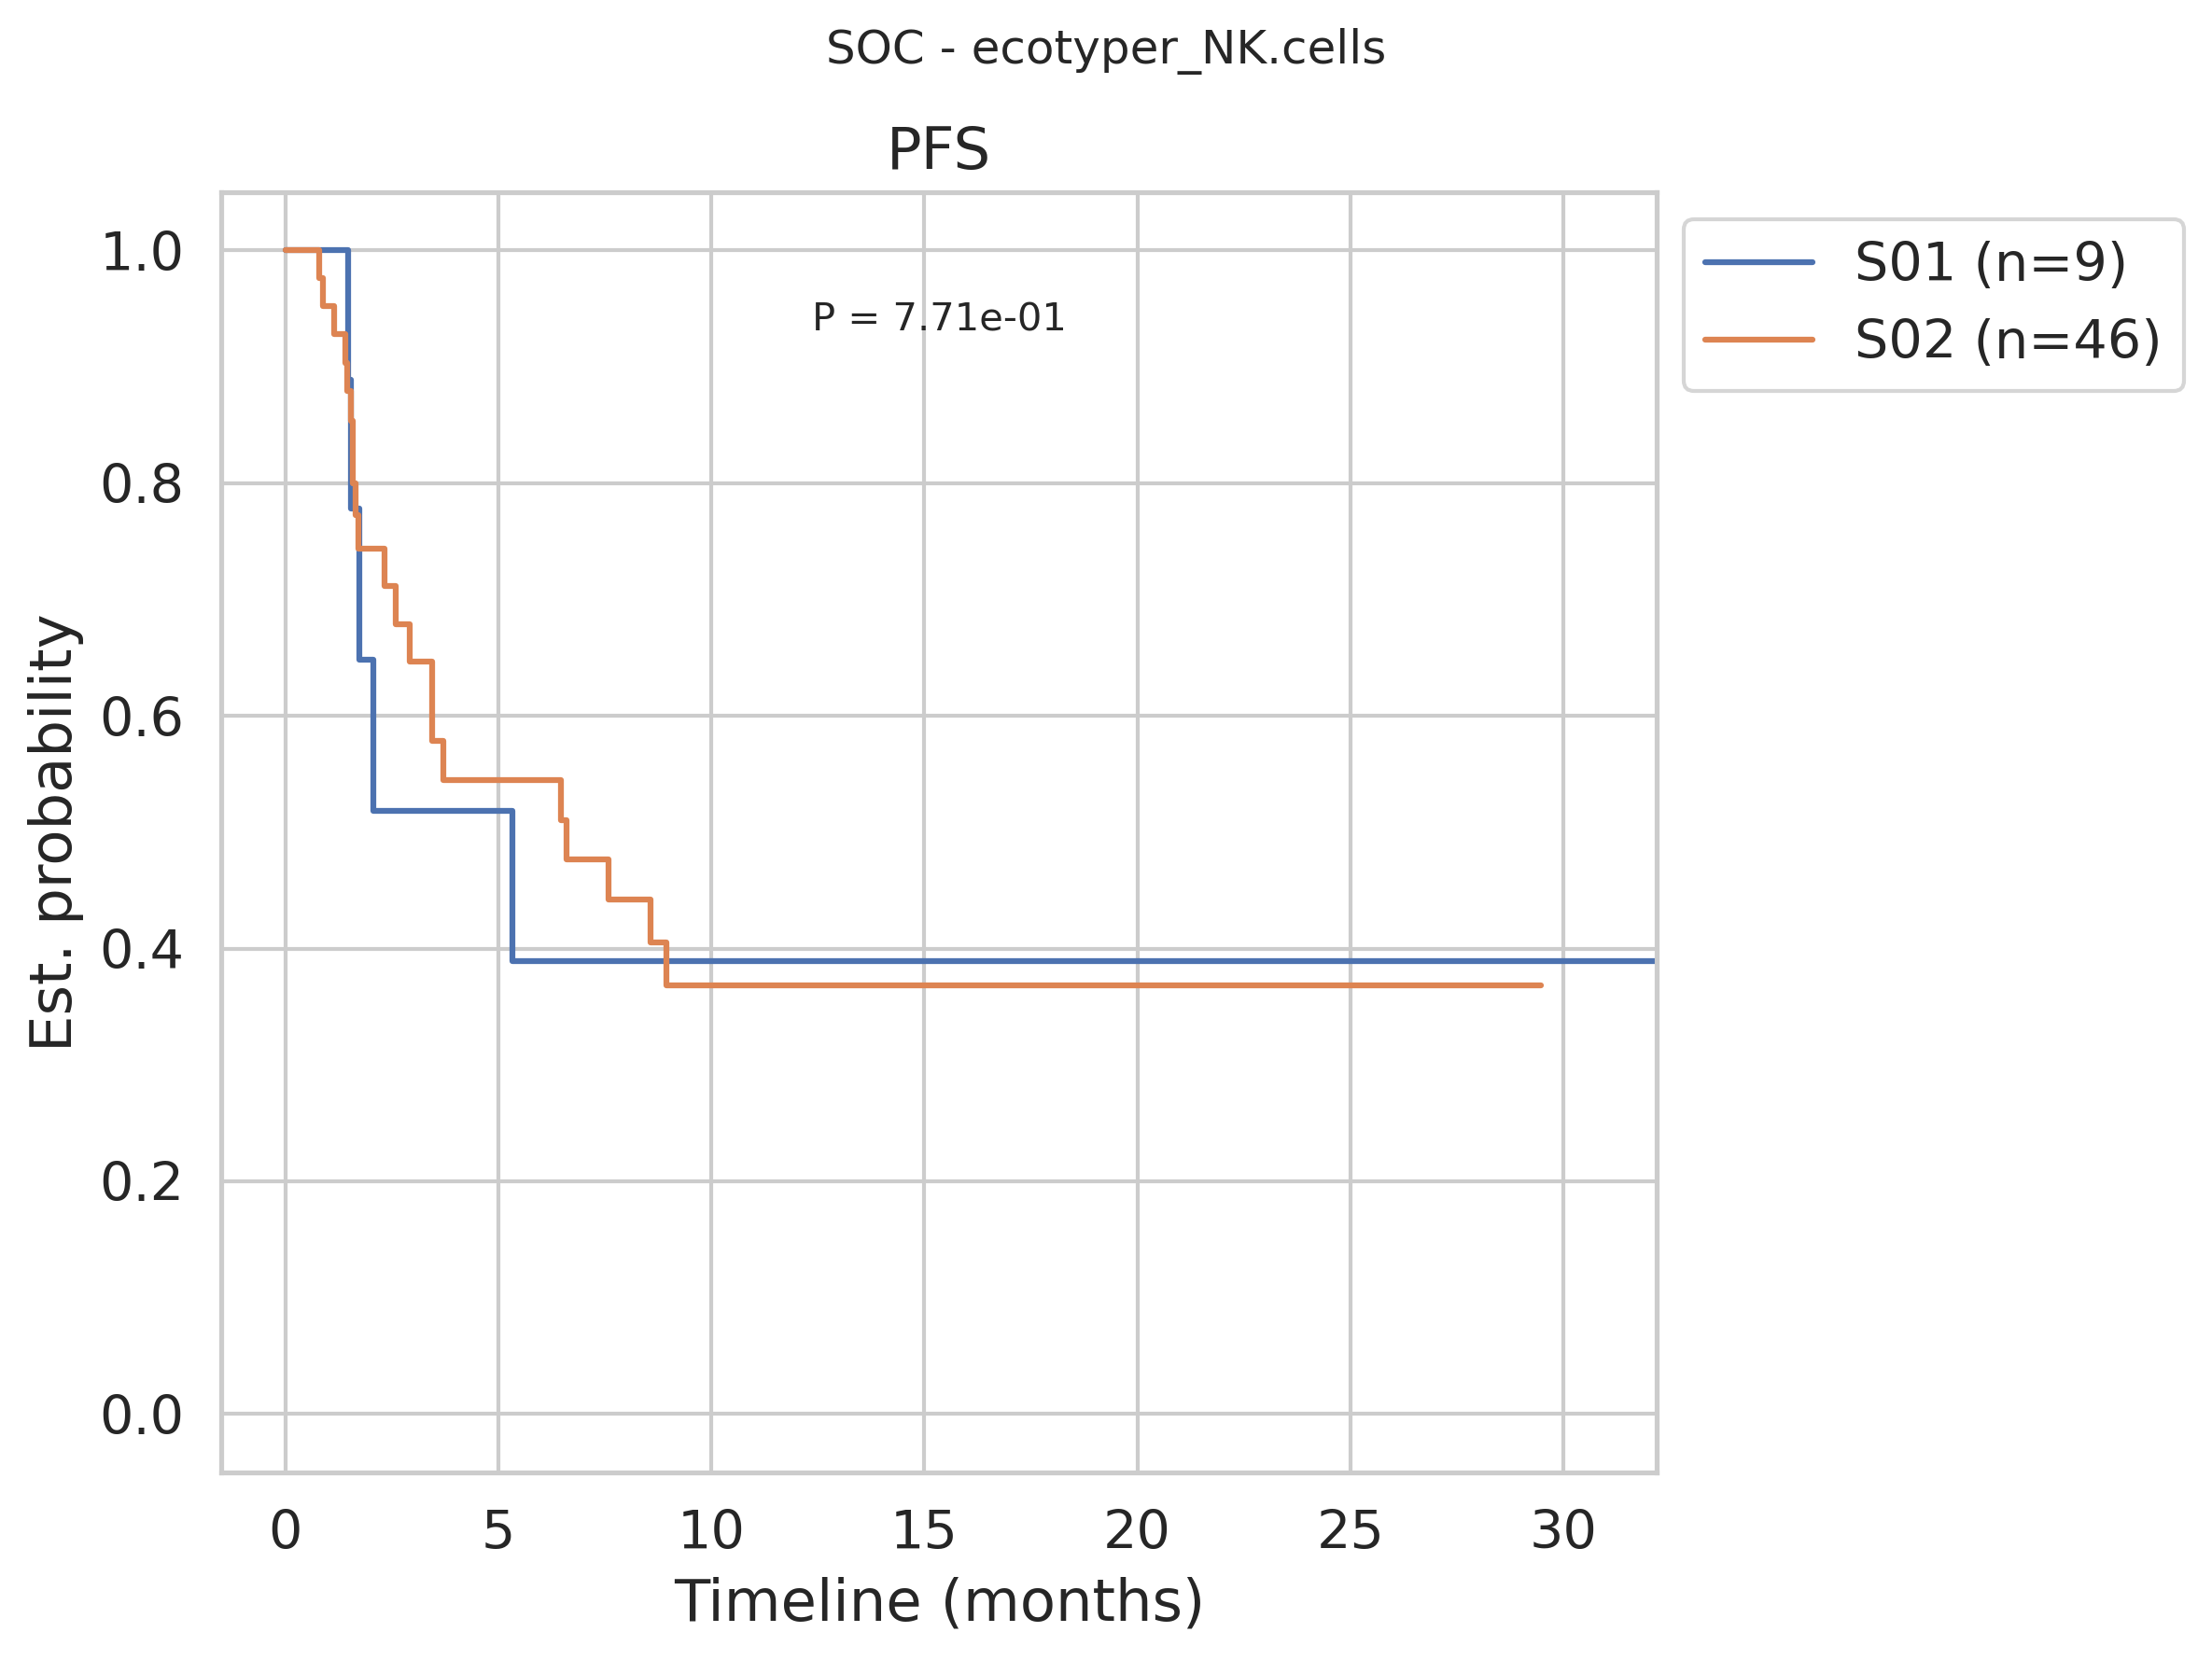

In [23]:
# NK S01 vs S02
plot_survival_ecotyper(response.loc[response["ecotyper_NK.cells_group"].isin(["S01", "S02"])],
                       ["PFS"], "SOC", "ecotyper_NK.cells", show_p=True,
                       xlim=(-1.5, 32.2), ylim=(-0.05, 1.05))

In [15]:
# granulator results with nnls_ABIS_S0
granulator_res = pd.read_csv(data_path/"granulator_outs/zuma7/nnls_ABIS_S0.csv", index_col=0)
granulator_res.head()

,B.Memory,B.Naive,Basophils.LD,MAIT,mDCs,Monocytes.C,Monocytes.NC.I,Neutrophils.LD,NK,pDCs,Plasmablasts,T.CD4.Memory,T.CD4.Naive,T.CD8.Memory,T.CD8.Naive,T.gd.non.Vd2,T.gd.Vd2
SM201_001,10.34,6.90,0.00,1.72,0.00,0.00,1.72,13.79,0,1.72,0.0,3.45,1.72,3.45,0.00,0.0,0.0
SM201_003,18.97,1.72,0.00,1.72,0.00,0.00,1.72,3.45,0,0.00,0.0,3.45,3.45,1.72,0.00,0.0,0.0
SM201_004,17.24,12.07,0.00,1.72,1.72,0.00,1.72,1.72,0,0.00,0.0,10.34,3.45,0.00,1.72,0.0,0.0
SM201_005,1.72,0.00,1.72,1.72,1.72,3.45,3.45,5.17,0,1.72,0.0,8.62,0.00,3.45,0.00,0.0,0.0
SM201_006,5.17,3.45,0.00,1.72,0.00,0.00,1.72,3.45,0,1.72,0.0,0.00,1.72,1.72,0.00,0.0,0.0


<Axes: ylabel='Frequency'>

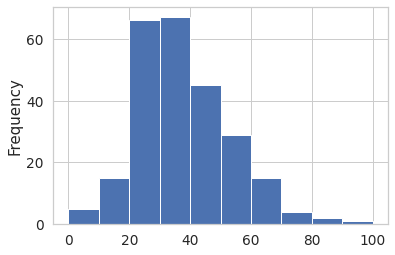

In [16]:
granulator_res.sum(axis=1).plot.hist()

In [17]:
# inplace "_" with "-" in the index
granulator_res.index = granulator_res.index.map(lambda x: x.replace("_", "-"))

# add granulator_ to the columns
granulator_res.columns = granulator_res.columns.map(lambda x: "granulator_" + x)

# add the assignment to the response
response = response.join(granulator_res)
response.head()

,Core ID,LV8 Molecular Batch ID,Subject ID_old,Collection Date_old,Site ID_old,Visit_old,Treatment_Arm_01,Randomization_Date,Treatment_Start_Date 01,HDT_Date_01,...,granulator_Neutrophils.LD,granulator_NK,granulator_pDCs,granulator_Plasmablasts,granulator_T.CD4.Memory,granulator_T.CD4.Naive,granulator_T.CD8.Memory,granulator_T.CD8.Naive,granulator_T.gd.non.Vd2,granulator_T.gd.Vd2
SM201-001,SM201-001,N1800110-KTP-00001,107-002-001,2017-08-08 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-25 00:00:00,2018-02-19 00:00:00,.,...,13.79,0,1.72,0.0,3.45,1.72,3.45,0.00,0.0,0.0
SM201-003,SM201-003,N1800110-KTP-00003,107-002-002,2017-04-13 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-31 00:00:00,2018-02-26 00:00:00,.,...,3.45,0,0.00,0.0,3.45,3.45,1.72,0.00,0.0,0.0
SM201-004,SM201-004,N1800110-KTP-00004,107-005-001,2017-08-14 00:00:00,5,Screening,Standard of Care Therapy,2018-02-09 00:00:00,2018-02-15 00:00:00,.,...,1.72,0,0.00,0.0,10.34,3.45,0.00,1.72,0.0,0.0
SM201-005,SM201-005,N1800110-KTP-00005,107-031-001,2018-04-03 00:00:00,31,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-04-04 00:00:00,2018-06-13 00:00:00,...,5.17,0,1.72,0.0,8.62,0.00,3.45,0.00,0.0,0.0
SM201-006,SM201-006,N1800110-KTP-00006,107-019-002,2018-03-30 00:00:00,19,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-03-31 00:00:00,.,...,3.45,0,1.72,0.0,0.00,1.72,1.72,0.00,0.0,0.0


In [18]:
significant_celltypes = defaultdict(list)

# significant cell types
for cell_type in granulator_res.columns:
    group_by_col(response, arms, cell_type, f"{cell_type}_group")
        
    # calculate the logrank test
    for arm in arms:
        tmp = response.loc[response["Actual Arm Code"] == arm].copy()
        # only consider PFS
        tmp.dropna(subset=["PFS time", "PFS event"], inplace=True)
        col = f"{cell_type}_group"
        ts = []
        es = []
        for name, g in tmp.groupby(col):
            t = g["PFS time"]
            e = g["PFS event"]
            ts.append(t)
            es.append(e)
            
        # calculate the logrank test
        res = logrank_test(ts[0], ts[1], event_observed_A=es[0],
                            event_observed_B=es[1])
        if res.p_value < 0.05:
            significant_celltypes[arm].append(cell_type)

In [19]:
significant_celltypes["AXICEL"]

['granulator_B.Memory', 'granulator_B.Naive', 'granulator_T.CD4.Naive']

In [20]:
significant_celltypes["SOC"]

[]

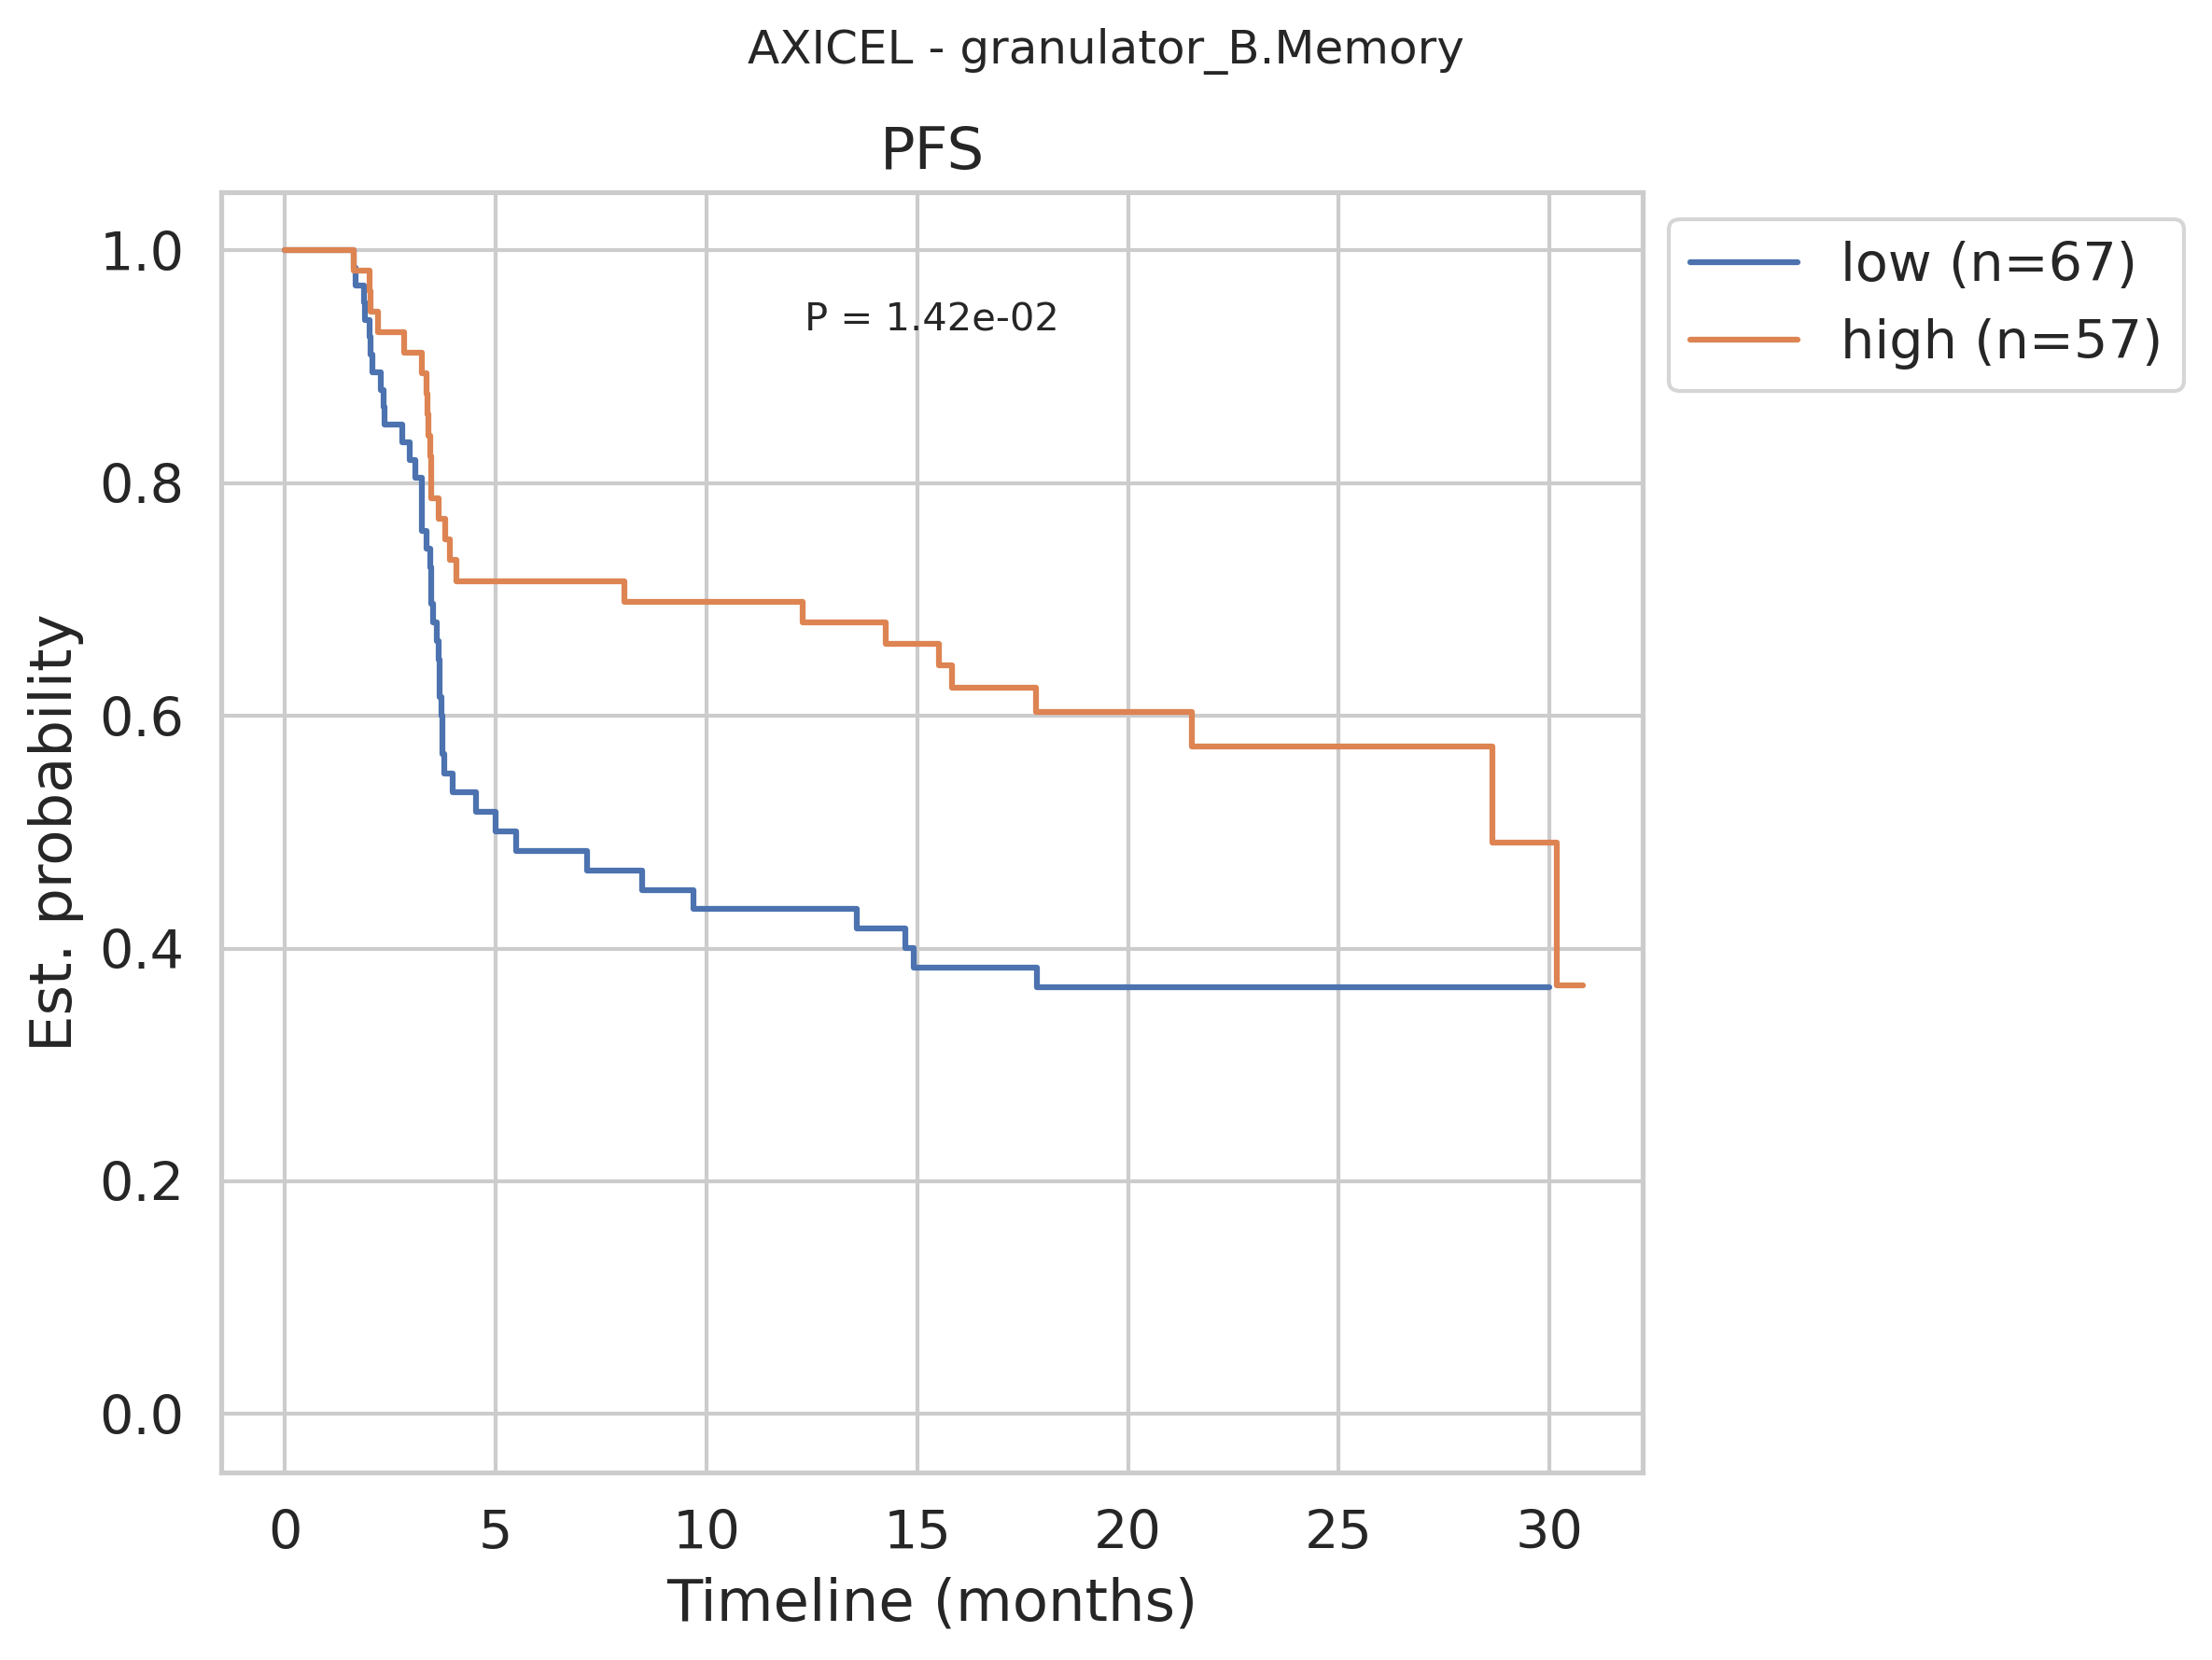

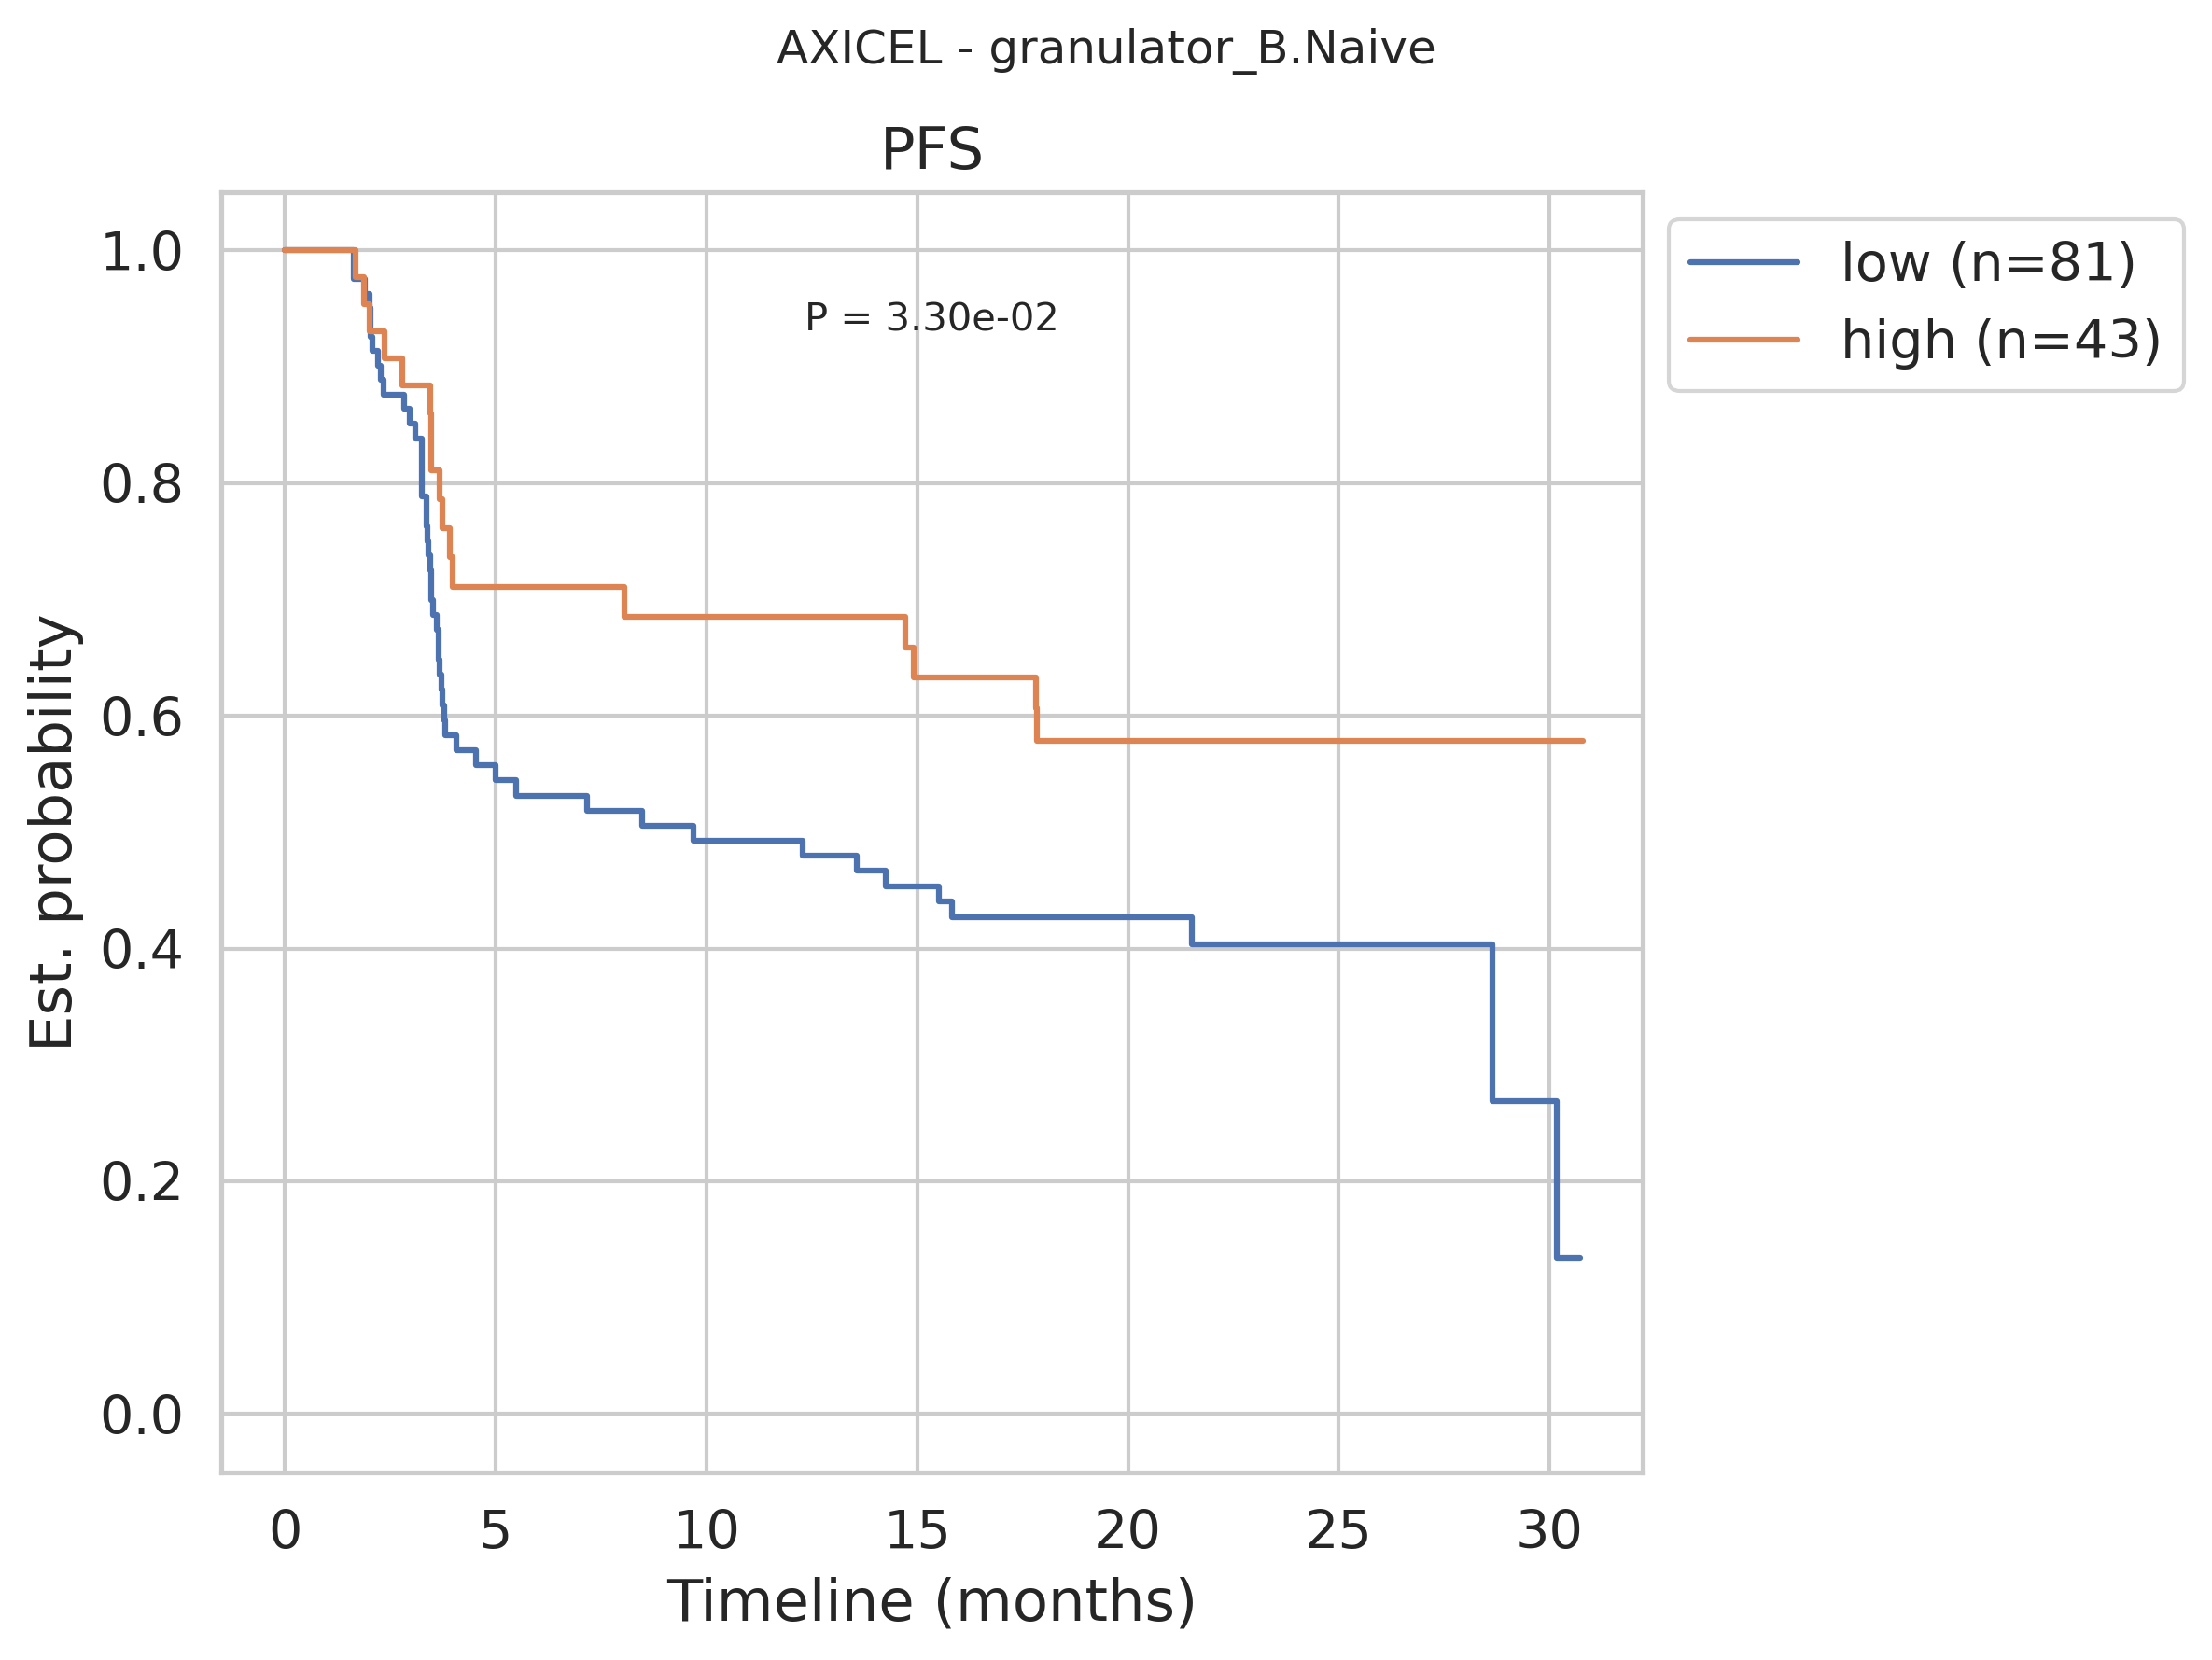

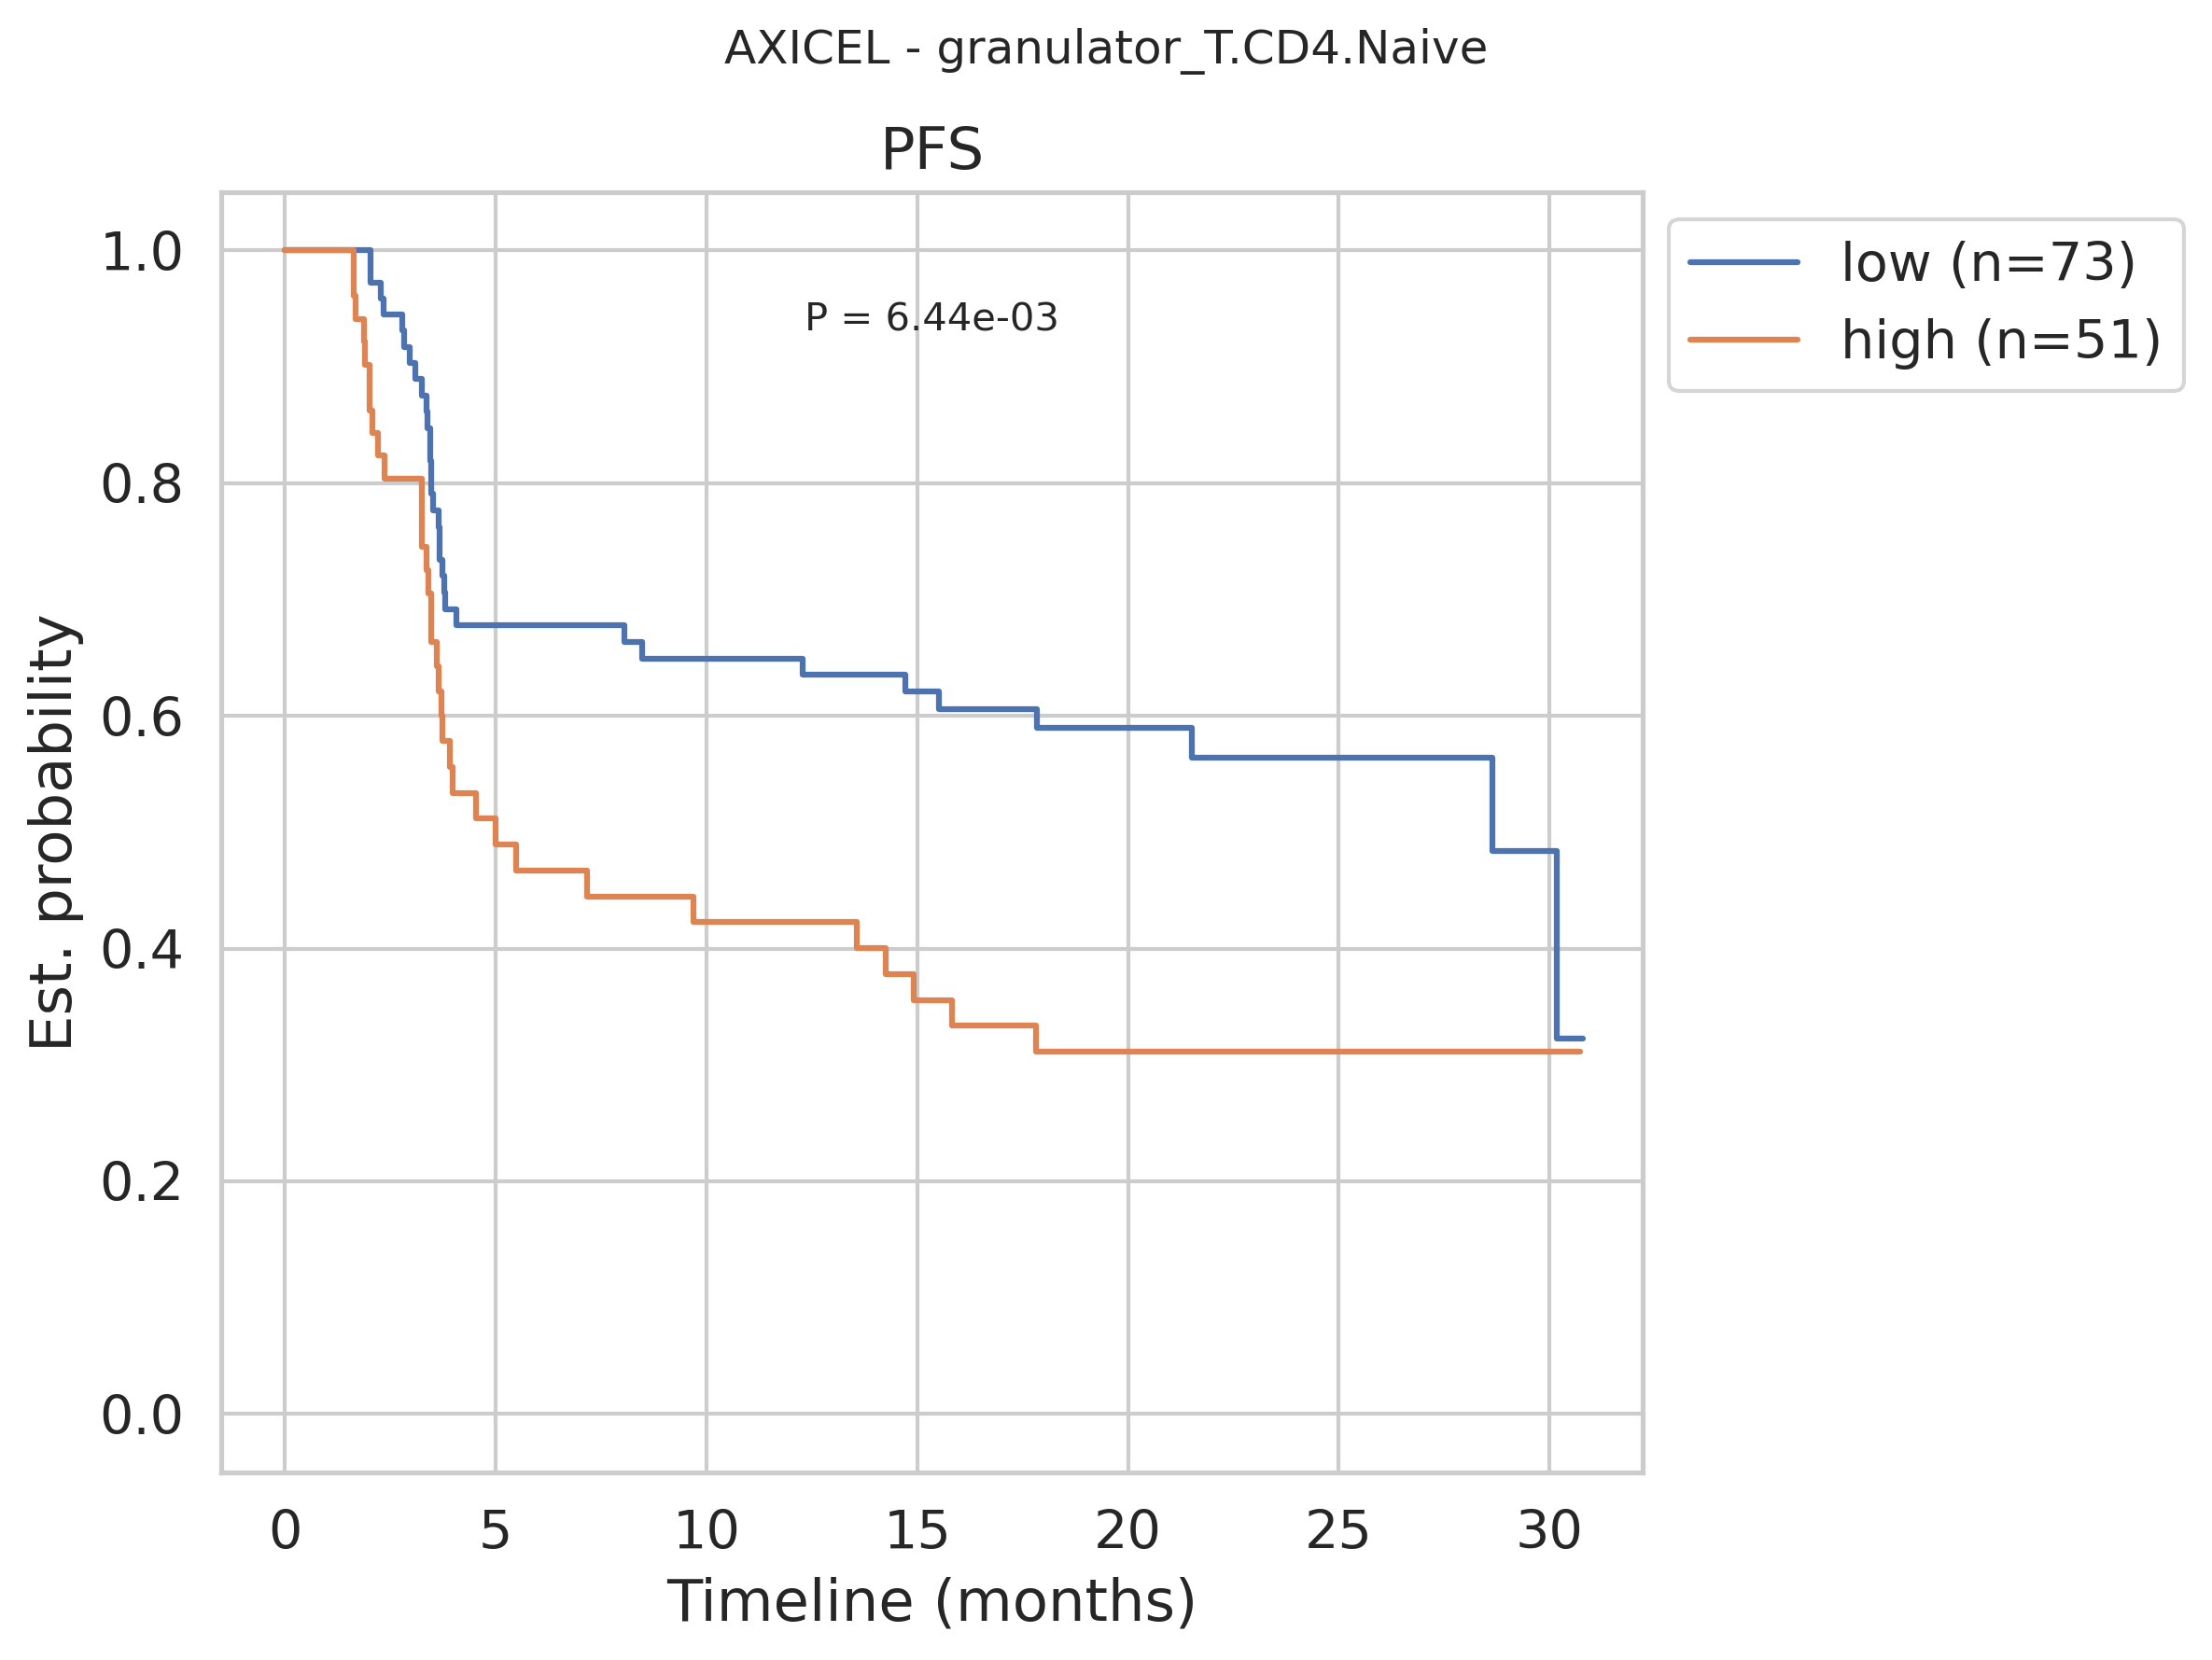

In [21]:
for celltype in significant_celltypes["AXICEL"]:
    plot_survival_ecotyper(response, ["PFS"], "AXICEL", celltype, show_p=True,
                           xlim=(-1.5, 32.2), ylim=(-0.05, 1.05))

In [22]:
# save response
response.to_parquet(data_path/"step01_zuma7_response.parquet")
response.to_csv(data_path/"step01_zuma7_response.csv")